MS/non-MS classification with radiomics  
  
E. Lavrova 30.04.2020  
  
MS/non-MS classification with radiomics-based models, created separately:
* for different MRI modalities:  
    * T1w - conventional  
    * PD (proton density) - qMRI map  
    * MT (magnetization transfer) - qMRI map  
    * R1 (inversed longitudinal relaxation time) - qMRI map  
    * R2* (inversed transversal relaxation time) - qMRI map  
    * combined qMRI maps (PD + MT + R1 + R2*)
* for different ROIs:  
    * WM - whole white matter
    * NAWM - normal appearing white matter (white matter excluding lesions)
    * GM - grey matter
    
→ 18 models

* different learning methods are tried:  
    * RFC - random forest classifier
    * SVC - support vector classifier
    * LRC - logistic regression classifier
    
→ 54 models  
  
**Training**: on training subset of ds1  
**Testing**: on testing subset of ds1  
**External validation**: on combined ds2 + ds3 (healthy controls + MS patients)

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc
import numpy as np
import scipy as sp
from scipy.stats import rankdata
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, make_scorer, roc_curve, auc
spec_score = make_scorer(recall_score, pos_label=0)

# User defined functions

In [37]:
def modelPerformance(model, model_name, x_test, y_test, 
                     acc_scores, auc_scores, sens_scores, spec_scores, tprs, mean_fpr, ys_true, ys_pred, ys_score):
    
    # calculation of the outcomes + performance metrics and appending to corresponding lists
    
    # input:
    # model - classification model (estimator)
    # model_name - name of the model, string
    # x_test - feature values (array, columns = features, rows = observations),
    # y_test - list of outcome values (list)
    # acc_scores, auc_scores, sens_scorec, spec_scores - lists of performance scores: accuracy, AUC, sensitivity, specificity
    # tprs - list of TPRs (list)
    # mean_fpr - array of mean FPR for interpolation of real FPR (1D aray)
    # ys_true - real values of outcomes (list)
    # ys_pred - predicted values of outcomes (list)
    # ys_score - list of predict class probabilities (list)
    # (the new values will be appended to)
    
    # output:
    # void
    
    y_pred = model.predict(x_test)
    if model_name == 'RFC':
        y_score = model.predict_proba(x_test)[:,1]
    else:
        y_score = model.decision_function(x_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_score))
    sens_scores.append(recall_score(y_test, y_pred))
    spec_scores.append(recall_score(y_test, y_pred, pos_label = 0))
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    ys_true.append(list(y_test))
    ys_pred.append(list(y_pred))
    ys_score.append(list(y_score))
    
def plotROC(mean_fpr, tprs):
    
    # plots ROC
    
    # input:
    # mean_fpr - array with mean FPR (1D array)
    # tprs - list of TPRs (list)
    
    # output:
    # void
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    median_tpr = np.median(tprs, axis=0)
    median_tpr[-1] = 1.0
    plt.plot(mean_fpr, median_tpr, color='b', lw=2, alpha=.8, label = 'Median ROC')

    tprs_upper = np.percentile(tprs, 97.5, axis=0)
    tprs_lower = np.percentile(tprs, 2.5, axis=0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='95% CI')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend()
    
    
def plotLC(model, ds_train, ds_test, n_splits, features_to_model):
    
    # plots learning curve
    
    # input:
    # model - classification model (estimator)
    # ds_train - dataframe with training data (dataframe, columns = features, rows = observations)
    # ds_test - dataframe with testing data (dataframe, columns = features, rows = observations)
    # n_splits - number of bootstrap splits (int)
    # features_to_model - names of features in feature vector (list of string)
    
    # output:
    # void
    
    train_scores = []
    test_scores = []
    
    train_sizes = [round(len(ds_train)/2), len(ds_train), len(ds_train)*2]
    
    for train_size in train_sizes:
        
        class_size = round(train_size/2)
        train_scores_sub = []
        test_scores_sub = []
        
        for i in range (0, n_splits):

            np.random.seed(i)
            subs_train_0 = np.random.choice(ds_train.loc[ds_train.outcome == 0].index.values, class_size)
            subs_train_1 = np.random.choice(ds_train.loc[ds_train.outcome == 1].index.values, class_size)
            subs_train = np.concatenate((subs_train_0, subs_train_1), axis = None)
            ds_train_set = ds_train.reindex(subs_train)

            subs_test_0 = np.random.choice(ds_test.loc[ds_test.outcome == 0].index.values, 50)
            subs_test_1 = np.random.choice(ds_test.loc[ds_test.outcome == 1].index.values, 50)
            subs_test = np.concatenate((subs_test_0, subs_test_1), axis = None)
            ds_test_set = ds_test.reindex(subs_test)

            X_train = ds_train_set[features_to_model]
            y_train = ds_train_set.outcome
            X_train_s = MinMaxScaler().fit_transform(X_train)

            X_test = ds_test_set[features_to_model]
            y_test = ds_test_set.outcome
            X_test_s = MinMaxScaler().fit_transform(X_test)
            
            model.fit(X_train_s, y_train)
            y_pred_train = model.predict(X_train_s)
            y_pred_test = model.predict(X_test_s)
            train_scores_sub.append(accuracy_score(y_train, y_pred_train))
            test_scores_sub.append(accuracy_score(y_test, y_pred_test))
            
        train_scores.append(train_scores_sub)
        test_scores.append(test_scores_sub)
    
    train_scores_median = np.median(train_scores, axis=1)
    train_scores_perc5 = np.percentile(train_scores, 2.5, axis=1)
    train_scores_perc95 = np.percentile(train_scores, 97.5, axis=1)
    test_scores_median = np.median(test_scores, axis=1)
    test_scores_perc5 = np.percentile(test_scores, 2.5, axis=1)
    test_scores_perc95 = np.percentile(test_scores, 97.5, axis=1)
    
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.fill_between(train_sizes, train_scores_perc5, train_scores_perc95, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_perc5, test_scores_perc95, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_median, 'o-', color="r",
             label='Training score (95% CI)')
    plt.plot(train_sizes, test_scores_median, 'o-', color="g",
             label='Cross-validation score (95% CI)')
    plt.legend(loc = 'best')
    
def plotAUCdist(aucs):
    
    # plots distribution of AUC scores obtained with bootstrap splits
    
    # input:
    # aucs - list of AUC values (list)
    
    # output:
    # void
    
    plt.hist(aucs)
    plt.xlabel('AUC')
    plt.ylabel('Count')
    
def classificationPipeline(modality_name, roi_name, n_splits, pt = False):
    
    # performs classification:
    # reads the feature values for the selected features, 
    # trains the models (RFC, SCV, LRC) on the training subset of the development dataset,
    # tests the models on the testing subsets;
    # shows median classification scores, distribution of AUC scores, learning curves, ROCs;
    # saves the classifiation scores, real and predicted outcomes
    
    # input:
    # modality_name - name of qMRI modality ({'T1w', 'PD', 'MT', 'R1', 'R2s', 'qMRI'})
    # roi_name - name of ROI ({'WM', 'NAWM', 'GM'})
    # n_splits - number of bootstrap splits (int)
    # pt - permutation test flag (bool)
    
    # output:
    # model_RFC, model_SVC, model_LRC - trained classifiers (estimators)
    
    
    # list of features to model
    f_to_m_name = '../results/features_to_model/features_to_model_' + modality_name + '_' + roi_name + '.txt'
    if pt:
        f_to_m_name = '../results/features_to_model/features_to_model_' + modality_name + '_' + roi_name + '_rand.txt'
        
    
    with open(f_to_m_name, "r") as f:
        features_to_model=[i[:-1] for line in f for i in line.split('/n')]
        
    print ('Features to model:', features_to_model)
    
    # open features dataset, putting the data into train and test dataframe, 
    # according to 'ds1_train_names.txt' and 'ds1_test_names.txt'
    ds = pd.read_csv('../results/features/features_CRC_' + modality_name + '_' + roi_name + '.csv')
    ds.set_index('sub', inplace = True)
    ds_train = ds.reindex(ds_train_names)
    ds_test = ds.reindex(ds_test_names)
    
    if pt:
        outc_rand = np.ones(len(ds_test))
        outc_rand[:int(len(ds_test)/2)] = 0
        np.random.shuffle(outc_rand)
        ds_test['outcome'] = outc_rand
        ds_train = pd.read_csv('../results/features/features_CRC_' + modality_name + '_' + roi_name + '_rand.csv')
        ds_train.set_index('sub', inplace = True)
    
    # initializing the models
    model_RFC = RandomForestClassifier(n_estimators=100, random_state = np.random.seed(0))  
    model_SVC = SVC(kernel='rbf', probability=True)
    model_LRC = LogisticRegression(penalty="l2", dual =True, solver = 'liblinear', random_state = np.random.seed(0),
                                  class_weight = 'balanced') 
    
    # initializing lists of perfromance metrics
    acc_scores_RFC = []
    acc_scores_SVC = []
    acc_scores_LRC = []

    auc_scores_RFC = []
    auc_scores_SVC = []
    auc_scores_LRC = []

    sens_scores_RFC = []
    sens_scores_SVC = []
    sens_scores_LRC = []

    spec_scores_RFC = []
    spec_scores_SVC = []
    spec_scores_LRC = []

    tprs_RFC = []
    tprs_SVC = []
    tprs_LRC = []
    
    ys_true_RFC = []
    ys_true_SVC = []
    ys_true_LRC = []
    ys_pred_RFC = []
    ys_pred_SVC = []
    ys_pred_LRC = []
    
    ys_score_RFC = []
    ys_score_SVC = []
    ys_score_LRC = []

    mean_fpr = np.linspace(0, 1, 100)
    
    # training feature and outcome values to arrays
    X_train = ds_train[features_to_model]
    y_train = ds_train.outcome
    X_train_s = MinMaxScaler().fit_transform(X_train)
    
    # classification models training
    model_RFC.fit(X_train_s, y_train)
    model_SVC.fit(X_train_s, y_train)
    model_LRC.fit(X_train_s, y_train)
    
    # classification models testing with bootstrap
    for i in range (0, n_splits):
    
        # generation of test subsample
        np.random.seed(i)
        subs_test_0 = np.random.choice(ds_test.loc[ds_test.outcome == 0].index.values, 50)
        subs_test_1 = np.random.choice(ds_test.loc[ds_test.outcome == 1].index.values, 50)
        subs_test = np.concatenate((subs_test_0, subs_test_1), axis = None)
        ds_test_set = ds_test.reindex(subs_test)

        X_test = ds_test_set[features_to_model]
        y_test = ds_test_set.outcome
        X_test_s = MinMaxScaler().fit_transform(X_test)

        # prediction and calculation of performance metrics for current bootstrap step
        modelPerformance(model_RFC, 'RFC', X_test_s, y_test, 
                         acc_scores_RFC, auc_scores_RFC, sens_scores_RFC, spec_scores_RFC, tprs_RFC, mean_fpr, 
                         ys_true_RFC, ys_pred_RFC, ys_score_RFC)
        modelPerformance(model_SVC, 'SVC', X_test_s, y_test, 
                         acc_scores_SVC, auc_scores_SVC, sens_scores_SVC, spec_scores_SVC, tprs_SVC, mean_fpr, 
                         ys_true_SVC, ys_pred_SVC, ys_score_SVC)
        modelPerformance(model_LRC, 'LRC', X_test_s, y_test, 
                         acc_scores_LRC, auc_scores_LRC, sens_scores_LRC, spec_scores_LRC, tprs_LRC, mean_fpr, 
                         ys_true_LRC, ys_pred_LRC, ys_score_LRC)
   
    
    # plots
    
    # learning curves
    plt.figure(figsize = (15, 5))

    plt.subplot(1, 3, 1)
    plt.grid()
    plotLC(model_RFC, ds_train, ds_test, n_splits, features_to_model)
    plt.title('Learning curves (RFC)')

    plt.subplot(1, 3, 2)
    plt.grid()
    plotLC(model_SVC, ds_train, ds_test, n_splits, features_to_model)
    plt.title('Learning curves (SVC)')

    plt.subplot(1, 3, 3)
    plt.grid()
    plotLC(model_LRC, ds_train, ds_test, n_splits, features_to_model)
    plt.title('Learning curves (LRC)')

    plt.suptitle('Learning curves')
    plt.show()
    
    # ROC
    plt.figure(figsize = (15, 5))
    
    plt.subplot(1, 3, 1)
    plt.grid()
    plotROC(mean_fpr, tprs_RFC)
    plt.title('Receiver operating characteristic (RFC)')

    plt.subplot(1, 3, 2)
    plt.grid()
    plotROC(mean_fpr, tprs_SVC)
    plt.title('Receiver operating characteristic (SVC)')

    plt.subplot(1, 3, 3)
    plt.grid()
    plotROC(mean_fpr, tprs_LRC)
    plt.title('Receiver operating characteristic (LRC)')

    plt.suptitle('Receiver operating characteristics')
    plt.show()
    
    # AUC scores distribution
    plt.figure(figsize = (15, 5))
    
    plt.subplot(1, 3, 1)
    plt.grid()
    plotAUCdist(auc_scores_RFC)
    plt.title('AUC scores distribution (RFC)')

    plt.subplot(1, 3, 2)
    plt.grid()
    plotAUCdist(auc_scores_SVC)
    plt.title('AUC scores distribution (SVC)')

    plt.subplot(1, 3, 3)
    plt.grid()
    plotAUCdist(auc_scores_LRC)
    plt.title('AUC scores distribution (LRC)')

    plt.suptitle('AUC scores distributions')
    plt.show()
    
    # performance metrics to csv files
    df_acc_scores=pd.DataFrame({'model': 'RFC', 'scores': acc_scores_RFC}).\
    append(pd.DataFrame({'model': 'SVC', 'scores': acc_scores_SVC})).\
    append(pd.DataFrame({'model': 'LRC', 'scores': acc_scores_LRC}))
    df_auc_scores=pd.DataFrame({'model': 'RFC', 'scores': auc_scores_RFC}).\
    append(pd.DataFrame({'model': 'SVC', 'scores': auc_scores_SVC})).\
    append(pd.DataFrame({'model': 'LRC', 'scores': auc_scores_LRC}))
    df_sens_scores=pd.DataFrame({'model': 'RFC', 'scores': sens_scores_RFC}).\
    append(pd.DataFrame({'model': 'SVC', 'scores': sens_scores_SVC})).\
    append(pd.DataFrame({'model': 'LRC', 'scores': sens_scores_LRC}))
    df_spec_scores=pd.DataFrame({'model': 'RFC', 'scores': spec_scores_RFC}).\
    append(pd.DataFrame({'model': 'SVC', 'scores': spec_scores_SVC})).\
    append(pd.DataFrame({'model': 'LRC', 'scores': spec_scores_LRC}))
    
    df_acc_scores['metric'] = 'accuracy'
    df_auc_scores['metric'] = 'AUC'
    df_sens_scores['metric'] = 'sensitivity'
    df_spec_scores['metric'] = 'specificity'

    df_acc_scores['modality_name'] = modality_name
    df_auc_scores['modality_name'] = modality_name
    df_sens_scores['modality_name'] = modality_name
    df_spec_scores['modality_name'] = modality_name

    df_acc_scores['roi_name'] = roi_name
    df_auc_scores['roi_name'] = roi_name
    df_sens_scores['roi_name'] = roi_name
    df_spec_scores['roi_name'] = roi_name
    
    pt_flag = ''
    if pt:
        pt_flag = '_rand'
    
    df_acc_scores.to_csv('../results/performance/performance_acc_CRC_' + modality_name + '_' + roi_name + pt_flag + '.csv')
    df_auc_scores.to_csv('../results/performance/performance_auc_CRC_' + modality_name + '_' + roi_name + pt_flag + '.csv')
    df_sens_scores.to_csv('../results/performance/performance_sens_CRC_' + modality_name + '_' + roi_name + pt_flag + '.csv')
    df_spec_scores.to_csv('../results/performance/performance_spec_CRC_' + modality_name + '_' + roi_name + pt_flag + '.csv')

    
    # comparison of performance metrics (boxplot)
    plt.figure(figsize = (10, 10))

    plt.subplot(2, 2, 1)
    sns.boxplot(x='model', y='scores', data=df_acc_scores)
    plt.title('Accuracy scores')

    plt.subplot(2, 2, 2)
    sns.boxplot(x='model', y='scores', data=df_auc_scores)
    plt.title('AUC scores')

    plt.subplot(2, 2, 3)
    sns.boxplot(x='model', y='scores', data=df_sens_scores)
    plt.title('Sensitivity scores')

    plt.subplot(2, 2, 4)
    sns.boxplot(x='model', y='scores', data=df_spec_scores)
    plt.title('Specificity scores')

    plt.suptitle('Classification performance metrics')
    plt.show()
    
    # comparison of performance metrics
    rec_acc = {'score': 'accuracy', 
               'RFC': '%.2f (%.2f, %.2f)' % (np.median(acc_scores_RFC), 
                                             np.percentile(acc_scores_RFC, 2.5), np.percentile(acc_scores_RFC, 97.5)), 
               'SVC': '%.2f (%.2f, %.2f)' % (np.median(acc_scores_SVC), 
                                             np.percentile(acc_scores_SVC, 2.5), np.percentile(acc_scores_SVC, 97.5)), 
               'LRC': '%.2f (%.2f, %.2f)' % (np.median(acc_scores_LRC), 
                                             np.percentile(acc_scores_LRC, 2.5), np.percentile(acc_scores_LRC, 97.5)), 
               }
    rec_auc = {'score': 'AUC', 
               'RFC': '%.2f (%.2f, %.2f)' % (np.median(auc_scores_RFC), 
                                             np.percentile(auc_scores_RFC, 2.5), np.percentile(auc_scores_RFC, 97.5)), 
               'SVC': '%.2f (%.2f, %.2f)' % (np.median(auc_scores_SVC), 
                                             np.percentile(auc_scores_SVC, 2.5), np.percentile(auc_scores_SVC, 97.5)), 
               'LRC': '%.2f (%.2f, %.2f)' % (np.median(auc_scores_LRC), 
                                             np.percentile(auc_scores_LRC, 2.5), np.percentile(auc_scores_LRC, 97.5)), 
               
              }
    rec_sens = {'score': 'sensitivity',
                'RFC': '%.2f (%.2f, %.2f)' % (np.median(sens_scores_RFC), 
                                              np.percentile(sens_scores_RFC, 2.5), np.percentile(sens_scores_RFC, 97.5)), 
                'SVC': '%.2f (%.2f, %.2f)' % (np.median(sens_scores_SVC), 
                                              np.percentile(sens_scores_SVC, 2.5), np.percentile(sens_scores_SVC, 97.5)),
                'LRC': '%.2f (%.2f, %.2f)' % (np.median(sens_scores_LRC), 
                                              np.percentile(sens_scores_LRC, 2.5), np.percentile(sens_scores_LRC, 97.5)), 
                
               }
    rec_spec = {'score': 'specificity',
                'RFC': '%.2f (%.2f, %.2f)' % (np.median(spec_scores_RFC), 
                                              np.percentile(spec_scores_RFC, 2.5), np.percentile(spec_scores_RFC, 97.5)), 
                'SVC': '%.2f (%.2f, %.2f)' % (np.median(spec_scores_SVC), 
                                              np.percentile(spec_scores_SVC, 2.5), np.percentile(spec_scores_SVC, 97.5)),
                'LRC': '%.2f (%.2f, %.2f)' % (np.median(spec_scores_LRC), 
                                              np.percentile(spec_scores_LRC, 2.5), np.percentile(spec_scores_LRC, 97.5)), 
                
               }

    df_performance = pd.DataFrame([rec_acc, rec_auc, rec_sens, rec_spec], columns = ['score', 'RFC', 'SVC', 'LRC'])
    df_performance.set_index('score', inplace = True)

    print ('Performance metrics comparison')
    display (df_performance)
    
    # saving the outcomes
    ys_true_RFC = sum(ys_true_RFC, [])
    ys_true_SVC = sum(ys_true_SVC, [])
    ys_true_LRC = sum(ys_true_LRC, [])
    ys_pred_RFC = sum(ys_pred_RFC, [])
    ys_pred_SVC = sum(ys_pred_SVC, [])
    ys_pred_LRC = sum(ys_pred_LRC, [])
    
    ys_score_RFC = sum(ys_score_RFC, [])
    ys_score_SVC = sum(ys_score_SVC, [])
    ys_score_LRC = sum(ys_score_LRC, [])
    
    with open('../results/outcomes/ys_true_RFC_' + modality_name + '_' + roi_name + pt_flag + '.txt', 'w') as output:
        for y in ys_true_RFC:
            output.write(str(y) + '\n')
    with open('../results/results/outcomes/ys_pred_RFC_' + modality_name + '_' + roi_name + pt_flag + '.txt', 'w') as output:
        for y in ys_pred_RFC:
            output.write(str(y) + '\n')
    with open('../results/outcomes/ys_true_SVC_' + modality_name + '_' + roi_name + pt_flag + '.txt', 'w') as output:
        for y in ys_true_SVC:
            output.write(str(y) + '\n')
    with open('../results/outcomes/ys_pred_SVC_' + modality_name + '_' + roi_name + pt_flag + '.txt', 'w') as output:
        for y in ys_pred_SVC:
            output.write(str(y) + '\n')
    with open('../results/outcomes/ys_true_LRC_' + modality_name + '_' + roi_name + pt_flag + '.txt', 'w') as output:
        for y in ys_true_LRC:
            output.write(str(y) + '\n')
    with open('../results/outcomes/ys_pred_LRC_' + modality_name + '_' + roi_name + pt_flag + '.txt', 'w') as output:
        for y in ys_pred_LRC:
            output.write(str(y) + '\n')
    with open('../results/outcomes/ys_score_RFC_' + modality_name + '_' + roi_name + pt_flag + '.txt', 'w') as output:
        for y in ys_score_RFC:
            output.write(str(y) + '\n')
    with open('../results/outcomes/ys_score_SVC_' + modality_name + '_' + roi_name + pt_flag + '.txt', 'w') as output:
        for y in ys_score_SVC:
            output.write(str(y) + '\n')
    with open('../results/outcomes/ys_score_LRC_' + modality_name + '_' + roi_name + pt_flag + '.txt', 'w') as output:
        for y in ys_score_LRC:
            output.write(str(y) + '\n')
    
    return model_RFC, model_SVC, model_LRC

# Models testing on internal data

In [38]:
# reading names of the participants from train and test subsets of the development dataset

f = open('../results/names/ds1_test_names.txt', 'r')
ds_test_names = f.read().split('\n')
f.close()

f = open('../results/names/ds1_train_names.txt', 'r')
ds_train_names = f.read().split('\n')
f.close()

ds_test_names = ds_test_names[:-1]
ds_train_names = ds_train_names[:-1]

## White matter

Features to model: ['original_glcm_ClusterShade', 'original_firstorder_Range', 'original_glszm_SmallAreaEmphasis']


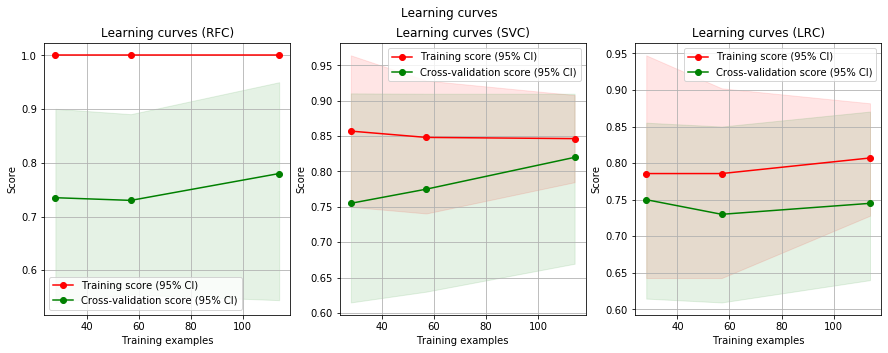

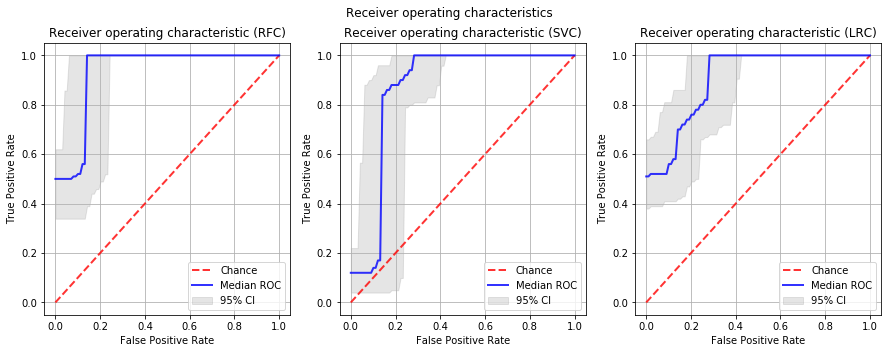

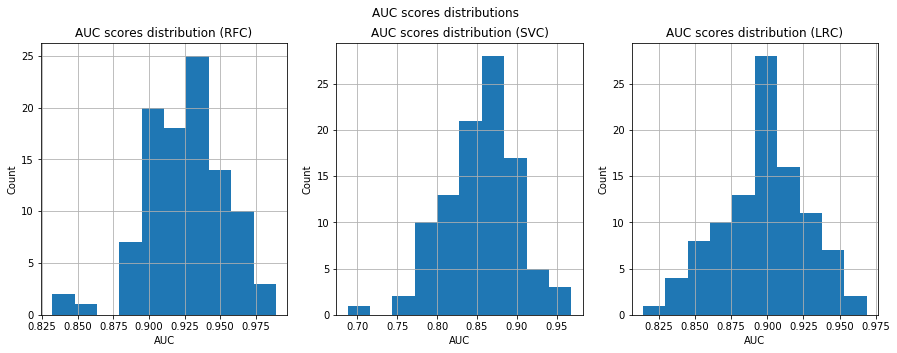

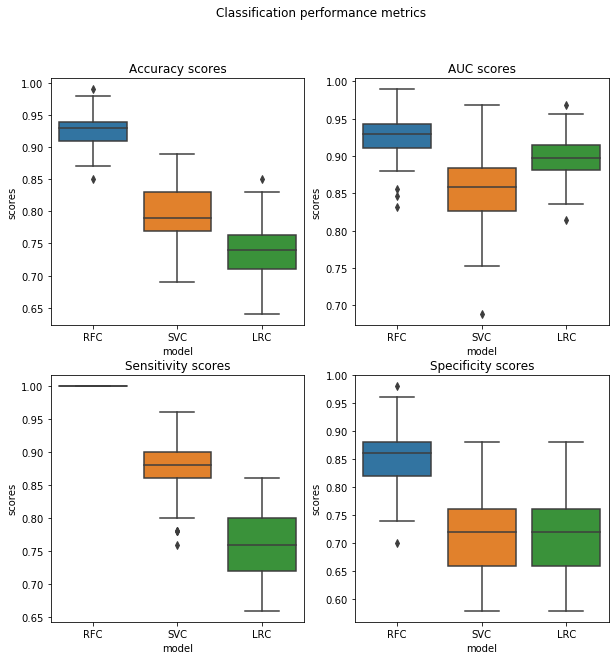

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.93 (0.88, 0.98)  0.79 (0.72, 0.87)  0.74 (0.66, 0.82)
AUC          0.93 (0.87, 0.98)  0.86 (0.77, 0.95)  0.90 (0.84, 0.95)
sensitivity  1.00 (1.00, 1.00)  0.88 (0.78, 0.94)  0.76 (0.67, 0.86)
specificity  0.86 (0.76, 0.95)  0.72 (0.59, 0.82)  0.72 (0.59, 0.82)

In [39]:
model_RFC_T1w_WM, model_SVC_T1w_WM, model_LRC_T1w_WM = classificationPipeline('T1w', 'WM', 100)

Features to model: ['original_firstorder_Skewness', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_glcm_MCC']


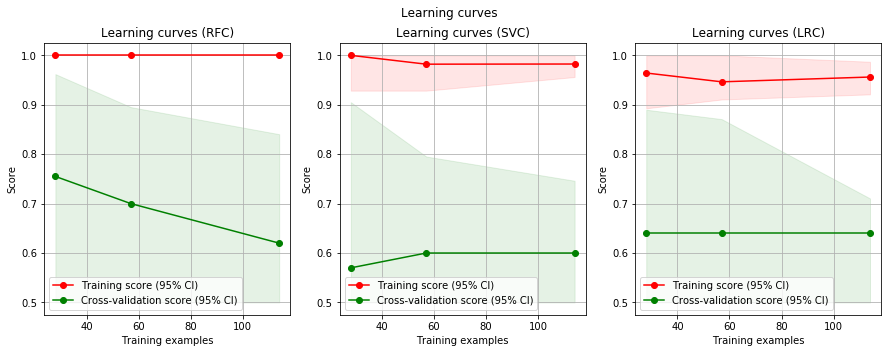

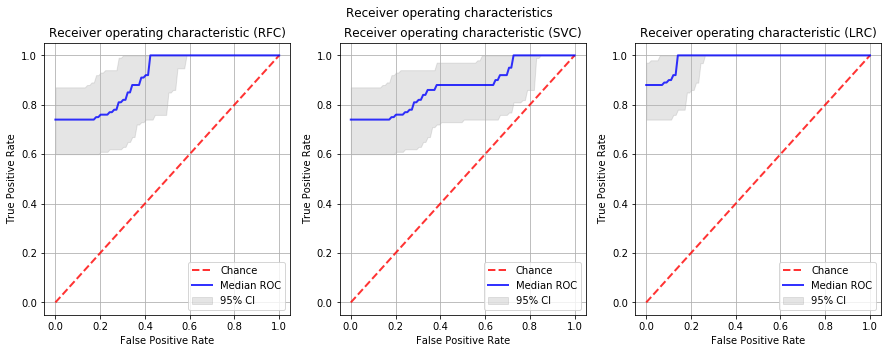

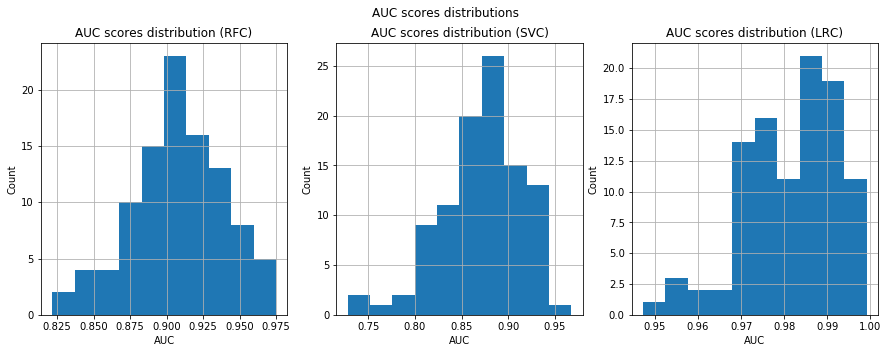

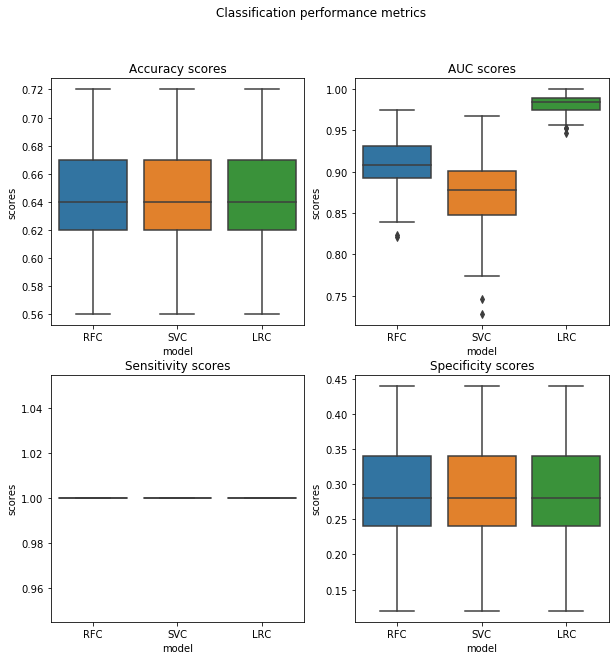

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.64 (0.58, 0.71)  0.64 (0.58, 0.71)  0.64 (0.58, 0.71)
AUC          0.91 (0.84, 0.96)  0.88 (0.78, 0.94)  0.98 (0.95, 1.00)
sensitivity  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)
specificity  0.28 (0.17, 0.42)  0.28 (0.17, 0.42)  0.28 (0.17, 0.42)

In [40]:
model_RFC_PD_WM, model_SVC_PD_WM, model_LRC_PD_WM = classificationPipeline('PD', 'WM', 100)

Features to model: ['original_firstorder_Minimum', 'original_glcm_ClusterProminence', 'original_glcm_MCC']


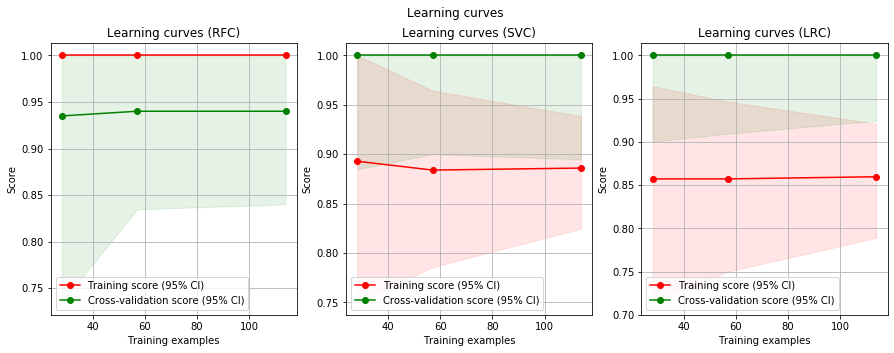

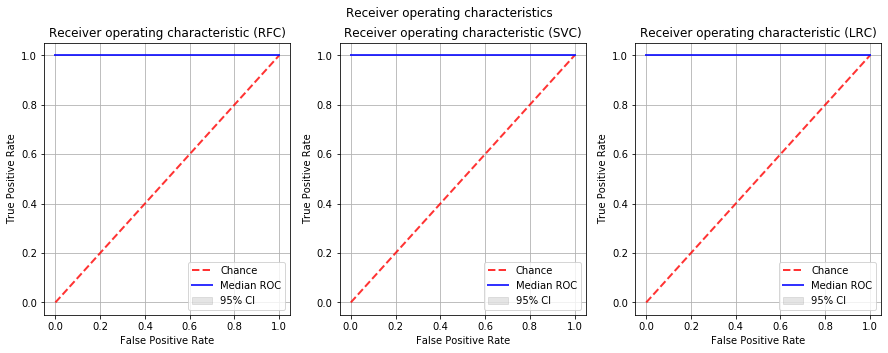

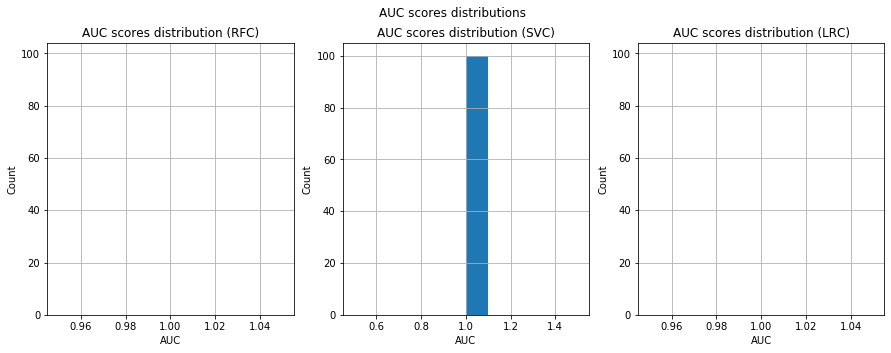

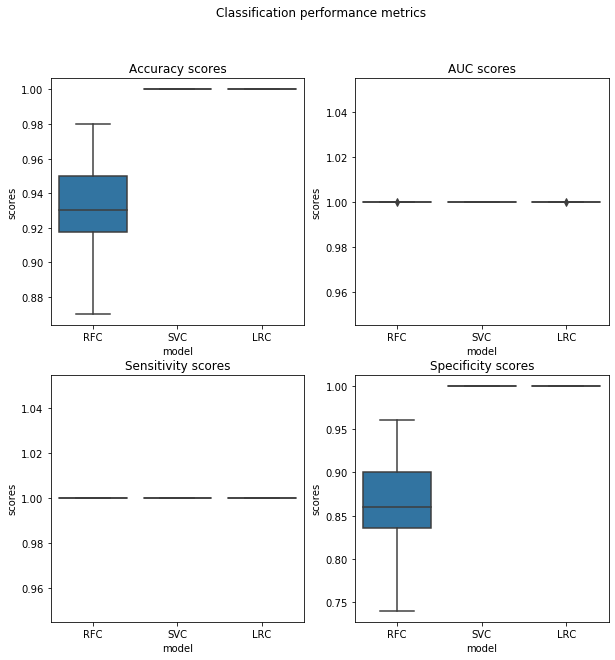

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.93 (0.88, 0.97)  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)
AUC          1.00 (1.00, 1.00)  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)
sensitivity  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)
specificity  0.86 (0.77, 0.94)  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)

In [41]:
model_RFC_MT_WM, model_SVC_MT_WM, model_LRC_MT_WM = classificationPipeline('MT', 'WM', 100)

Features to model: ['original_firstorder_Kurtosis', 'original_glcm_ClusterShade', 'original_glcm_MCC']


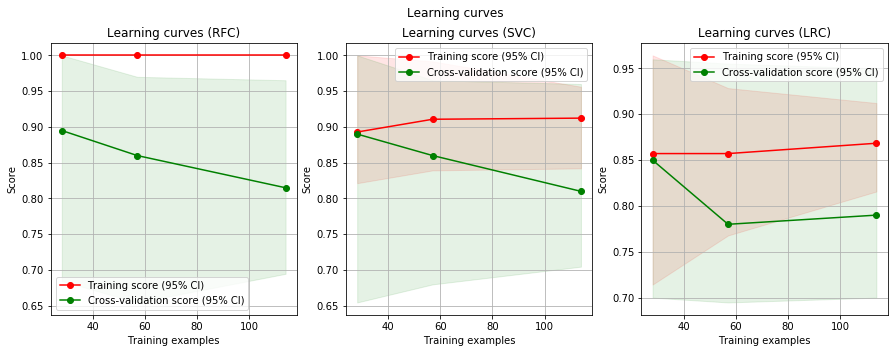

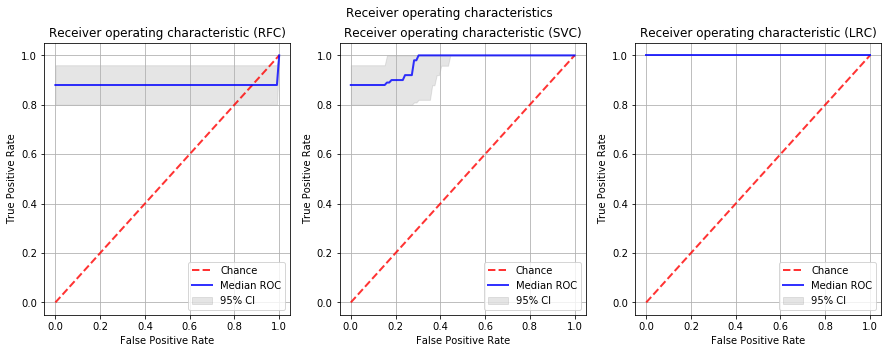

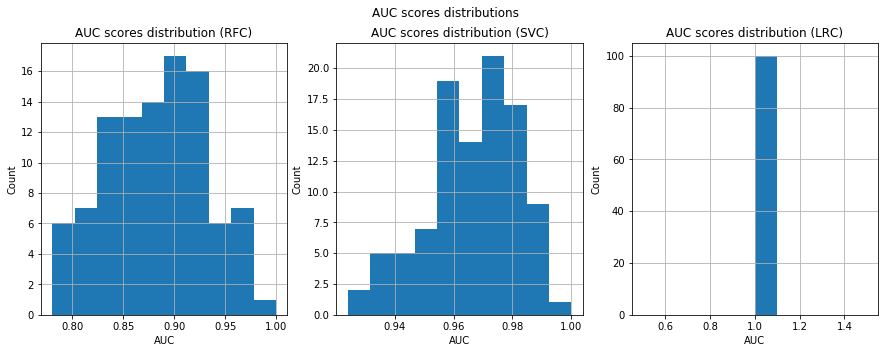

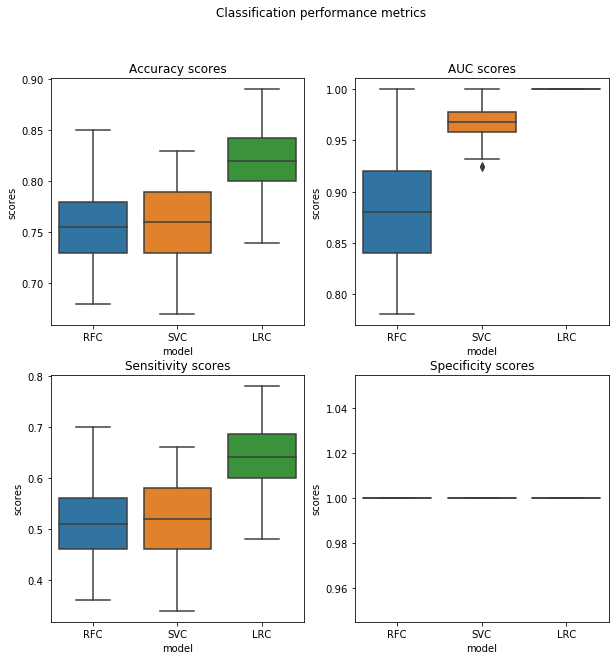

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.76 (0.69, 0.83)  0.76 (0.69, 0.82)  0.82 (0.76, 0.88)
AUC          0.88 (0.80, 0.96)  0.97 (0.93, 0.99)  1.00 (1.00, 1.00)
sensitivity  0.51 (0.38, 0.66)  0.52 (0.38, 0.64)  0.64 (0.52, 0.75)
specificity  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)

In [42]:
model_RFC_R1_WM, model_SVC_R1_WM, model_LRC_R1_WM = classificationPipeline('R1', 'WM', 100)

Features to model: ['original_glcm_ClusterShade', 'original_firstorder_Skewness', 'original_firstorder_Minimum']


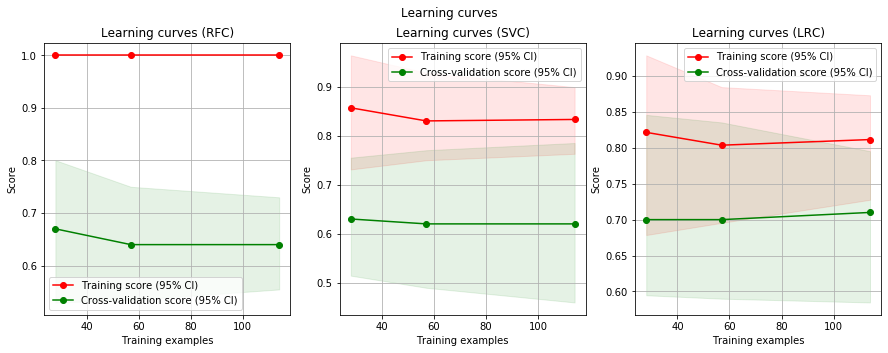

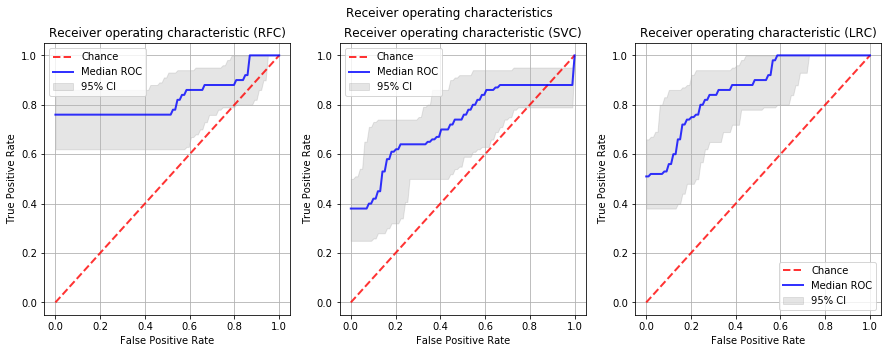

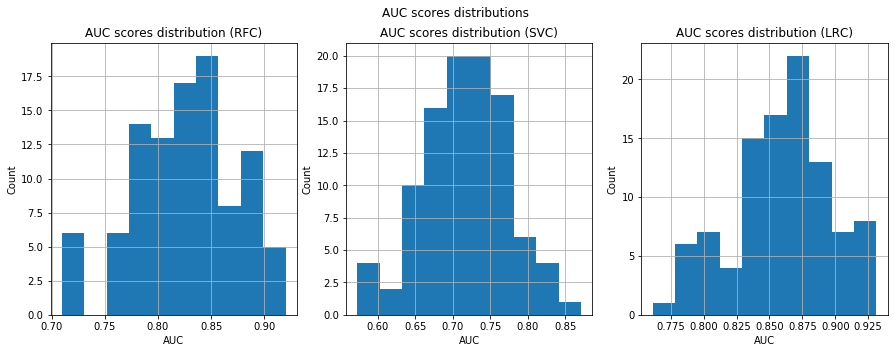

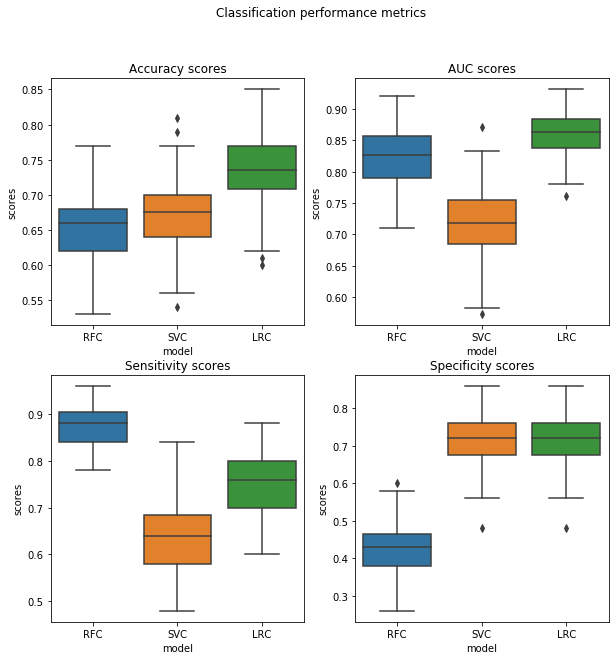

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.66 (0.57, 0.73)  0.68 (0.57, 0.77)  0.73 (0.63, 0.83)
AUC          0.83 (0.72, 0.91)  0.72 (0.60, 0.82)  0.86 (0.78, 0.93)
sensitivity  0.88 (0.79, 0.95)  0.64 (0.50, 0.74)  0.76 (0.62, 0.86)
specificity  0.43 (0.28, 0.57)  0.72 (0.58, 0.84)  0.72 (0.58, 0.84)

In [43]:
model_RFC_R2s_WM, model_SVC_R2s_WM, model_LRC_R2s_WM = classificationPipeline('R2s', 'WM', 100)

Features to model: ['PD_gldm_LargeDependenceHighGrayLevelEmphasis', 'R1_firstorder_Kurtosis', 'MT_firstorder_Minimum']


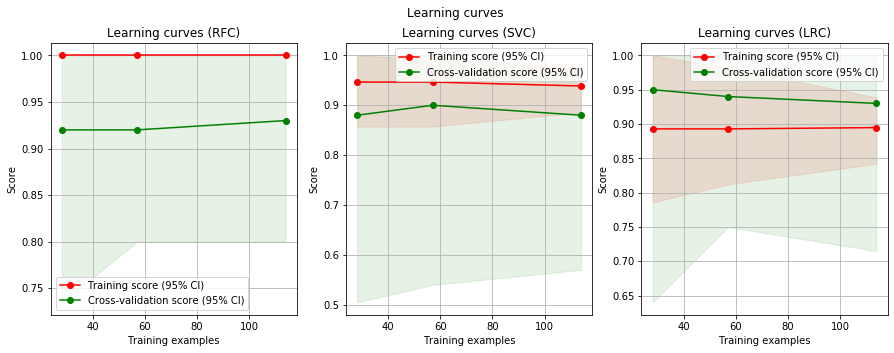

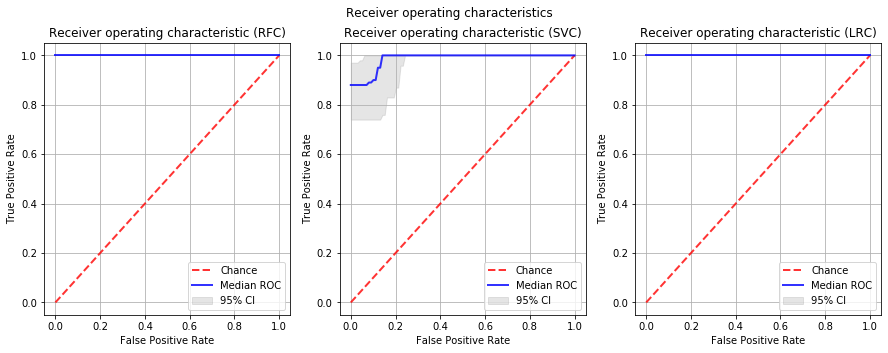

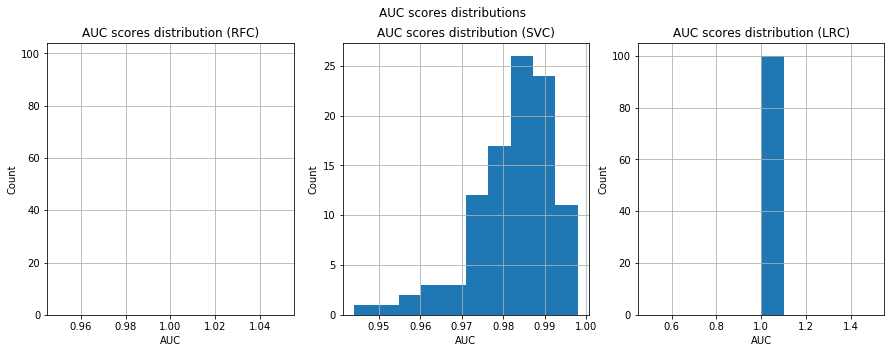

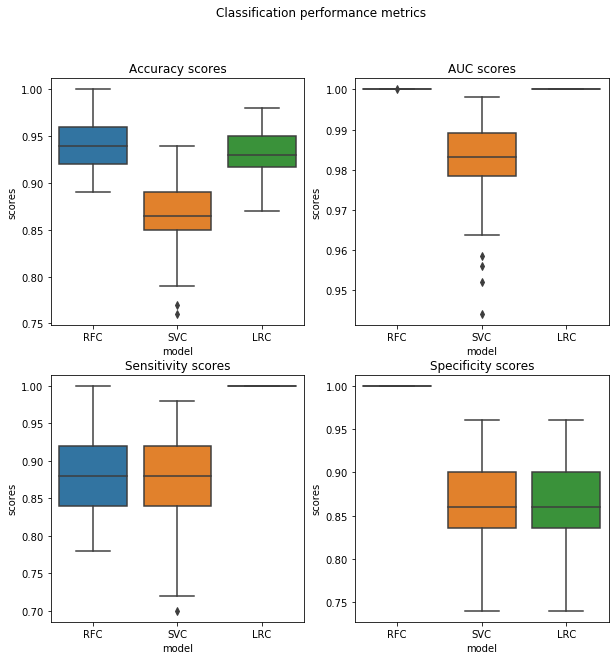

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.94 (0.90, 0.98)  0.86 (0.79, 0.92)  0.93 (0.88, 0.97)
AUC          1.00 (1.00, 1.00)  0.98 (0.96, 1.00)  1.00 (1.00, 1.00)
sensitivity  0.88 (0.80, 0.96)  0.88 (0.74, 0.97)  1.00 (1.00, 1.00)
specificity  1.00 (1.00, 1.00)  0.86 (0.77, 0.94)  0.86 (0.77, 0.94)

In [44]:
model_RFC_qMRI_WM, model_SVC_qMRI_WM, model_LRC_qMRI_WM = classificationPipeline('qMRI', 'WM', 100)

## Normal appearing white matter

Features to model: ['original_glcm_ClusterShade', 'original_firstorder_Variance', 'original_firstorder_90Percentile']


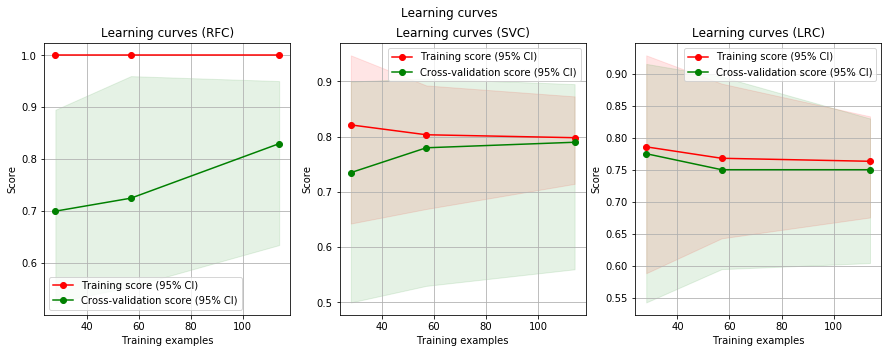

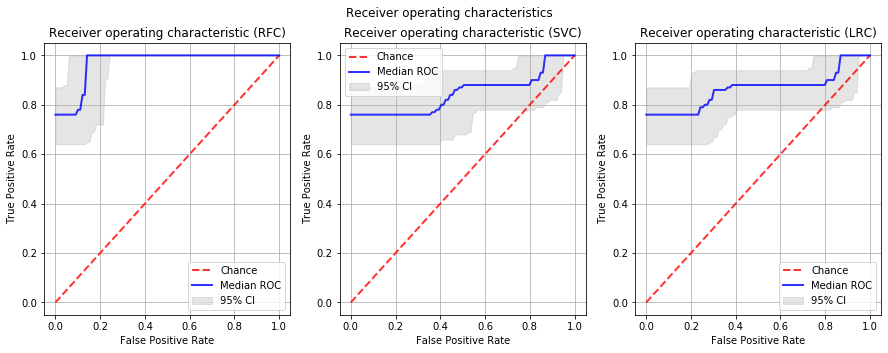

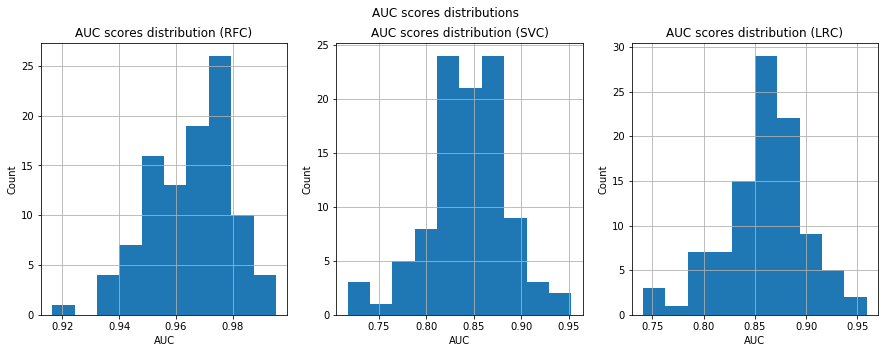

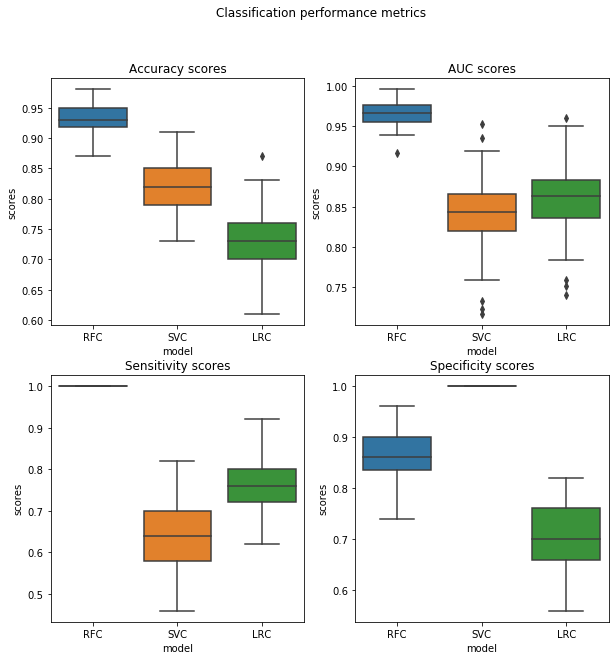

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.93 (0.88, 0.97)  0.82 (0.75, 0.88)  0.73 (0.66, 0.82)
AUC          0.97 (0.94, 0.99)  0.84 (0.75, 0.92)  0.86 (0.77, 0.93)
sensitivity  1.00 (1.00, 1.00)  0.64 (0.50, 0.76)  0.76 (0.64, 0.87)
specificity  0.86 (0.77, 0.94)  1.00 (1.00, 1.00)  0.70 (0.59, 0.81)

In [45]:
model_RFC_T1w_NAWM, model_SVC_T1w_NAWM, model_LRC_T1w_NAWM = classificationPipeline('T1w', 'NAWM', 100)

Features to model: ['original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade']


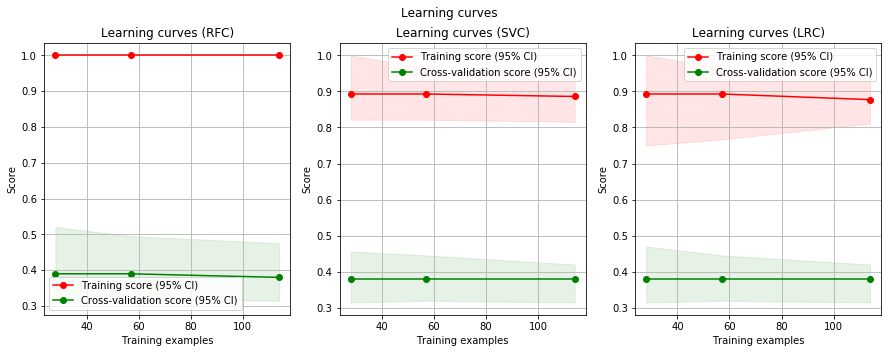

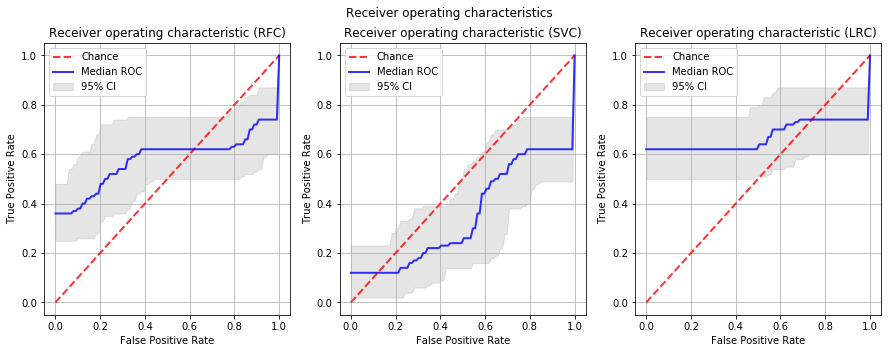

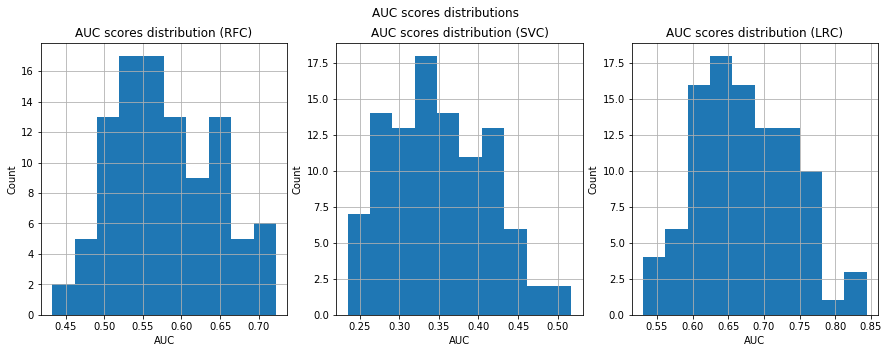

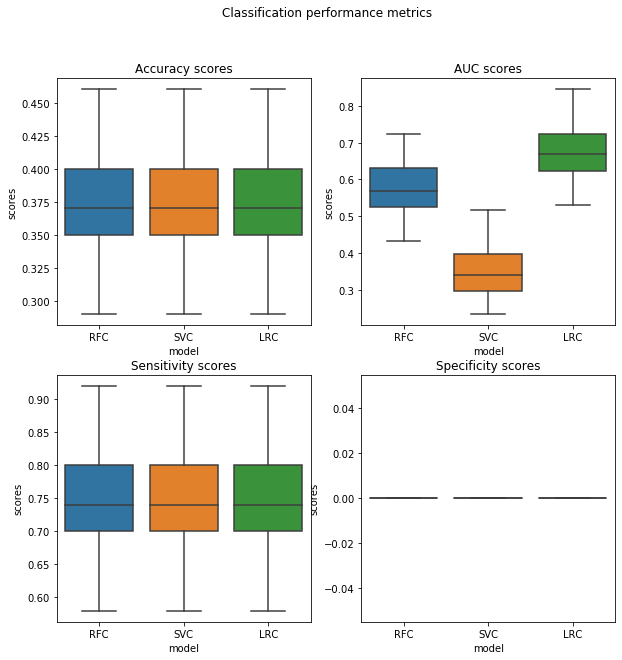

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.37 (0.30, 0.44)  0.37 (0.30, 0.44)  0.37 (0.30, 0.44)
AUC          0.57 (0.47, 0.72)  0.34 (0.25, 0.47)  0.67 (0.55, 0.81)
sensitivity  0.74 (0.60, 0.87)  0.74 (0.60, 0.87)  0.74 (0.60, 0.87)
specificity  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)

In [46]:
model_RFC_PD_NAWM, model_SVC_PD_NAWM, model_LRC_PD_NAWM = classificationPipeline('PD', 'NAWM', 100)

Features to model: ['original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_ngtdm_Complexity', 'original_firstorder_TotalEnergy']


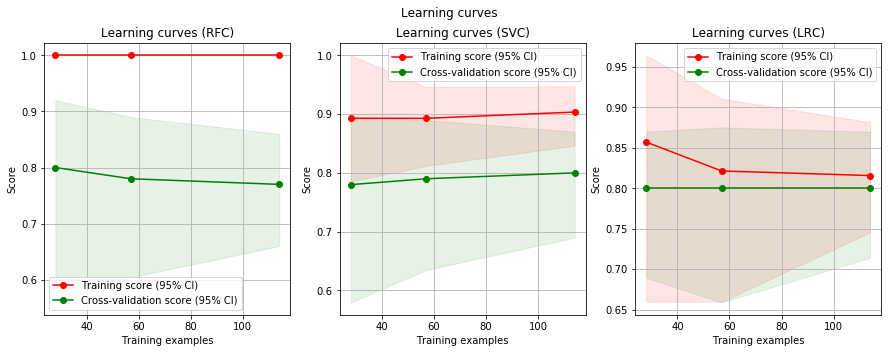

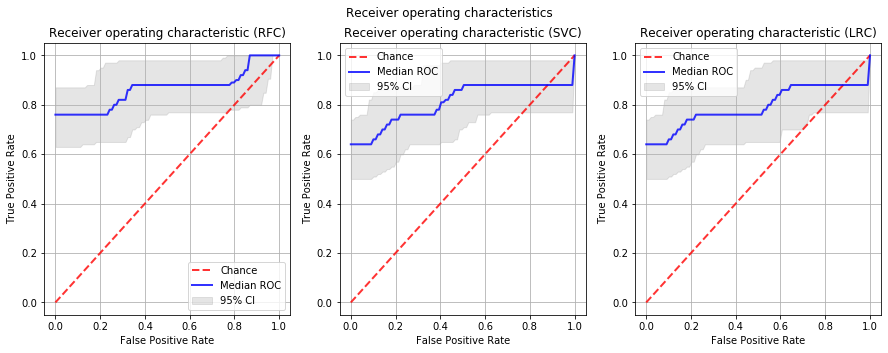

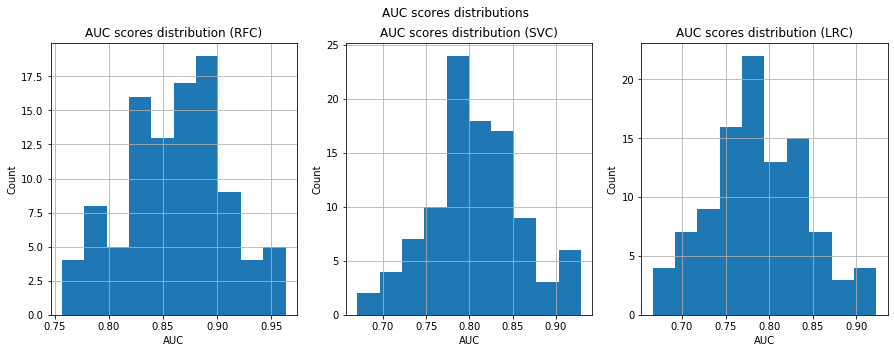

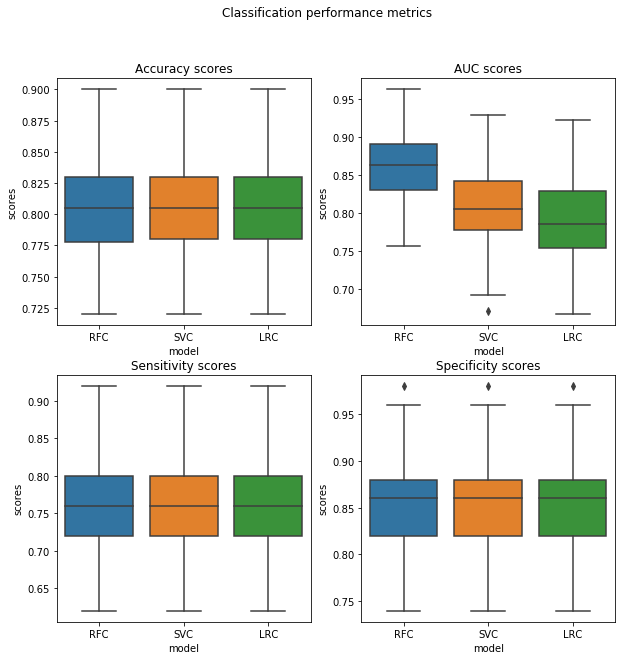

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.81 (0.73, 0.89)  0.81 (0.74, 0.89)  0.81 (0.74, 0.89)
AUC          0.86 (0.77, 0.96)  0.80 (0.71, 0.92)  0.79 (0.69, 0.90)
sensitivity  0.76 (0.64, 0.87)  0.76 (0.64, 0.87)  0.76 (0.64, 0.87)
specificity  0.86 (0.77, 0.94)  0.86 (0.77, 0.94)  0.86 (0.77, 0.94)

In [47]:
model_RFC_MT_NAWM, model_SVC_MT_NAWM, model_LRC_MT_NAWM = classificationPipeline('MT', 'NAWM', 100)

Features to model: ['original_firstorder_10Percentile', 'original_firstorder_Minimum', 'original_firstorder_MeanAbsoluteDeviation']


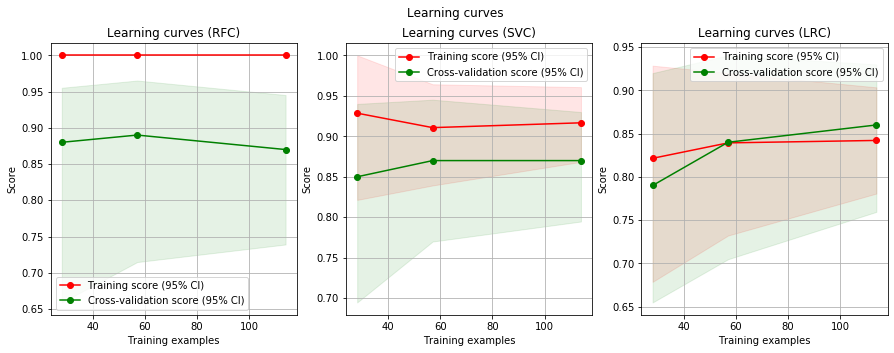

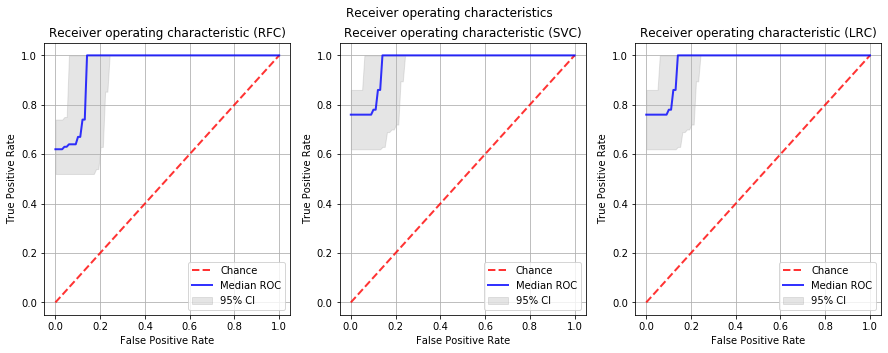

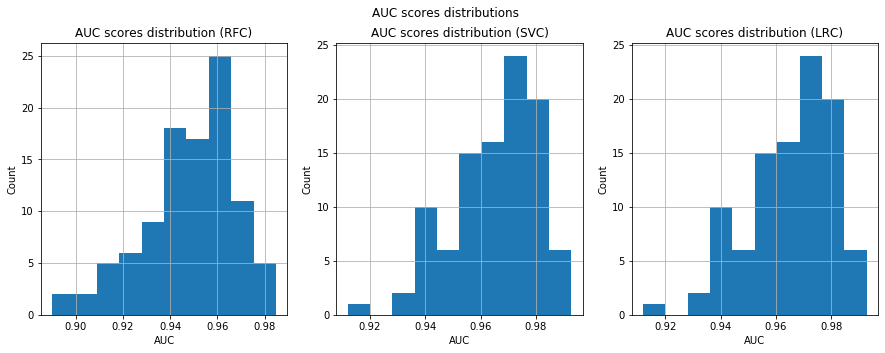

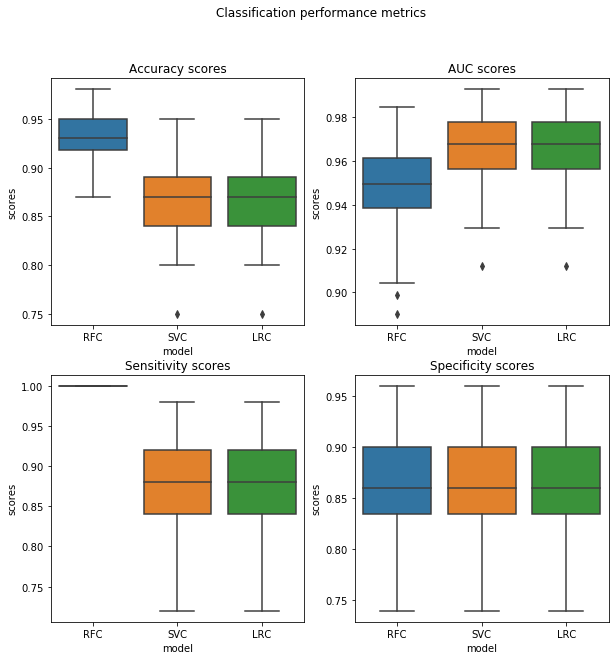

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.93 (0.88, 0.97)  0.87 (0.80, 0.93)  0.87 (0.80, 0.93)
AUC          0.95 (0.91, 0.98)  0.97 (0.93, 0.99)  0.97 (0.93, 0.99)
sensitivity  1.00 (1.00, 1.00)  0.88 (0.77, 0.98)  0.88 (0.77, 0.98)
specificity  0.86 (0.77, 0.94)  0.86 (0.77, 0.94)  0.86 (0.77, 0.94)

In [48]:
model_RFC_R1_NAWM, model_SVC_R1_NAWM, model_LRC_R1_NAWM = classificationPipeline('R1', 'NAWM', 100)

Features to model: ['original_glcm_Imc2', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_DependenceEntropy']


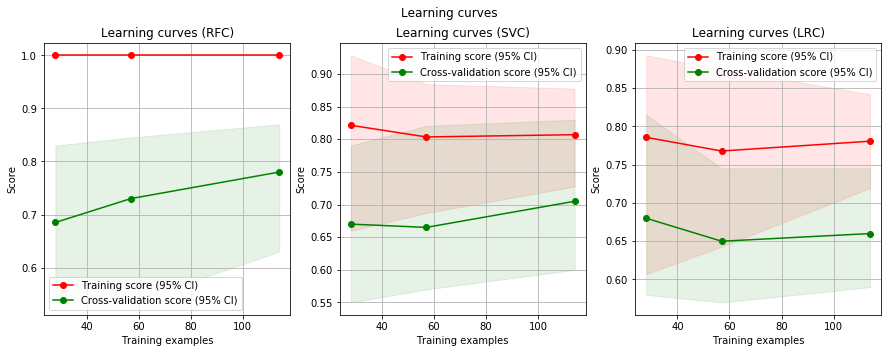

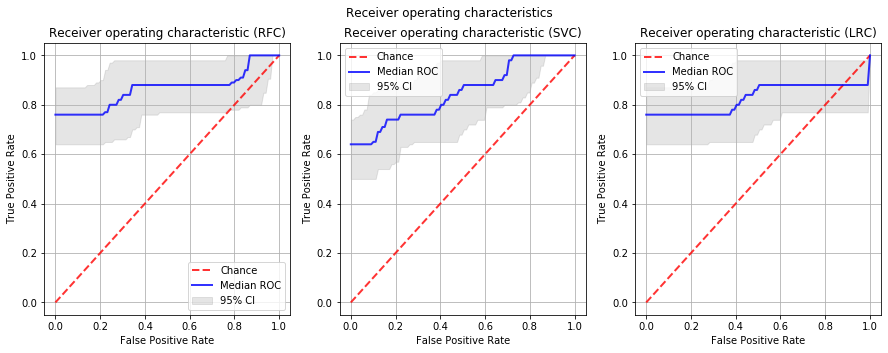

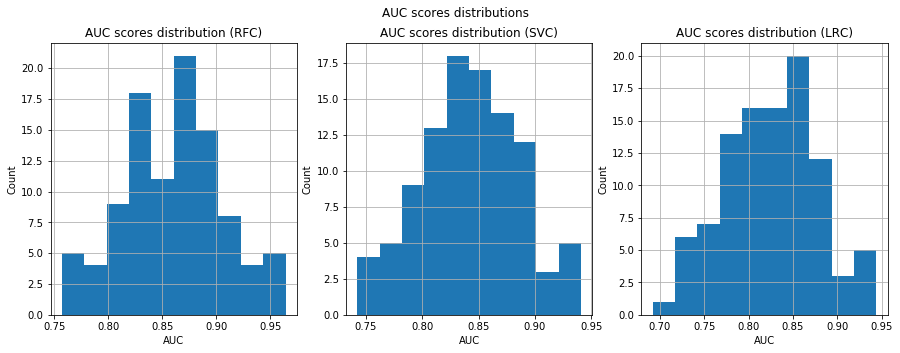

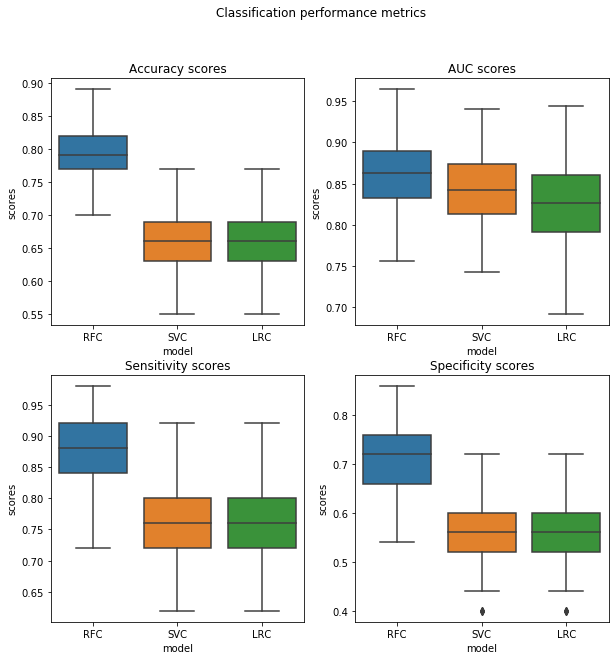

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.79 (0.71, 0.88)  0.66 (0.56, 0.76)  0.66 (0.56, 0.76)
AUC          0.86 (0.77, 0.95)  0.84 (0.76, 0.93)  0.83 (0.73, 0.94)
sensitivity  0.88 (0.77, 0.98)  0.76 (0.64, 0.87)  0.76 (0.64, 0.87)
specificity  0.72 (0.60, 0.81)  0.56 (0.40, 0.72)  0.56 (0.40, 0.72)

In [49]:
model_RFC_R2s_NAWM, model_SVC_R2s_NAWM, model_LRC_R2s_NAWM = classificationPipeline('R2s', 'NAWM', 100)

Features to model: ['R1_firstorder_Minimum', 'MT_firstorder_Kurtosis', 'PD_glcm_ClusterProminence']


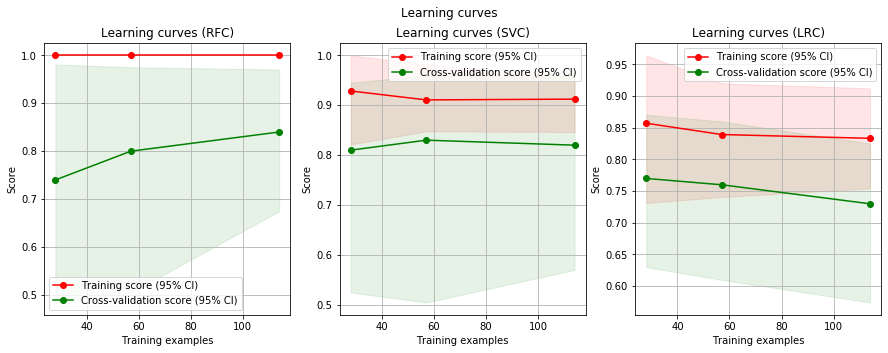

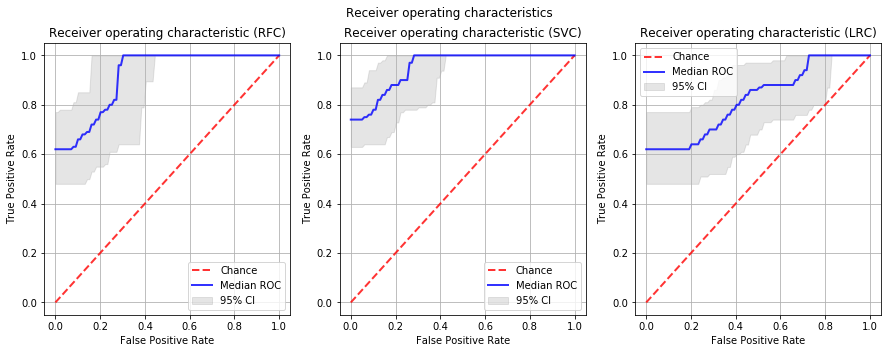

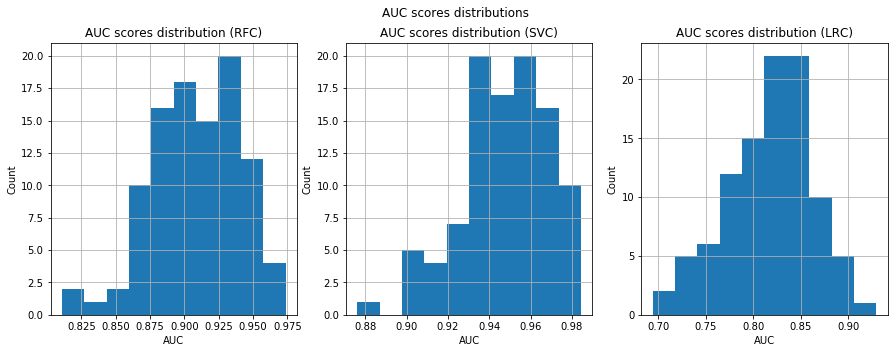

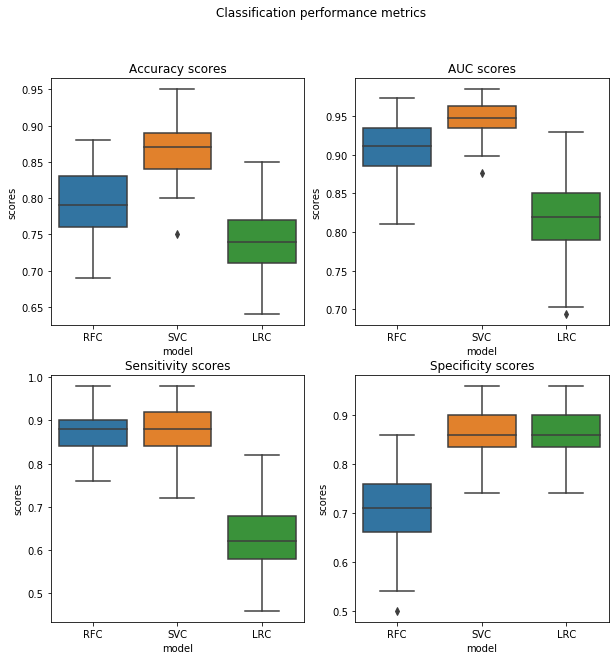

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.79 (0.71, 0.88)  0.87 (0.80, 0.93)  0.74 (0.67, 0.81)
AUC          0.91 (0.84, 0.96)  0.95 (0.91, 0.98)  0.82 (0.73, 0.90)
sensitivity  0.88 (0.78, 0.94)  0.88 (0.77, 0.98)  0.62 (0.48, 0.77)
specificity  0.71 (0.58, 0.84)  0.86 (0.77, 0.94)  0.86 (0.77, 0.94)

In [50]:
model_RFC_qMRI_NAWM, model_SVC_qMRI_NAWM, model_LRC_qMRI_NAWM = classificationPipeline('qMRI', 'NAWM', 100)

## Grey matter

Features to model: ['original_firstorder_10Percentile', 'original_firstorder_Skewness', 'original_firstorder_Kurtosis']


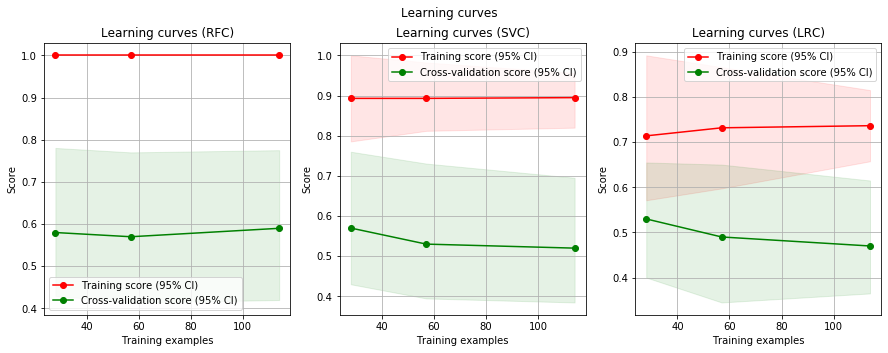

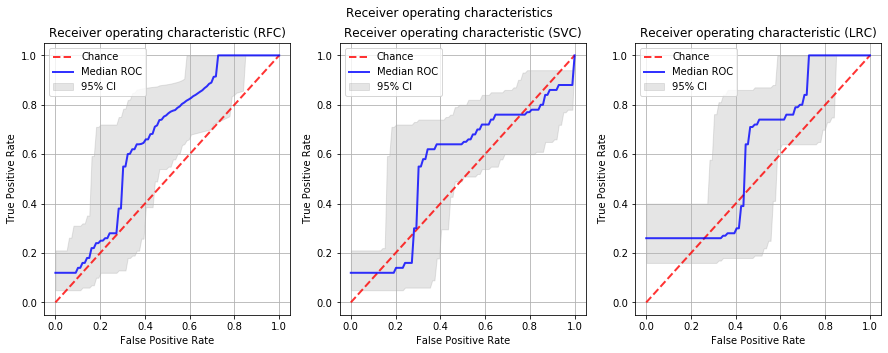

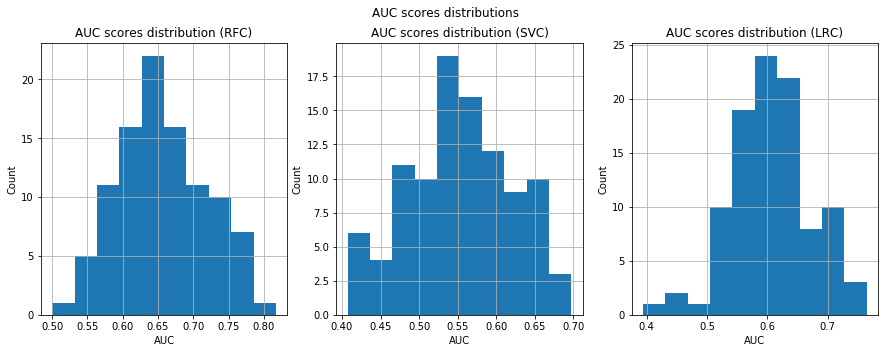

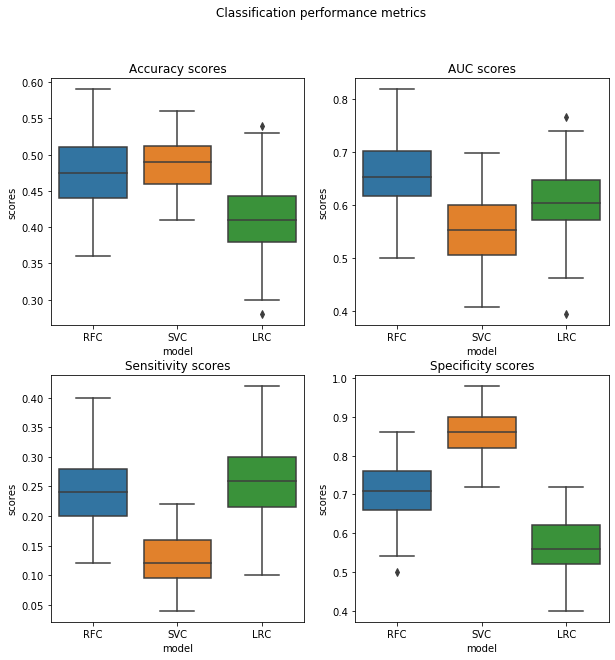

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.47 (0.38, 0.57)  0.49 (0.41, 0.55)  0.41 (0.32, 0.52)
AUC          0.65 (0.54, 0.77)  0.55 (0.42, 0.67)  0.60 (0.47, 0.73)
sensitivity  0.24 (0.12, 0.37)  0.12 (0.05, 0.21)  0.26 (0.16, 0.40)
specificity  0.71 (0.58, 0.84)  0.86 (0.75, 0.94)  0.56 (0.43, 0.71)

In [51]:
model_RFC_T1w_GM, model_SVC_T1w_GM, model_LRC_T1w_GM = classificationPipeline('T1w', 'GM', 100)

Features to model: ['original_firstorder_10Percentile', 'original_firstorder_InterquartileRange', 'original_firstorder_Skewness']


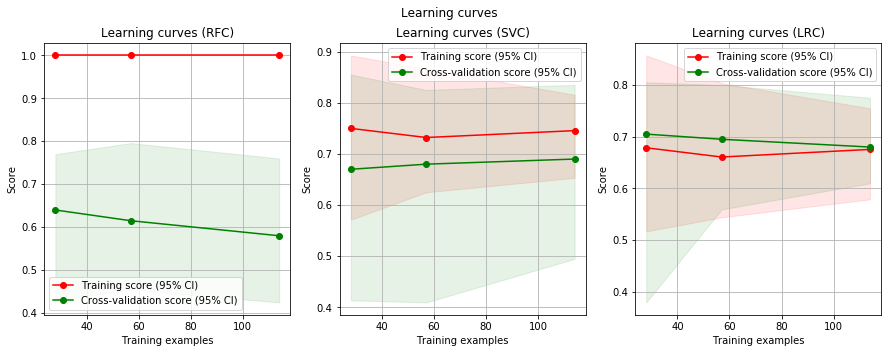

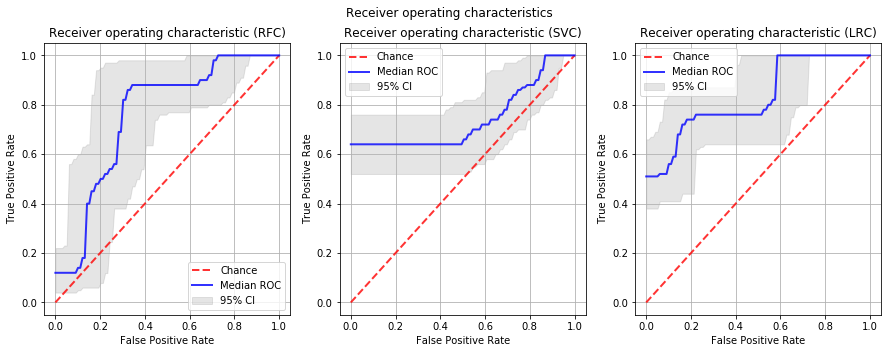

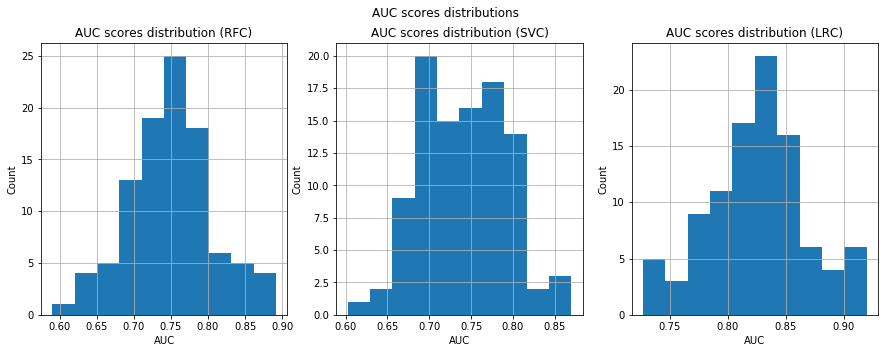

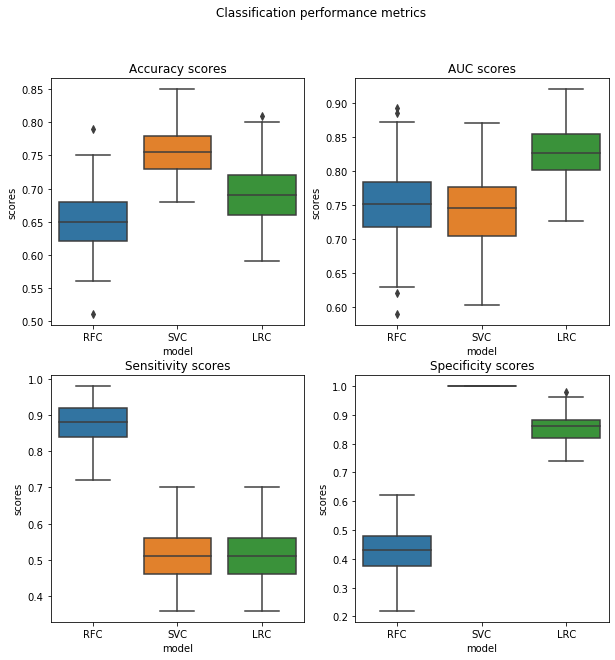

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.65 (0.57, 0.75)  0.76 (0.69, 0.83)  0.69 (0.61, 0.79)
AUC          0.75 (0.63, 0.87)  0.75 (0.65, 0.84)  0.83 (0.74, 0.91)
sensitivity  0.88 (0.77, 0.98)  0.51 (0.38, 0.66)  0.51 (0.38, 0.66)
specificity  0.43 (0.29, 0.54)  1.00 (1.00, 1.00)  0.86 (0.77, 0.94)

In [52]:
model_RFC_PD_GM, model_SVC_PD_GM, model_LRC_PD_GM = classificationPipeline('PD', 'GM', 100)

Features to model: ['original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_firstorder_90Percentile', 'original_glszm_LargeAreaHighGrayLevelEmphasis']


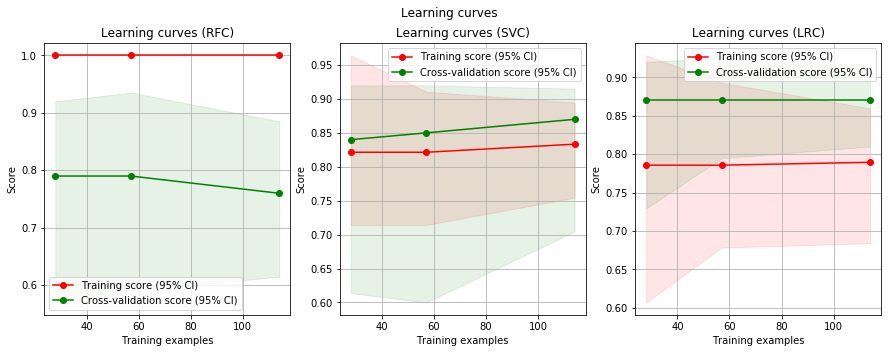

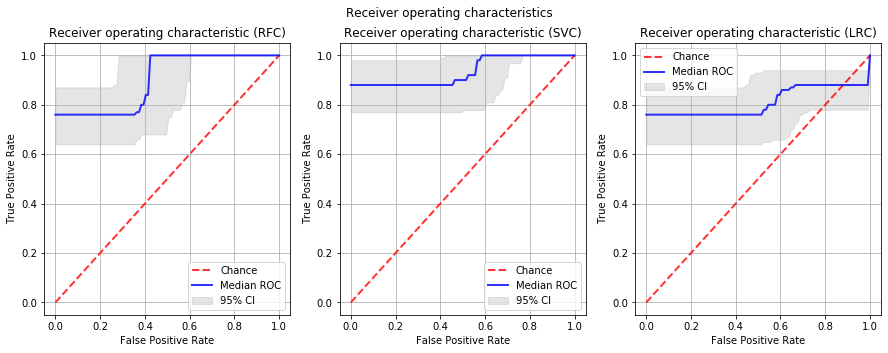

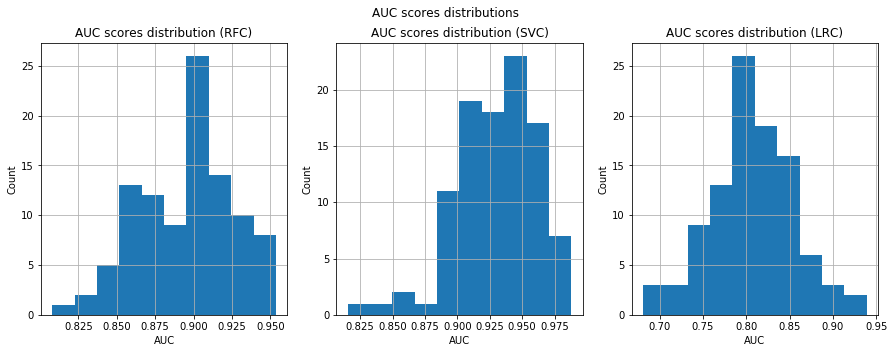

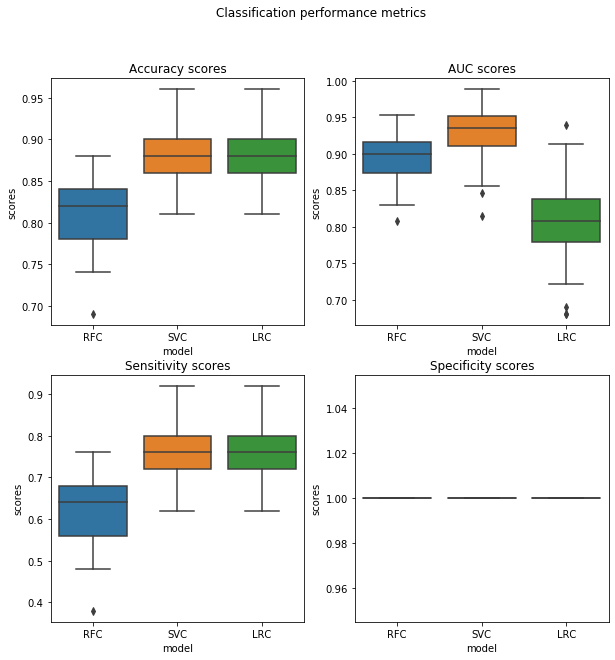

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.82 (0.75, 0.87)  0.88 (0.82, 0.94)  0.88 (0.82, 0.94)
AUC          0.90 (0.84, 0.95)  0.93 (0.86, 0.99)  0.81 (0.71, 0.90)
sensitivity  0.64 (0.50, 0.74)  0.76 (0.64, 0.87)  0.76 (0.64, 0.87)
specificity  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)

In [53]:
model_RFC_MT_GM, model_SVC_MT_GM, model_LRC_MT_GM = classificationPipeline('MT', 'GM', 100)

Features to model: ['original_firstorder_Minimum', 'original_firstorder_TotalEnergy', 'original_firstorder_10Percentile']


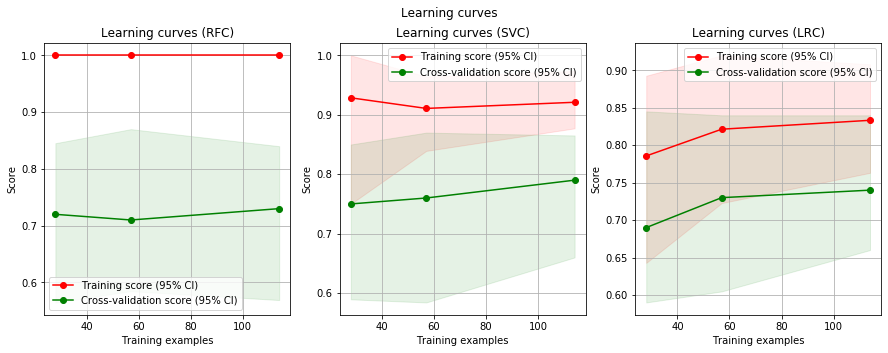

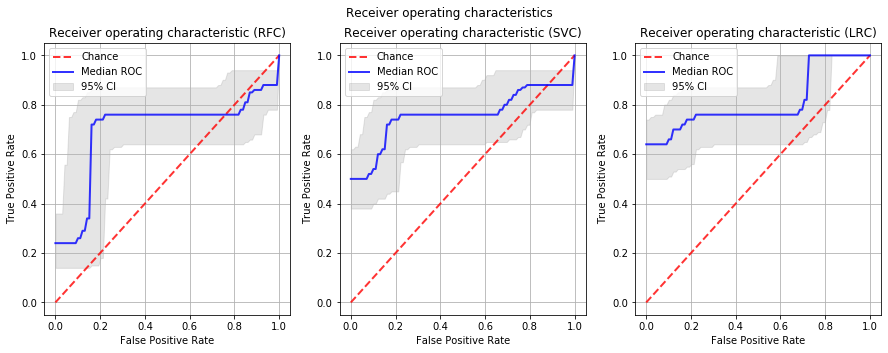

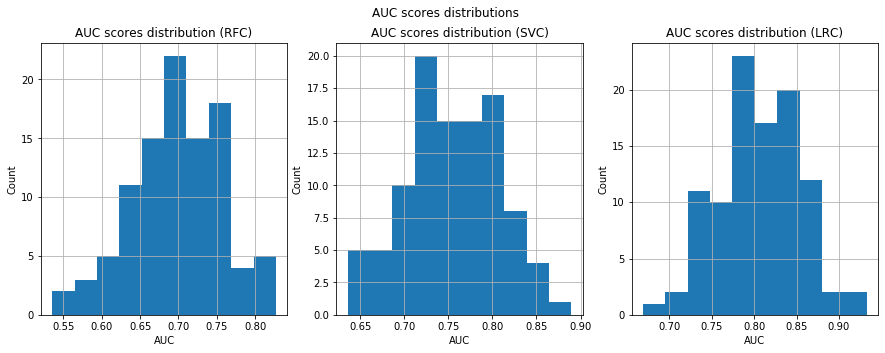

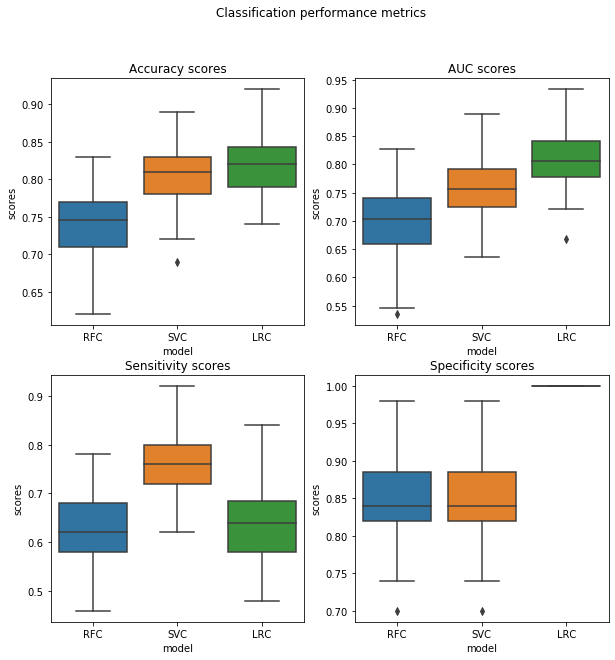

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.74 (0.66, 0.81)  0.81 (0.73, 0.88)  0.82 (0.75, 0.87)
AUC          0.70 (0.57, 0.81)  0.76 (0.64, 0.85)  0.81 (0.72, 0.88)
sensitivity  0.62 (0.52, 0.75)  0.76 (0.64, 0.87)  0.64 (0.50, 0.74)
specificity  0.84 (0.77, 0.95)  0.84 (0.77, 0.95)  1.00 (1.00, 1.00)

In [54]:
model_RFC_R1_GM, model_SVC_R1_GM, model_LRC_R1_GM = classificationPipeline('R1', 'GM', 100)

Features to model: ['original_gldm_LowGrayLevelEmphasis', 'original_firstorder_Median', 'original_firstorder_TotalEnergy']


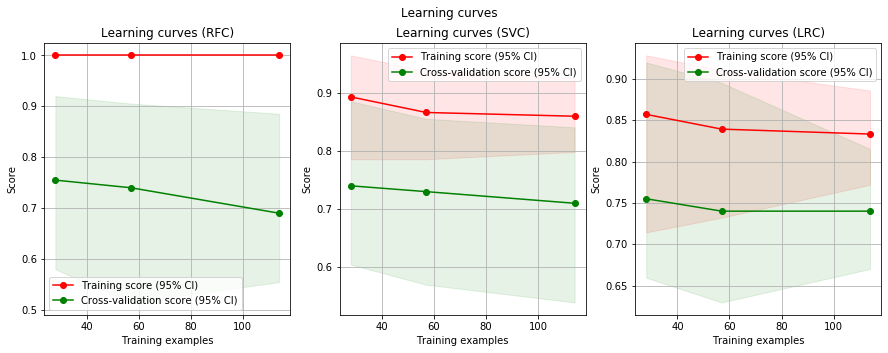

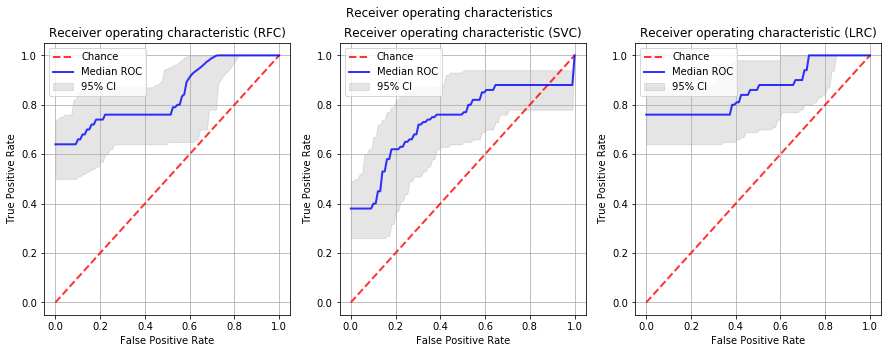

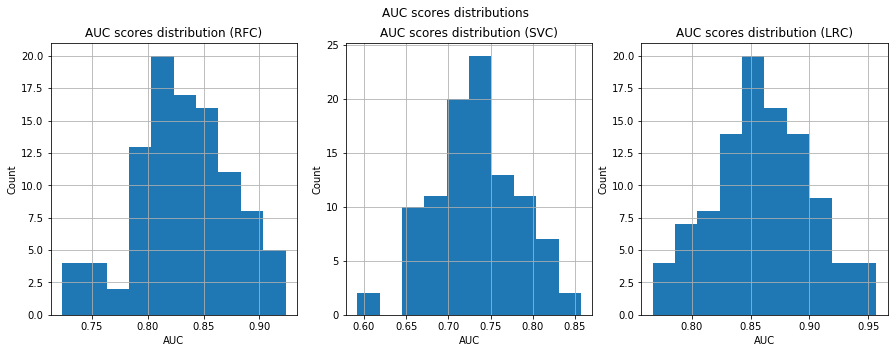

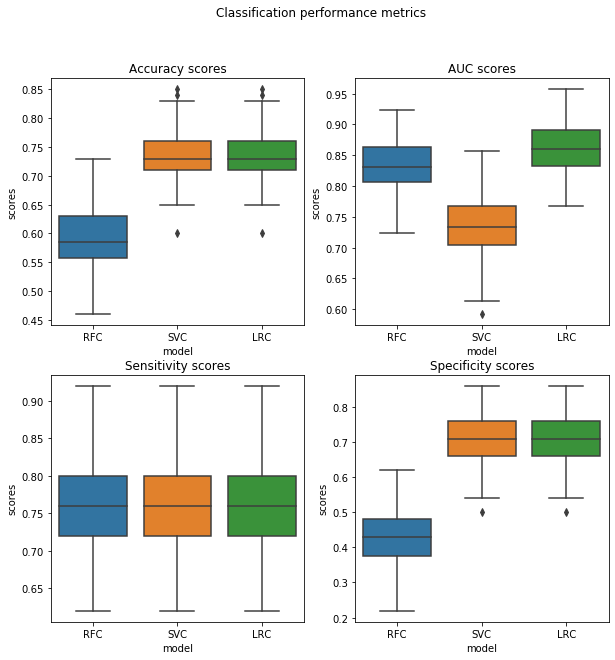

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.58 (0.48, 0.68)  0.73 (0.65, 0.83)  0.73 (0.65, 0.83)
AUC          0.83 (0.74, 0.91)  0.73 (0.65, 0.82)  0.86 (0.78, 0.95)
sensitivity  0.76 (0.64, 0.87)  0.76 (0.64, 0.87)  0.76 (0.64, 0.87)
specificity  0.43 (0.29, 0.54)  0.71 (0.58, 0.84)  0.71 (0.58, 0.84)

In [55]:
model_RFC_R2s_GM, model_SVC_R2s_GM, model_LRC_R2s_GM = classificationPipeline('R2s', 'GM', 100)

Features to model: ['R1_firstorder_Minimum', 'R1_firstorder_TotalEnergy', 'MT_gldm_SmallDependenceLowGrayLevelEmphasis']


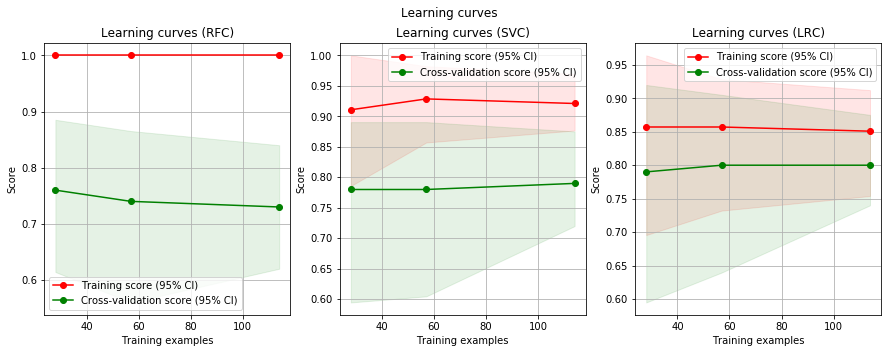

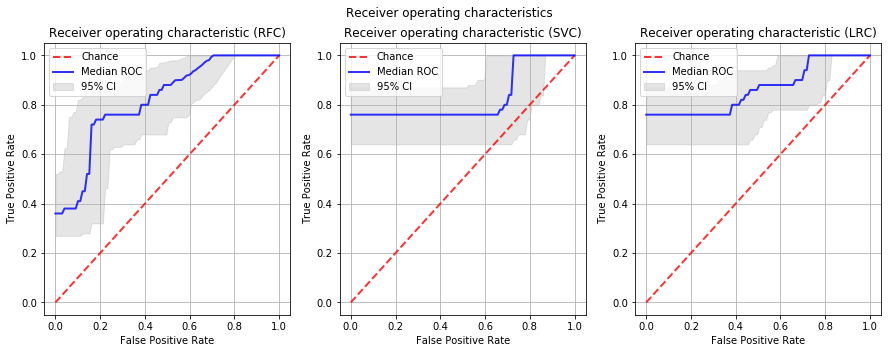

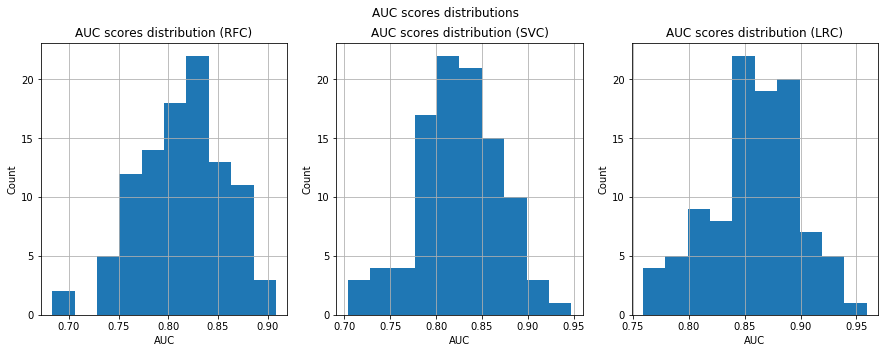

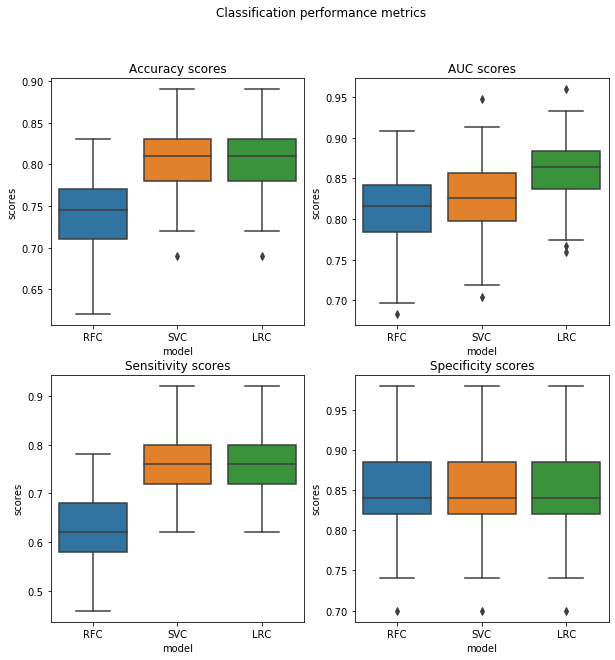

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.74 (0.66, 0.81)  0.81 (0.73, 0.88)  0.81 (0.73, 0.88)
AUC          0.82 (0.74, 0.89)  0.83 (0.73, 0.91)  0.86 (0.78, 0.93)
sensitivity  0.62 (0.52, 0.75)  0.76 (0.64, 0.87)  0.76 (0.64, 0.87)
specificity  0.84 (0.77, 0.95)  0.84 (0.77, 0.95)  0.84 (0.77, 0.95)

In [56]:
model_RFC_qMRI_GM, model_SVC_qMRI_GM, model_LRC_qMRI_GM = classificationPipeline('qMRI', 'GM', 100)

## Regression coefficients

In [57]:
print ('WM T1w: ', model_LRC_T1w_WM.coef_)
print ('WM PD: ', model_LRC_PD_WM.coef_)
print ('WM MT: ', model_LRC_MT_WM.coef_)
print ('WM R1: ', model_LRC_R1_WM.coef_)
print ('WM R2s: ', model_LRC_R2s_WM.coef_)
print ('WM qMRI: ', model_LRC_qMRI_WM.coef_)
print ('NAWM T1w: ', model_LRC_T1w_NAWM.coef_)
print ('NAWM PD: ', model_LRC_PD_NAWM.coef_)
print ('NAWM MT: ', model_LRC_MT_NAWM.coef_)
print ('NAWM R1: ', model_LRC_R1_NAWM.coef_)
print ('NAWM R2s: ', model_LRC_R2s_NAWM.coef_)
print ('NAWM qMRI: ', model_LRC_qMRI_NAWM.coef_)
print ('GM T1w: ', model_LRC_T1w_GM.coef_)
print ('GM PD: ', model_LRC_PD_GM.coef_)
print ('GM MT: ', model_LRC_MT_GM.coef_)
print ('GM R1: ', model_LRC_R1_GM.coef_)
print ('GM R2s: ', model_LRC_R2s_GM.coef_)
print ('GM qMRI: ', model_LRC_qMRI_GM.coef_)

WM T1w:  [[-1.47718153  2.59667219 -0.85246602]]
WM PD:  [[ 2.53718314 -3.22015231  2.7345865 ]]
WM MT:  [[-2.80174761  1.4198698   2.46118085]]
WM R1:  [[ 2.6844983  -2.31225968  2.51263994]]
WM R2s:  [[-1.36964725 -2.18103749 -0.315707  ]]
WM qMRI:  [[-2.57664498  2.55077121 -2.39050481]]
NAWM T1w:  [[-0.90383097  1.5330599   2.15768717]]
NAWM PD:  [[-2.9891113   2.34756699  1.91013323]]
NAWM MT:  [[-1.87930192  1.60219702 -1.15724868]]
NAWM R1:  [[-3.03645147 -0.69411281  2.2771456 ]]
NAWM R2s:  [[-2.01972909 -0.94084113 -0.65891473]]
NAWM qMRI:  [[-2.11214775 -1.47300678  3.23379527]]
GM T1w:  [[-2.7500275   0.79583978 -0.78646721]]
GM PD:  [[-0.89519434  1.42562508  0.15981217]]
GM MT:  [[ 2.32695847 -1.85744863 -0.01174804]]
GM R1:  [[-0.94392645 -1.91957481 -1.33275998]]
GM R2s:  [[ 2.10804906 -1.45236701 -1.60858426]]
GM qMRI:  [[-1.05899899 -2.29378015  2.70636515]]


# Models validation on external data

In [58]:
f = open('../results/names/ds2_names.txt', 'r')
ds2_names = f.read().split('\n')
f.close()

f = open('../results/names/ds3_names.txt', 'r')
ds3_names = f.read().split('\n')
f.close()

ds2_names = ds2_names[:-1]
ds3_names = ds3_names[:-1]

WM

Features to model: ['original_glcm_ClusterShade', 'original_firstorder_Range', 'original_glszm_SmallAreaEmphasis']


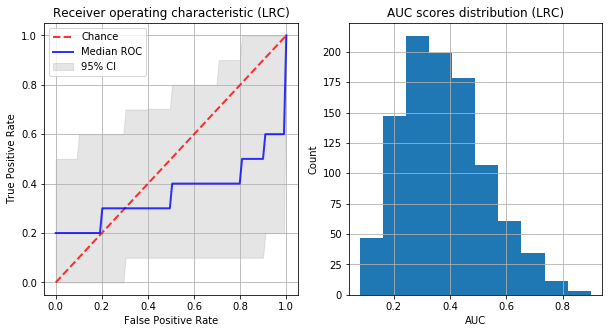

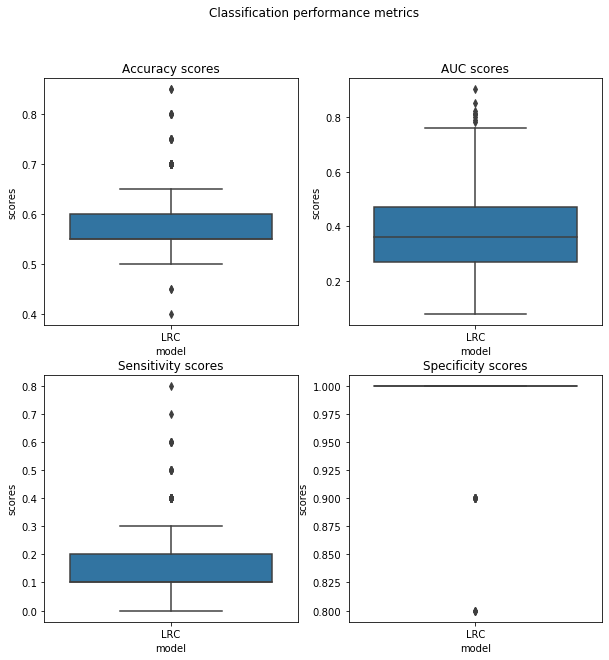

Performance metrics comparison


LRC
score                         
accuracy     0.55 (0.50, 0.70)
AUC          0.36 (0.12, 0.70)
sensitivity  0.10 (0.00, 0.40)
specificity  1.00 (1.00, 1.00)

In [86]:
y_true_WM = []
y_pred_WM = []
y_score_WM = []

with open('../results/features_to_model/features_to_model_T1w_WM.txt', "r") as f:
    features_to_model=[i[:-1] for line in f for i in line.split('/n')]   
    
print ('Features to model:', features_to_model)

ds_valid_2 = pd.read_csv('../results/features/features_CC359_T1w_WM.csv')
ds_valid_2.set_index('sub', inplace = True)
ds_valid_2 = ds_valid_2.reindex(ds2_names)
ds_valid_2['outcome'] = 0

ds_valid_3 = pd.read_csv('../results/features/features_MSSEG_T1w_WM.csv')
ds_valid_3.set_index('sub', inplace = True)
ds_valid_3 = ds_valid_3.reindex(ds3_names)
ds_valid_3['outcome'] = 1

ds_valid = ds_valid_2.append(ds_valid_3)

# initializing lists of perfromance metrics
acc_scores_LRC = []
auc_scores_LRC = []
sens_scores_LRC = []
spec_scores_LRC = []
tprs_LRC = []

mean_fpr = np.linspace(0, 1, 100)
n_splits = 1000

# classification models testing with bootstrap
for i in range (0, n_splits):
    
    # generation of test subsample
    r = np.random.RandomState(i)
    subs_valid_0 = r.choice(ds_valid.loc[ds_valid.outcome == 0].index.values, 10)
    subs_valid_1 = r.choice(ds_valid.loc[ds_valid.outcome == 1].index.values, 10)
    subs_valid = np.concatenate((subs_valid_0, subs_valid_1), axis = None)
    ds_valid_set = ds_valid.reindex(subs_valid)

    X_valid = ds_valid_set[features_to_model]
    y_valid = ds_valid_set.outcome
    X_valid_s = MinMaxScaler().fit_transform(X_valid)

    # prediction and calculation of performance metrics for current bootstrap step
    modelPerformance(model_LRC_T1w_WM, 'LRC', X_valid_s, y_valid, 
                     acc_scores_LRC, auc_scores_LRC, sens_scores_LRC, spec_scores_LRC, tprs_LRC, mean_fpr, 
                     y_true_WM, y_pred_WM, y_score_WM)

    
# graphs    
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.grid()
plotROC(mean_fpr, tprs_LRC)
plt.title('Receiver operating characteristic (LRC)')

plt.subplot(1, 2, 2)
plt.grid()
plotAUCdist(auc_scores_LRC)
plt.title('AUC scores distribution (LRC)')

plt.show()


# performance metrics to csv files
df_acc_scores=pd.DataFrame({'model': 'LRC', 'scores': acc_scores_LRC})
df_auc_scores=pd.DataFrame({'model': 'LRC', 'scores': auc_scores_LRC})
df_sens_scores=pd.DataFrame({'model': 'LRC', 'scores': sens_scores_LRC})
df_spec_scores=pd.DataFrame({'model': 'LRC', 'scores': spec_scores_LRC})
    
df_acc_scores['metric'] = 'accuracy'
df_auc_scores['metric'] = 'AUC'
df_sens_scores['metric'] = 'sensitivity'
df_spec_scores['metric'] = 'specificity'

df_acc_scores['modality_name'] = 'T1w'
df_auc_scores['modality_name'] = 'T1w'
df_sens_scores['modality_name'] = 'T1w'
df_spec_scores['modality_name'] = 'T1w'

df_acc_scores['roi_name'] = 'WM'
df_auc_scores['roi_name'] = 'WM'
df_sens_scores['roi_name'] = 'WM'
df_spec_scores['roi_name'] = 'WM'
    
df_acc_scores.to_csv('../results/performance/performance_acc_CC359-MSSEG_T1w_WM.csv')
df_auc_scores.to_csv('../results/performance/performance_auc_CC359-MSSEG_T1w_WM.csv')
df_sens_scores.to_csv('../results/performance/performance_sens_CC359-MSSEG_T1w_WM.csv')
df_spec_scores.to_csv('../results/performance/performance_spec_CC359-MSSEG_T1w_WM.csv')

# comparison of performance metrics (boxplot)
plt.figure(figsize = (10, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='model', y='scores', data=df_acc_scores)
plt.title('Accuracy scores')

plt.subplot(2, 2, 2)
sns.boxplot(x='model', y='scores', data=df_auc_scores)
plt.title('AUC scores')

plt.subplot(2, 2, 3)
sns.boxplot(x='model', y='scores', data=df_sens_scores)
plt.title('Sensitivity scores')

plt.subplot(2, 2, 4)
sns.boxplot(x='model', y='scores', data=df_spec_scores)
plt.title('Specificity scores')

plt.suptitle('Classification performance metrics')
plt.show()

# comparison of performance metrics
rec_acc = {'score': 'accuracy',
           'LRC': '%.2f (%.2f, %.2f)' % (np.median(acc_scores_LRC), 
                                         np.percentile(acc_scores_LRC, 2.5), np.percentile(acc_scores_LRC, 97.5))
          }
rec_auc = {'score': 'AUC', 
           'LRC': '%.2f (%.2f, %.2f)' % (np.median(auc_scores_LRC), 
                                         np.percentile(auc_scores_LRC, 2.5), np.percentile(auc_scores_LRC, 97.5))
          }
rec_sens = {'score': 'sensitivity',
            'LRC': '%.2f (%.2f, %.2f)' % (np.median(sens_scores_LRC), 
                                          np.percentile(sens_scores_LRC, 2.5), np.percentile(sens_scores_LRC, 97.5))
           }
rec_spec = {'score': 'specificity',
            'LRC': '%.2f (%.2f, %.2f)' % (np.median(spec_scores_LRC),
                                          np.percentile(spec_scores_LRC, 2.5), np.percentile(spec_scores_LRC, 97.5))
           }

df_performance = pd.DataFrame([rec_acc, rec_auc, rec_sens, rec_spec], columns = ['score', 'LRC'])
df_performance.set_index('score', inplace = True)

print ('Performance metrics comparison')
display (df_performance)

In [60]:
#y_true_WM = sum(y_true_WM, [])
#y_pred_WM = sum(y_pred_WM, [])
#y_score_WM = sum(y_score_WM, [])

with open('../results/outcomes/ys_true_LRC_T1w_WM_validation.txt', 'w') as output:
    for y in y_true_WM:
        output.write(str(y) + '\n')
with open('../results/outcomes/ys_pred_LRC_T1w_WM_validation.txt', 'w') as output:
    for y in y_pred_WM:
        output.write(str(y) + '\n')
with open('../results/outcomes/ys_score_LRC_T1w_WM_validation.txt', 'w') as output:
    for y in y_score_WM:
        output.write(str(y) + '\n')

Features to model: ['original_glcm_ClusterShade', 'original_firstorder_Variance', 'original_firstorder_90Percentile']


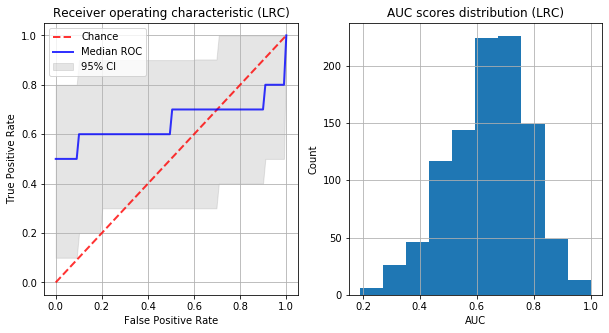

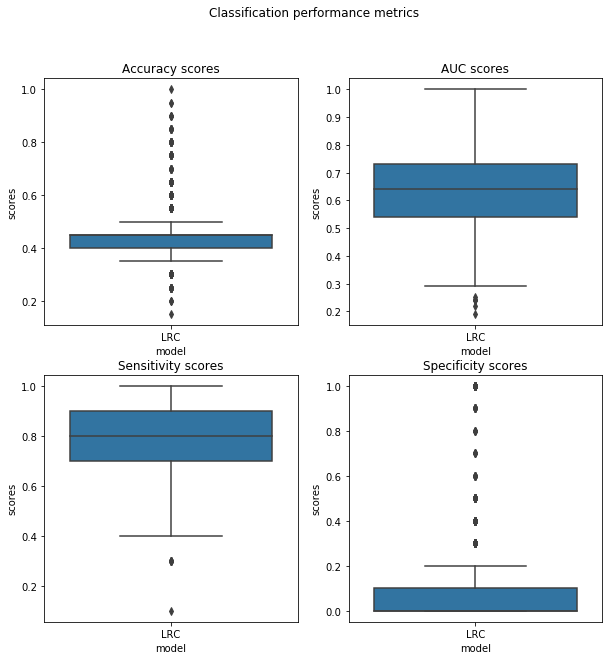

Performance metrics comparison


LRC
score                         
accuracy     0.45 (0.30, 0.80)
AUC          0.64 (0.34, 0.90)
sensitivity  0.80 (0.50, 0.90)
specificity  0.00 (0.00, 1.00)

In [87]:
y_true_NAWM = []
y_pred_NAWM = []
y_score_NAWM = []

with open('../results/features_to_model/features_to_model_T1w_NAWM.txt', "r") as f:
    features_to_model=[i[:-1] for line in f for i in line.split('/n')]

features_to_model = features_to_model[:3]    
    
print ('Features to model:', features_to_model)

ds_valid_2 = pd.read_csv('../results/features/features_CC359_T1w_NAWM.csv')
ds_valid_2.set_index('sub', inplace = True)
ds_valid_2 = ds_valid_2.reindex(ds2_names)
ds_valid_2['outcome'] = 0

ds_valid_3 = pd.read_csv('../results/features/features_MSSEG_T1w_NAWM.csv')
ds_valid_3.set_index('sub', inplace = True)
ds_valid_3 = ds_valid_3.reindex(ds3_names)
ds_valid_3['outcome'] = 1

ds_valid = ds_valid_2.append(ds_valid_3)

# initializing lists of perfromance metrics
acc_scores_LRC = []
auc_scores_LRC = []
sens_scores_LRC = []
spec_scores_LRC = []
tprs_LRC = []

mean_fpr = np.linspace(0, 1, 100)
n_splits = 1000

# classification models testing with bootstrap
for i in range (0, n_splits):
    
    # generation of test subsample
    r = np.random.RandomState(i)
    subs_valid_0 = r.choice(ds_valid.loc[ds_valid.outcome == 0].index.values, 10)
    subs_valid_1 = r.choice(ds_valid.loc[ds_valid.outcome == 1].index.values, 10)
    subs_valid = np.concatenate((subs_valid_0, subs_valid_1), axis = None)
    ds_valid_set = ds_valid.reindex(subs_valid)

    X_valid = ds_valid_set[features_to_model]
    y_valid = ds_valid_set.outcome
    X_valid_s = MinMaxScaler().fit_transform(X_valid)

    # prediction and calculation of performance metrics for current bootstrap step
    modelPerformance(model_LRC_T1w_NAWM, 'LRC', X_valid_s, y_valid, 
                     acc_scores_LRC, auc_scores_LRC, sens_scores_LRC, spec_scores_LRC, tprs_LRC, mean_fpr, 
                     y_true_NAWM, y_pred_NAWM, y_score_NAWM)
    
# graphs    
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.grid()
plotROC(mean_fpr, tprs_LRC)
plt.title('Receiver operating characteristic (LRC)')

plt.subplot(1, 2, 2)
plt.grid()
plotAUCdist(auc_scores_LRC)
plt.title('AUC scores distribution (LRC)')

plt.show()

# performance metrics to csv files
df_acc_scores=pd.DataFrame({'model': 'LRC', 'scores': acc_scores_LRC})
df_auc_scores=pd.DataFrame({'model': 'LRC', 'scores': auc_scores_LRC})
df_sens_scores=pd.DataFrame({'model': 'LRC', 'scores': sens_scores_LRC})
df_spec_scores=pd.DataFrame({'model': 'LRC', 'scores': spec_scores_LRC})
    
df_acc_scores['metric'] = 'accuracy'
df_auc_scores['metric'] = 'AUC'
df_sens_scores['metric'] = 'sensitivity'
df_spec_scores['metric'] = 'specificity'

df_acc_scores['modality_name'] = 'T1w'
df_auc_scores['modality_name'] = 'T1w'
df_sens_scores['modality_name'] = 'T1w'
df_spec_scores['modality_name'] = 'T1w'

df_acc_scores['roi_name'] = 'NAWM'
df_auc_scores['roi_name'] = 'NAWM'
df_sens_scores['roi_name'] = 'NAWM'
df_spec_scores['roi_name'] = 'NAWM'
    
df_acc_scores.to_csv('../results/performance/performance_acc_CC359-MSSEG_T1w_NAWM.csv')
df_auc_scores.to_csv('../results/performance/performance_auc_CC359-MSSEG_T1w_NAWM.csv')
df_sens_scores.to_csv('../results/performance/performance_sens_CC359-MSSEG_T1w_NAWM.csv')
df_spec_scores.to_csv('../results/performance/performance_spec_CC359-MSSEG_T1w_NAWM.csv')

# comparison of performance metrics (boxplot)
plt.figure(figsize = (10, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='model', y='scores', data=df_acc_scores)
plt.title('Accuracy scores')

plt.subplot(2, 2, 2)
sns.boxplot(x='model', y='scores', data=df_auc_scores)
plt.title('AUC scores')

plt.subplot(2, 2, 3)
sns.boxplot(x='model', y='scores', data=df_sens_scores)
plt.title('Sensitivity scores')

plt.subplot(2, 2, 4)
sns.boxplot(x='model', y='scores', data=df_spec_scores)
plt.title('Specificity scores')

plt.suptitle('Classification performance metrics')
plt.show()

# comparison of performance metrics
rec_acc = {'score': 'accuracy',
           'LRC': '%.2f (%.2f, %.2f)' % (np.median(acc_scores_LRC), 
                                         np.percentile(acc_scores_LRC, 2.5), np.percentile(acc_scores_LRC, 97.5))
          }
rec_auc = {'score': 'AUC', 
           'LRC': '%.2f (%.2f, %.2f)' % (np.median(auc_scores_LRC), 
                                         np.percentile(auc_scores_LRC, 2.5), np.percentile(auc_scores_LRC, 97.5))
          }
rec_sens = {'score': 'sensitivity',
            'LRC': '%.2f (%.2f, %.2f)' % (np.median(sens_scores_LRC), 
                                          np.percentile(sens_scores_LRC, 2.5), np.percentile(sens_scores_LRC, 97.5))
           }
rec_spec = {'score': 'specificity',
            'LRC': '%.2f (%.2f, %.2f)' % (np.median(spec_scores_LRC),
                                          np.percentile(spec_scores_LRC, 2.5), np.percentile(spec_scores_LRC, 97.5))
           }

df_performance = pd.DataFrame([rec_acc, rec_auc, rec_sens, rec_spec], columns = ['score', 'LRC'])
df_performance.set_index('score', inplace = True)

print ('Performance metrics comparison')
display (df_performance)

In [62]:
y_true_NAWM = sum(y_true_NAWM, [])
y_pred_NAWM = sum(y_pred_NAWM, [])
y_score_NAWM = sum(y_score_NAWM, [])

with open('../results/outcomes/ys_true_LRC_T1w_NAWM_validation.txt', 'w') as output:
    for y in y_true_NAWM:
        output.write(str(y) + '\n')
with open('../results/outcomes/ys_pred_LRC_T1w_NAWM_validation.txt', 'w') as output:
    for y in y_pred_NAWM:
        output.write(str(y) + '\n')
with open('../results/outcomes/ys_score_LRC_T1w_NAWM_validation.txt', 'w') as output:
    for y in y_score_NAWM:
        output.write(str(y) + '\n')

Features to model: ['original_firstorder_10Percentile', 'original_firstorder_Skewness', 'original_firstorder_Kurtosis']


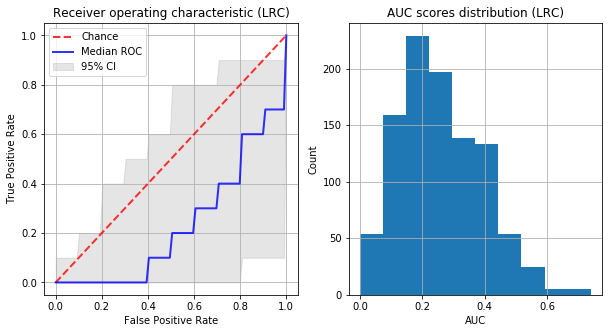

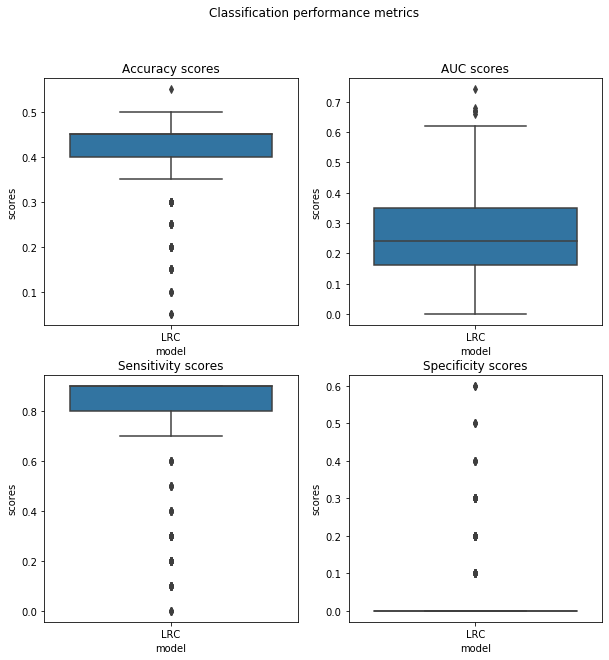

Performance metrics comparison


LRC
score                         
accuracy     0.45 (0.15, 0.45)
AUC          0.24 (0.05, 0.56)
sensitivity  0.90 (0.10, 0.90)
specificity  0.00 (0.00, 0.30)

In [63]:
y_true_GM = []
y_pred_GM = []
y_score_GM = []

with open('../results/features_to_model/features_to_model_T1w_GM.txt', "r") as f:
    features_to_model=[i[:-1] for line in f for i in line.split('/n')]
    
print ('Features to model:', features_to_model)

ds_valid_2 = pd.read_csv('../results/features/features_CC359_T1w_GM.csv')
ds_valid_2.set_index('sub', inplace = True)
ds_valid_2 = ds_valid_2.reindex(ds2_names)
ds_valid_2['outcome'] = 0

ds_valid_3 = pd.read_csv('../results/features/features_MSSEG_T1w_GM.csv')
ds_valid_3.set_index('sub', inplace = True)
ds_valid_3 = ds_valid_3.reindex(ds3_names)
ds_valid_3['outcome'] = 1

ds_valid = ds_valid_2.append(ds_valid_3)

# initializing lists of perfromance metrics
acc_scores_LRC = []
auc_scores_LRC = []
sens_scores_LRC = []
spec_scores_LRC = []
tprs_LRC = []

mean_fpr = np.linspace(0, 1, 100)
n_splits = 1000

# classification models testing with bootstrap
for i in range (0, n_splits):
    
    # generation of test subsample
    r = np.random.RandomState(i)
    subs_valid_0 = r.choice(ds_valid.loc[ds_valid.outcome == 0].index.values, 10)
    subs_valid_1 = r.choice(ds_valid.loc[ds_valid.outcome == 1].index.values, 10)
    subs_valid = np.concatenate((subs_valid_0, subs_valid_1), axis = None)
    ds_valid_set = ds_valid.reindex(subs_valid)

    X_valid = ds_valid_set[features_to_model]
    y_valid = ds_valid_set.outcome
    X_valid_s = MinMaxScaler().fit_transform(X_valid)

    # prediction and calculation of performance metrics for current bootstrap step
    modelPerformance(model_LRC_T1w_GM, 'LRC', X_valid_s, y_valid, 
                     acc_scores_LRC, auc_scores_LRC, sens_scores_LRC, spec_scores_LRC, tprs_LRC, mean_fpr, 
                     y_true_GM, y_pred_GM, y_score_GM)

    
# graphs    
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.grid()
plotROC(mean_fpr, tprs_LRC)
plt.title('Receiver operating characteristic (LRC)')

plt.subplot(1, 2, 2)
plt.grid()
plotAUCdist(auc_scores_LRC)
plt.title('AUC scores distribution (LRC)')

plt.show()


# performance metrics to csv files
df_acc_scores=pd.DataFrame({'model': 'LRC', 'scores': acc_scores_LRC})
df_auc_scores=pd.DataFrame({'model': 'LRC', 'scores': auc_scores_LRC})
df_sens_scores=pd.DataFrame({'model': 'LRC', 'scores': sens_scores_LRC})
df_spec_scores=pd.DataFrame({'model': 'LRC', 'scores': spec_scores_LRC})
    
df_acc_scores['metric'] = 'accuracy'
df_auc_scores['metric'] = 'AUC'
df_sens_scores['metric'] = 'sensitivity'
df_spec_scores['metric'] = 'specificity'

df_acc_scores['modality_name'] = 'T1w'
df_auc_scores['modality_name'] = 'T1w'
df_sens_scores['modality_name'] = 'T1w'
df_spec_scores['modality_name'] = 'T1w'

df_acc_scores['roi_name'] = 'GM'
df_auc_scores['roi_name'] = 'GM'
df_sens_scores['roi_name'] = 'GM'
df_spec_scores['roi_name'] = 'GM'
    
df_acc_scores.to_csv('../results/performance/performance_acc_CC359-MSSEG_T1w_GM.csv')
df_auc_scores.to_csv('../results/performance/performance_auc_CC359-MSSEG_T1w_GM.csv')
df_sens_scores.to_csv('../results/performance/performance_sens_CC359-MSSEG_T1w_GM.csv')
df_spec_scores.to_csv('../results/performance/performance_spec_CC359-MSSEG_T1w_GM.csv')

# comparison of performance metrics (boxplot)
plt.figure(figsize = (10, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='model', y='scores', data=df_acc_scores)
plt.title('Accuracy scores')

plt.subplot(2, 2, 2)
sns.boxplot(x='model', y='scores', data=df_auc_scores)
plt.title('AUC scores')

plt.subplot(2, 2, 3)
sns.boxplot(x='model', y='scores', data=df_sens_scores)
plt.title('Sensitivity scores')

plt.subplot(2, 2, 4)
sns.boxplot(x='model', y='scores', data=df_spec_scores)
plt.title('Specificity scores')

plt.suptitle('Classification performance metrics')
plt.show()

# comparison of performance metrics
rec_acc = {'score': 'accuracy',
           'LRC': '%.2f (%.2f, %.2f)' % (np.median(acc_scores_LRC), 
                                         np.percentile(acc_scores_LRC, 2.5), np.percentile(acc_scores_LRC, 97.5))
          }
rec_auc = {'score': 'AUC', 
           'LRC': '%.2f (%.2f, %.2f)' % (np.median(auc_scores_LRC), 
                                         np.percentile(auc_scores_LRC, 2.5), np.percentile(auc_scores_LRC, 97.5))
          }
rec_sens = {'score': 'sensitivity',
            'LRC': '%.2f (%.2f, %.2f)' % (np.median(sens_scores_LRC), 
                                          np.percentile(sens_scores_LRC, 2.5), np.percentile(sens_scores_LRC, 97.5))
           }
rec_spec = {'score': 'specificity',
            'LRC': '%.2f (%.2f, %.2f)' % (np.median(spec_scores_LRC),
                                          np.percentile(spec_scores_LRC, 2.5), np.percentile(spec_scores_LRC, 97.5))
           }

df_performance = pd.DataFrame([rec_acc, rec_auc, rec_sens, rec_spec], columns = ['score', 'LRC'])
df_performance.set_index('score', inplace = True)

print ('Performance metrics comparison')
display (df_performance)

In [64]:
y_true_GM = sum(y_true_GM, [])
y_pred_GM = sum(y_pred_GM, [])
y_score_GM = sum(y_score_GM, [])

with open('../results/outcomes/ys_true_LRC_T1w_GM_validation.txt', 'w') as output:
    for y in y_true_GM:
        output.write(str(y) + '\n')
with open('../results/outcomes/ys_pred_LRC_T1w_GM_validation.txt', 'w') as output:
    for y in y_pred_GM:
        output.write(str(y) + '\n')
with open('../results/outcomes/ys_score_LRC_T1w_GM_validation.txt', 'w') as output:
    for y in y_score_GM:
        output.write(str(y) + '\n')

# Permutation test on development dataset

Features to model: ['original_glrlm_RunLengthNonUniformity', 'original_ngtdm_Complexity', 'original_firstorder_90Percentile']


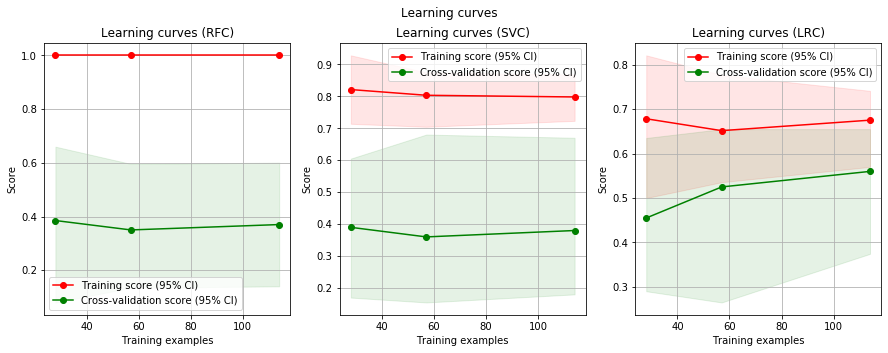

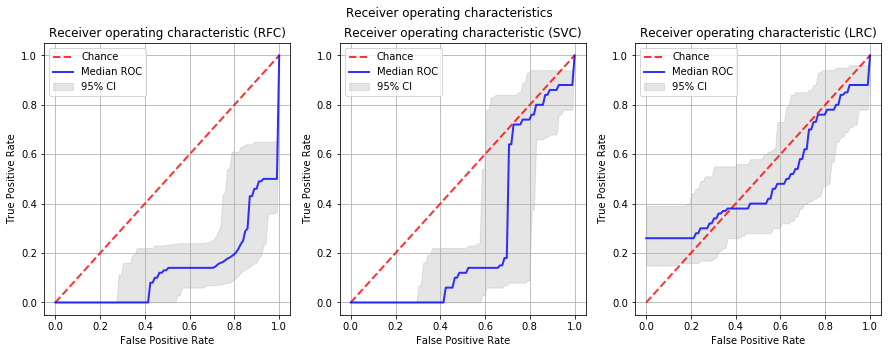

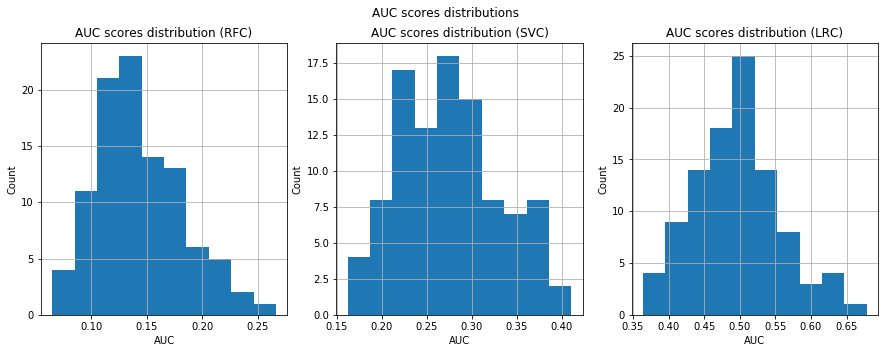

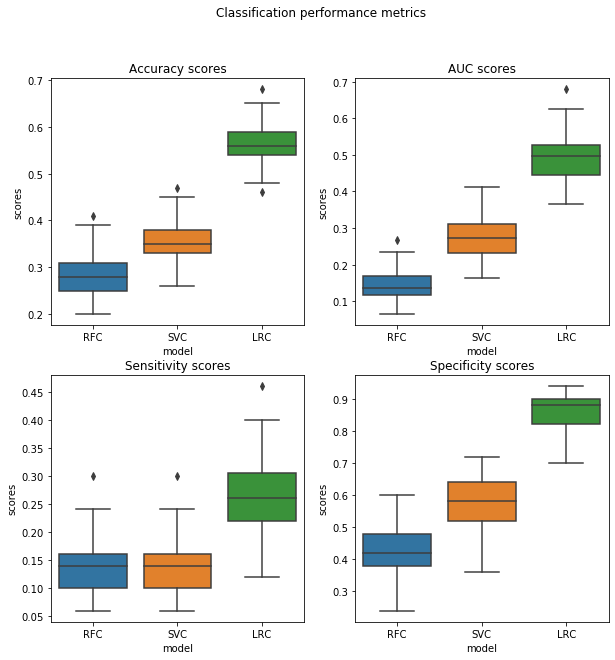

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.28 (0.21, 0.38)  0.35 (0.27, 0.45)  0.56 (0.48, 0.63)
AUC          0.14 (0.08, 0.23)  0.27 (0.18, 0.38)  0.50 (0.39, 0.62)
sensitivity  0.14 (0.06, 0.24)  0.14 (0.06, 0.24)  0.26 (0.15, 0.39)
specificity  0.42 (0.32, 0.57)  0.58 (0.41, 0.70)  0.88 (0.76, 0.94)

In [65]:
model_RFC_T1w_WM, model_SVC_T1w_WM, model_LRC_T1w_WM = classificationPipeline('T1w', 'WM', 100, pt = True)

Features to model: ['original_glcm_MCC', 'original_firstorder_Median', 'original_ngtdm_Strength']


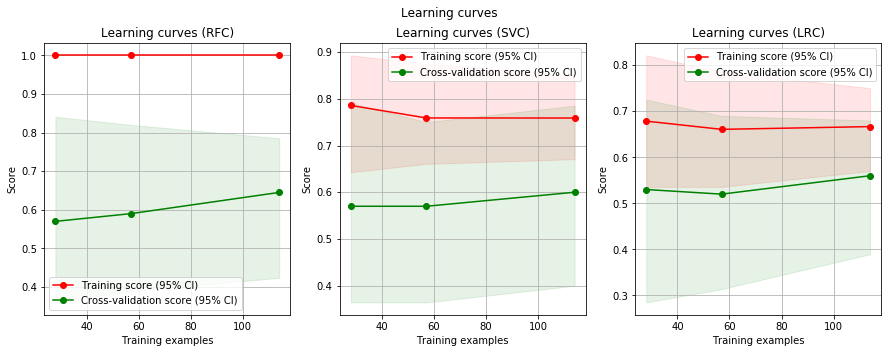

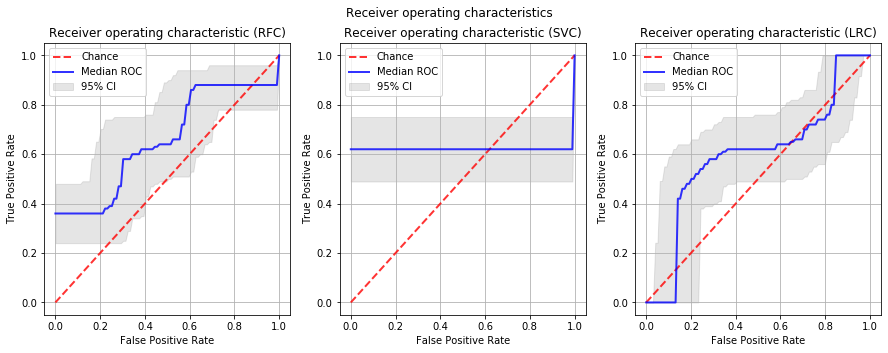

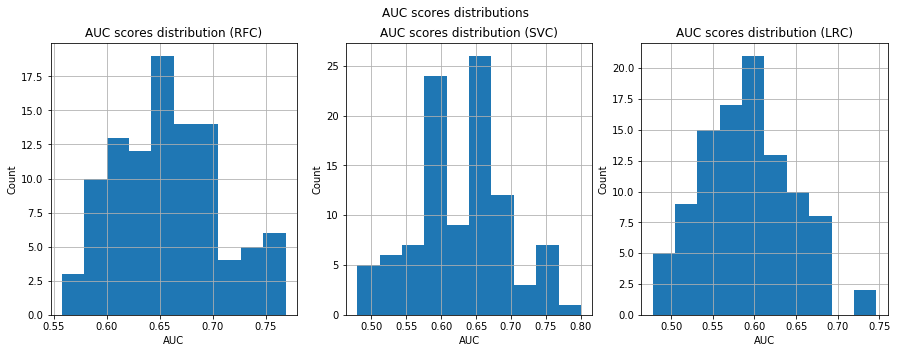

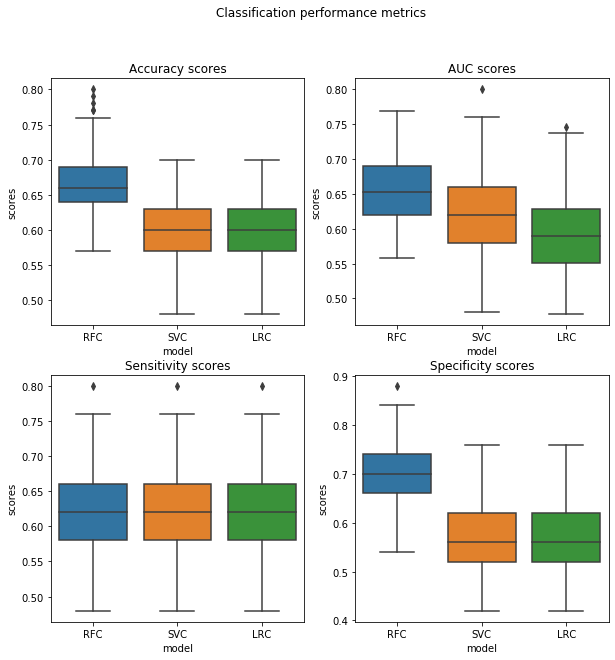

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.66 (0.57, 0.78)  0.60 (0.51, 0.69)  0.60 (0.51, 0.69)
AUC          0.65 (0.58, 0.76)  0.62 (0.49, 0.75)  0.59 (0.49, 0.69)
sensitivity  0.62 (0.49, 0.75)  0.62 (0.49, 0.75)  0.62 (0.49, 0.75)
specificity  0.70 (0.57, 0.83)  0.56 (0.45, 0.70)  0.56 (0.45, 0.70)

In [66]:
model_RFC_PD_WM, model_SVC_PD_WM, model_LRC_PD_WM = classificationPipeline('PD', 'WM', 100, pt = True)

Features to model: ['original_firstorder_90Percentile', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_glcm_MCC']


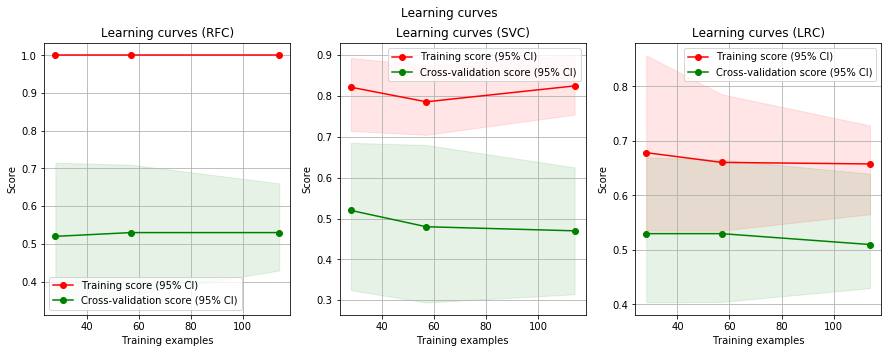

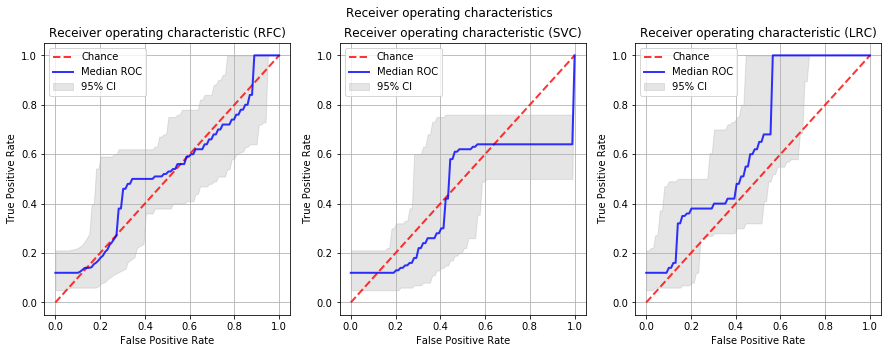

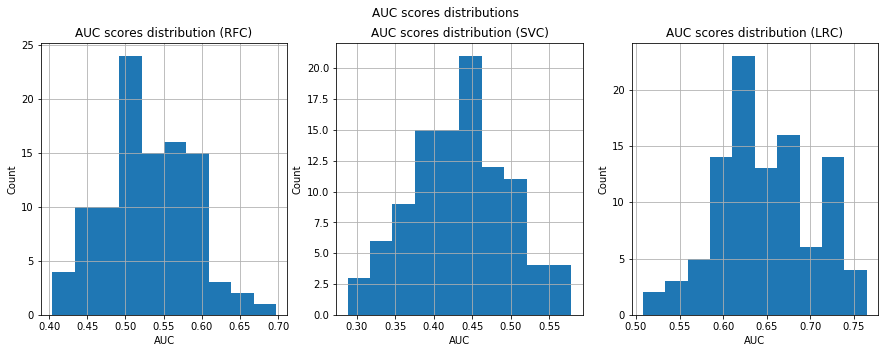

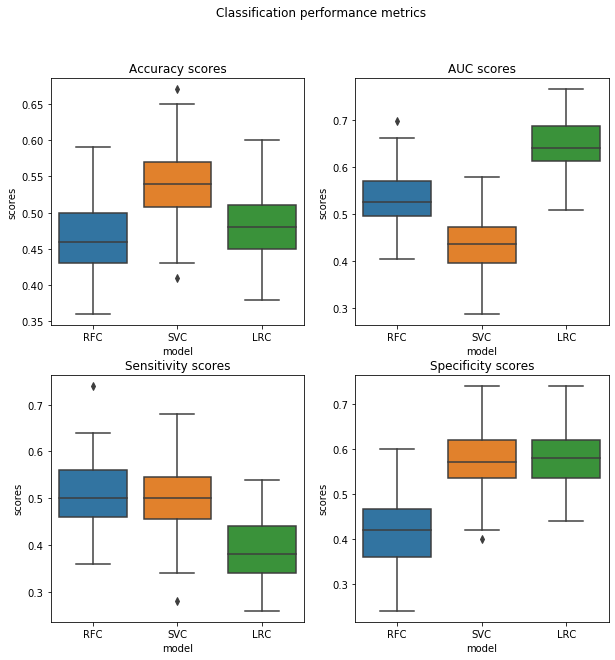

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.46 (0.38, 0.56)  0.54 (0.44, 0.64)  0.48 (0.40, 0.58)
AUC          0.53 (0.42, 0.64)  0.44 (0.31, 0.56)  0.64 (0.55, 0.74)
sensitivity  0.50 (0.38, 0.62)  0.50 (0.38, 0.64)  0.38 (0.28, 0.50)
specificity  0.42 (0.30, 0.56)  0.57 (0.43, 0.72)  0.58 (0.45, 0.71)

In [67]:
model_RFC_MT_WM, model_SVC_MT_WM, model_LRC_MT_WM = classificationPipeline('MT', 'WM', 100, pt = True)

Features to model: ['original_firstorder_90Percentile', 'original_ngtdm_Strength', 'original_firstorder_TotalEnergy']


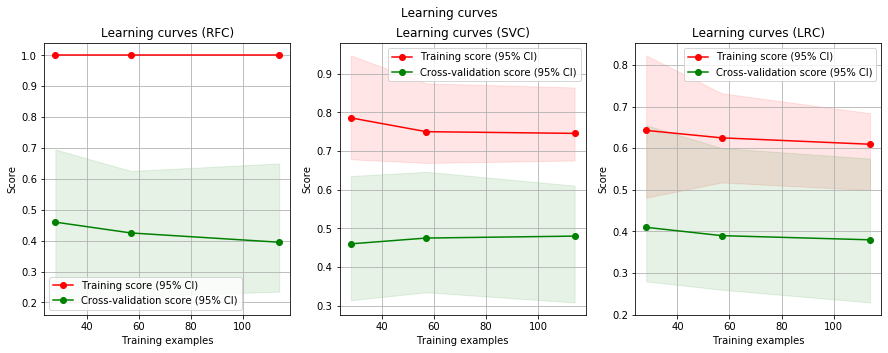

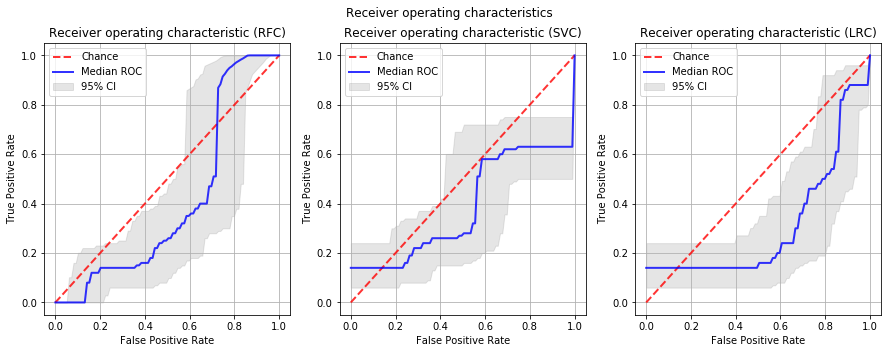

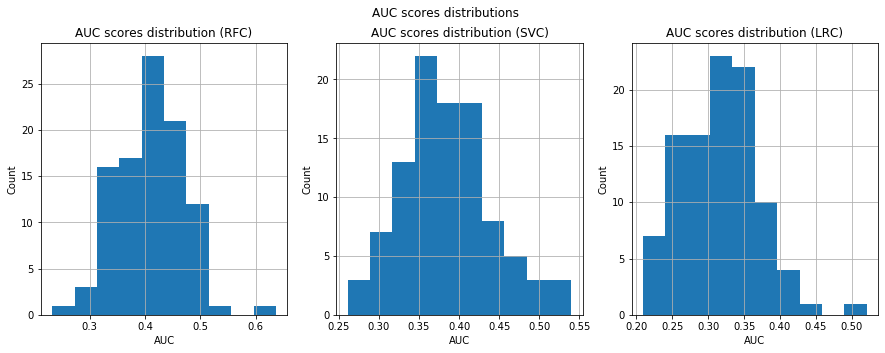

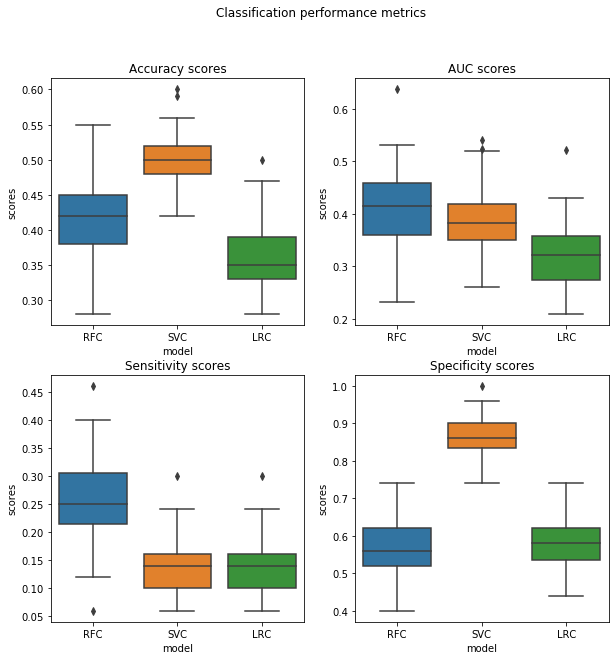

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.42 (0.33, 0.51)  0.50 (0.43, 0.56)  0.35 (0.29, 0.43)
AUC          0.41 (0.30, 0.51)  0.38 (0.29, 0.52)  0.32 (0.22, 0.41)
sensitivity  0.25 (0.13, 0.39)  0.14 (0.06, 0.24)  0.14 (0.06, 0.24)
specificity  0.56 (0.43, 0.72)  0.86 (0.77, 0.94)  0.58 (0.45, 0.72)

In [68]:
model_RFC_R1_WM, model_SVC_R1_WM, model_LRC_R1_WM = classificationPipeline('R1', 'WM', 100, pt = True)

Features to model: ['original_glszm_HighGrayLevelZoneEmphasis', 'original_ngtdm_Busyness', 'original_firstorder_Variance']


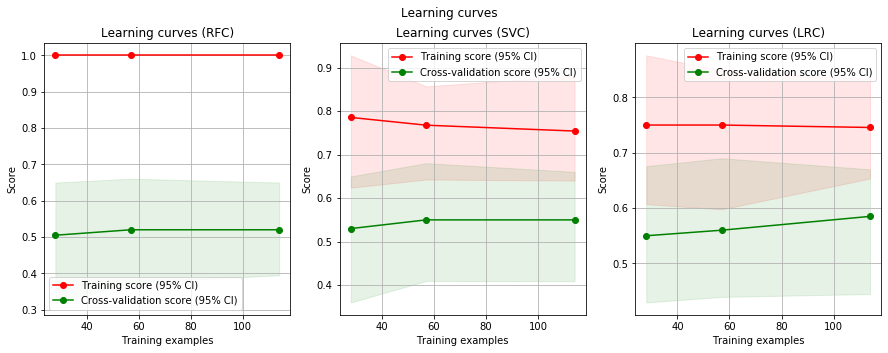

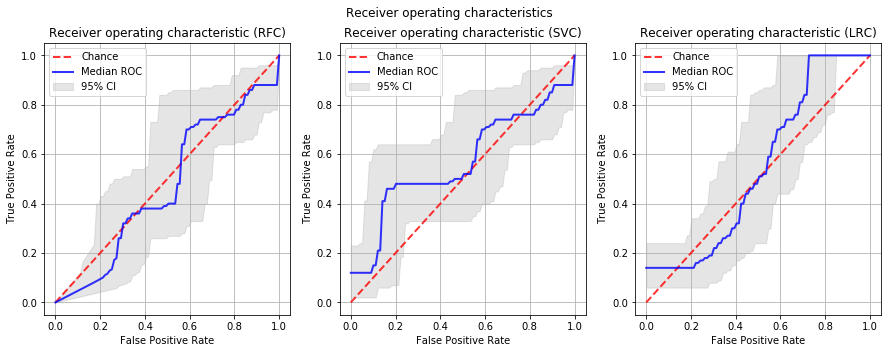

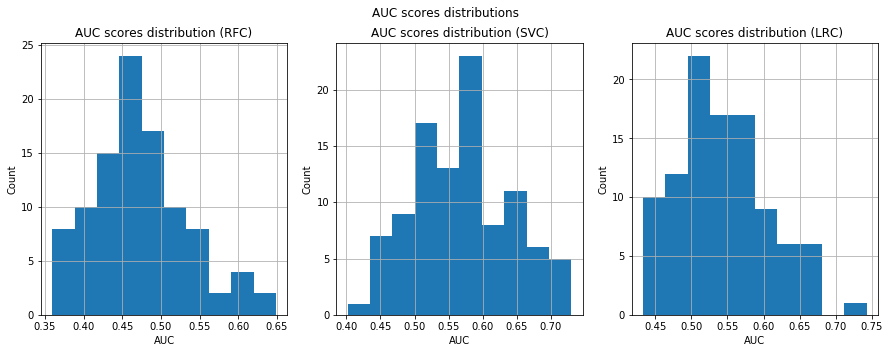

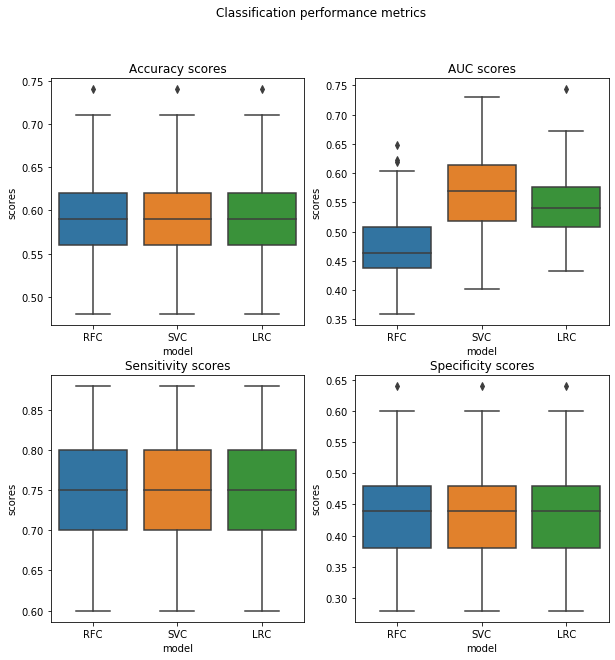

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.59 (0.51, 0.71)  0.59 (0.51, 0.71)  0.59 (0.51, 0.71)
AUC          0.46 (0.38, 0.61)  0.57 (0.45, 0.70)  0.54 (0.44, 0.67)
sensitivity  0.75 (0.64, 0.87)  0.75 (0.64, 0.87)  0.75 (0.64, 0.87)
specificity  0.44 (0.31, 0.58)  0.44 (0.31, 0.58)  0.44 (0.31, 0.58)

In [69]:
model_RFC_R2s_WM, model_SVC_R2s_WM, model_LRC_R2s_WM = classificationPipeline('R2s', 'WM', 100, pt = True)

Features to model: ['MT_glszm_SizeZoneNonUniformityNormalized', 'MT_firstorder_Range', 'R1_firstorder_Maximum']


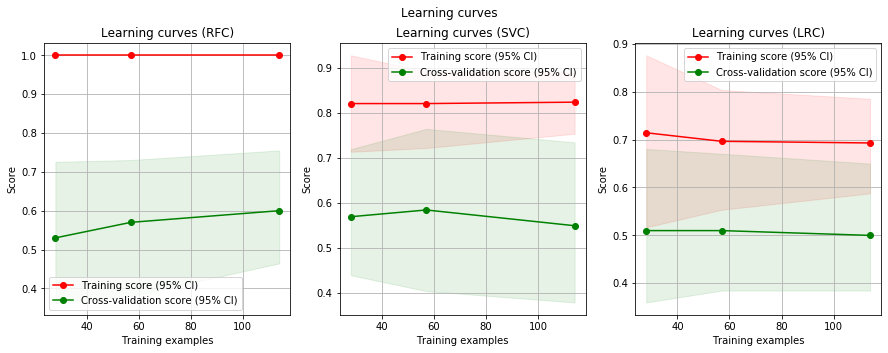

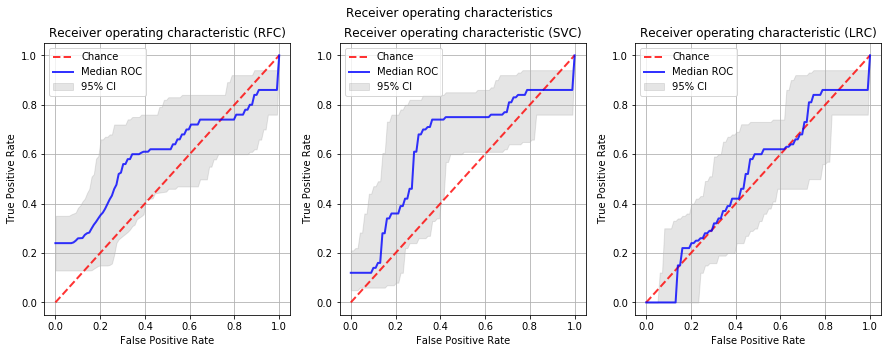

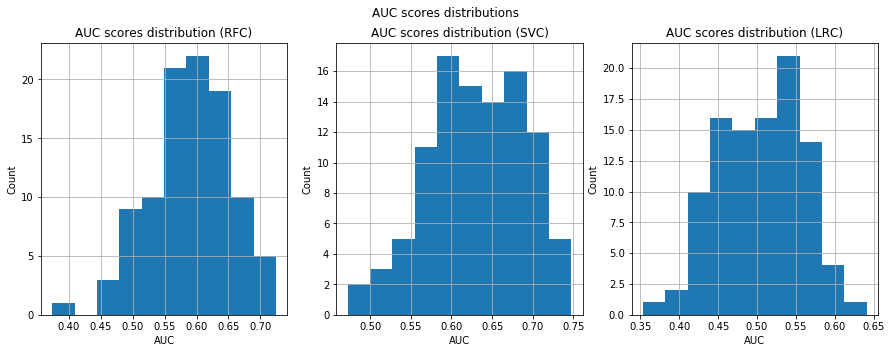

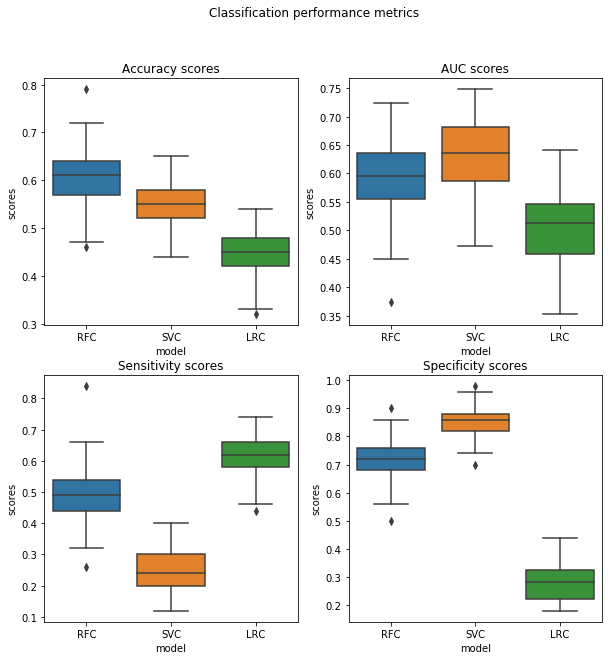

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.61 (0.47, 0.69)  0.55 (0.47, 0.64)  0.45 (0.35, 0.52)
AUC          0.60 (0.47, 0.70)  0.64 (0.52, 0.73)  0.51 (0.41, 0.60)
sensitivity  0.49 (0.34, 0.63)  0.24 (0.14, 0.38)  0.62 (0.46, 0.73)
specificity  0.72 (0.58, 0.85)  0.86 (0.75, 0.95)  0.28 (0.18, 0.38)

In [70]:
model_RFC_qMRI_WM, model_SVC_qMRI_WM, model_LRC_qMRI_WM = classificationPipeline('qMRI', 'WM', 100, pt = True)

Features to model: ['original_glrlm_RunLengthNonUniformity', 'original_firstorder_TotalEnergy', 'original_gldm_DependenceEntropy']


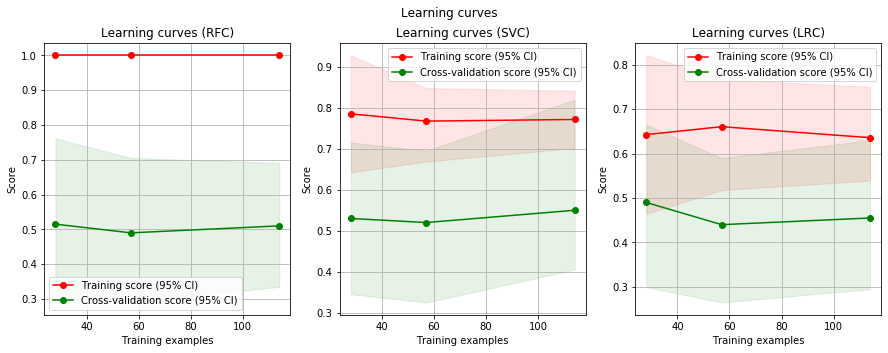

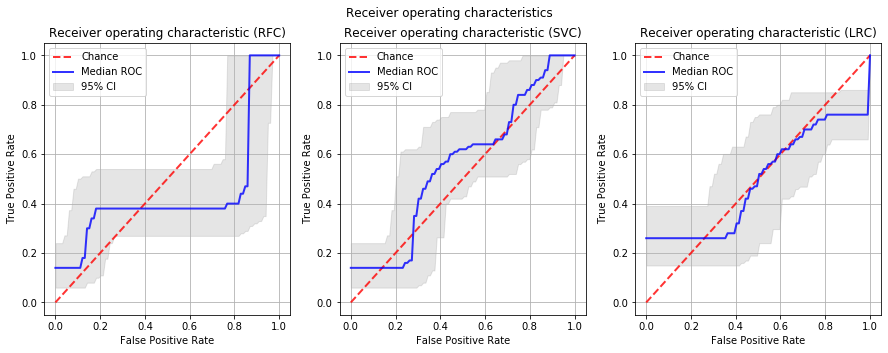

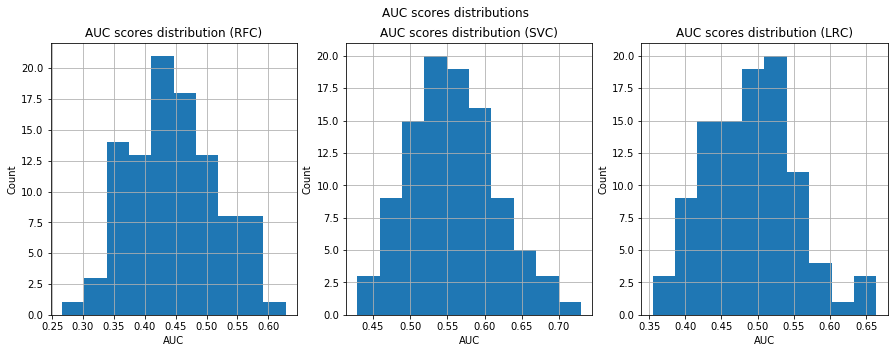

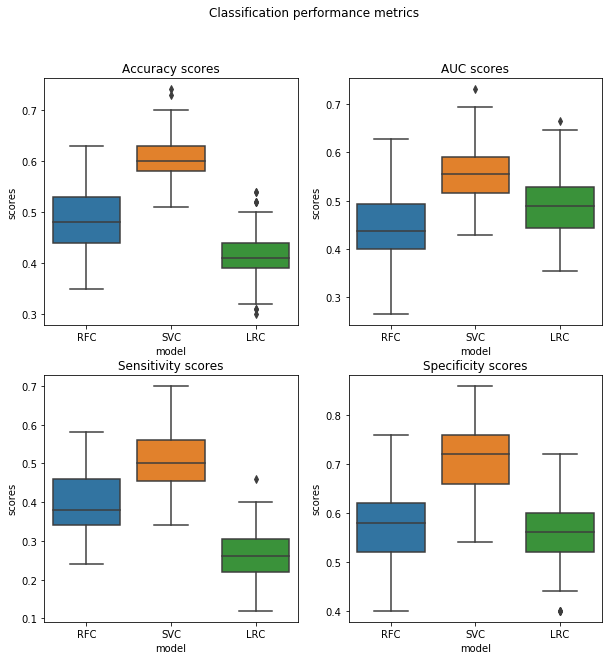

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.48 (0.38, 0.59)  0.60 (0.54, 0.70)  0.41 (0.31, 0.52)
AUC          0.44 (0.32, 0.58)  0.56 (0.46, 0.68)  0.49 (0.38, 0.62)
sensitivity  0.38 (0.27, 0.54)  0.50 (0.40, 0.65)  0.26 (0.15, 0.39)
specificity  0.58 (0.41, 0.73)  0.72 (0.60, 0.81)  0.56 (0.40, 0.72)

In [71]:
model_RFC_T1w_NAWM, model_SVC_T1w_NAWM, model_LRC_T1w_NAWM = classificationPipeline('T1w', 'NAWM', 100, pt = True)

Features to model: ['original_firstorder_Skewness', 'original_firstorder_Minimum', 'original_firstorder_Mean']


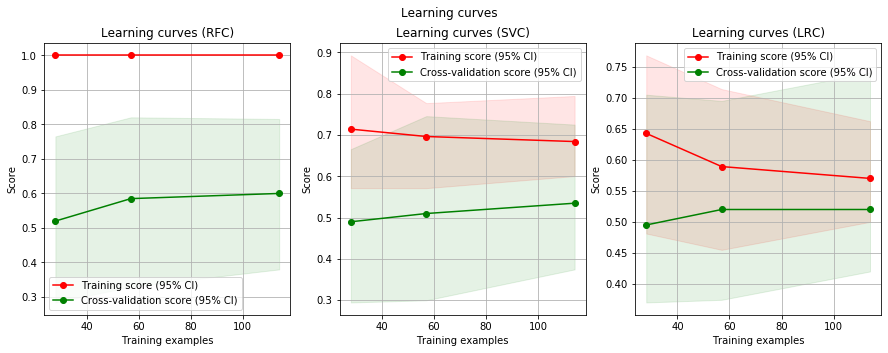

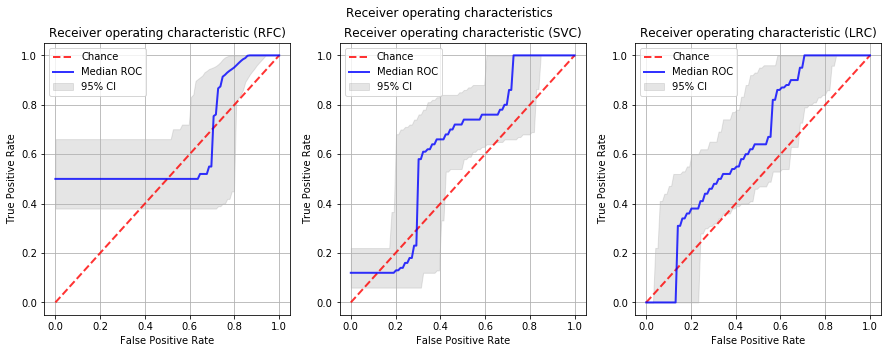

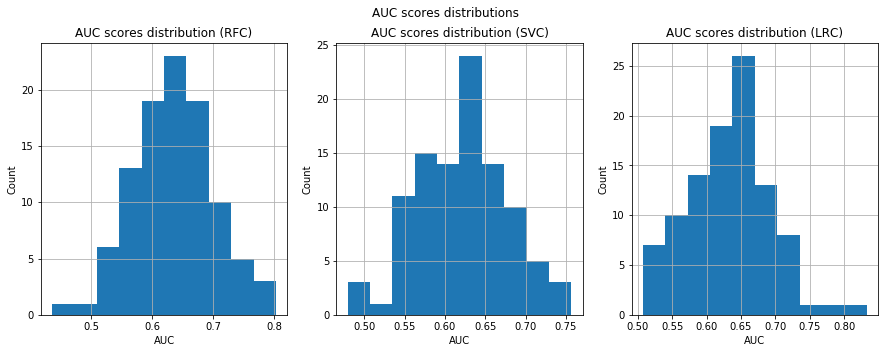

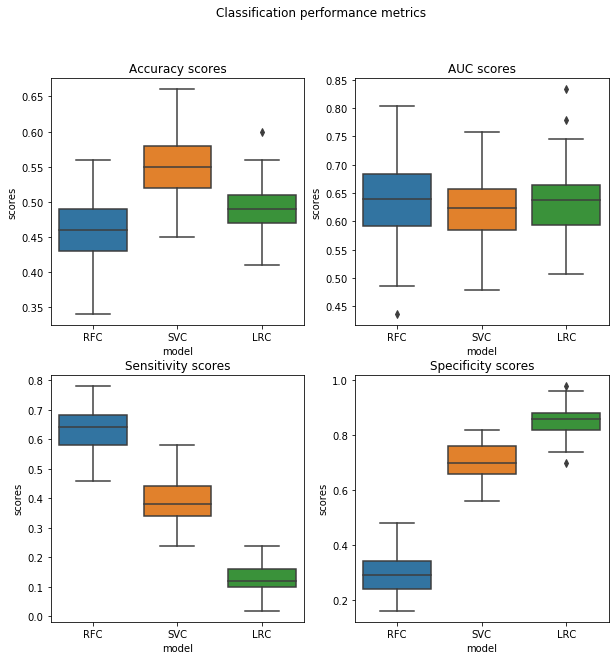

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.46 (0.36, 0.55)  0.55 (0.47, 0.62)  0.49 (0.43, 0.56)
AUC          0.64 (0.52, 0.77)  0.62 (0.51, 0.72)  0.64 (0.53, 0.74)
sensitivity  0.64 (0.51, 0.78)  0.38 (0.27, 0.53)  0.12 (0.06, 0.22)
specificity  0.29 (0.20, 0.40)  0.70 (0.59, 0.81)  0.86 (0.76, 0.95)

In [72]:
model_RFC_PD_NAWM, model_SVC_PD_NAWM, model_LRC_PD_NAWM = classificationPipeline('PD', 'NAWM', 100, pt = True)

Features to model: ['original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_ngtdm_Busyness', 'original_gldm_LargeDependenceHighGrayLevelEmphasis']


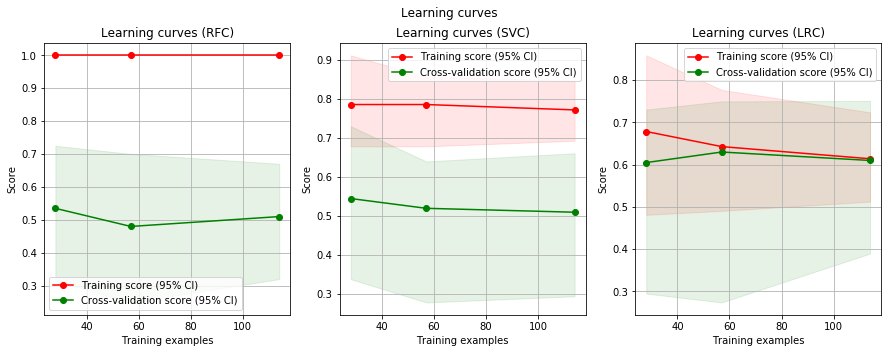

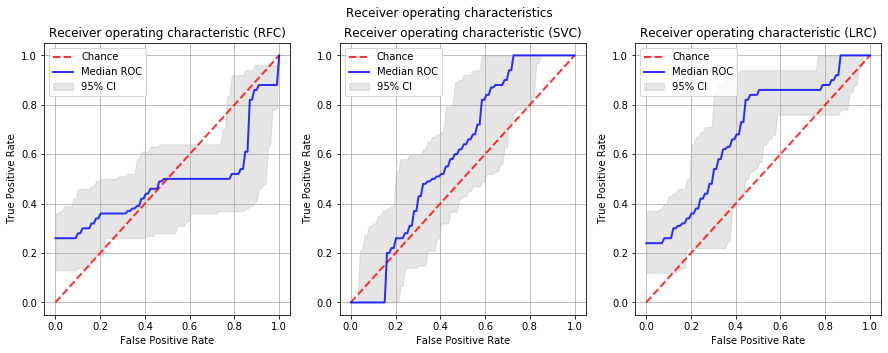

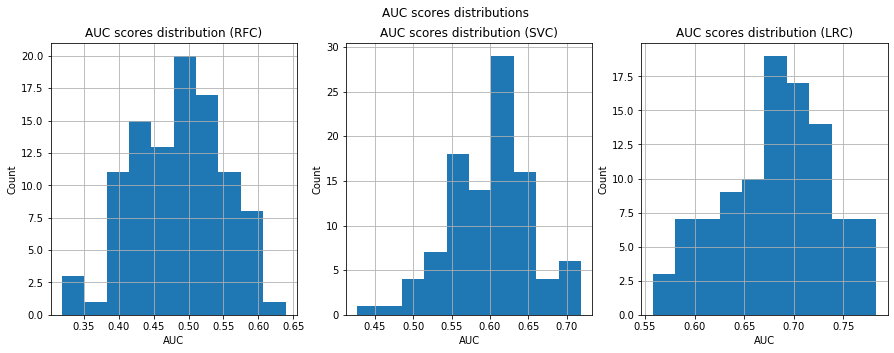

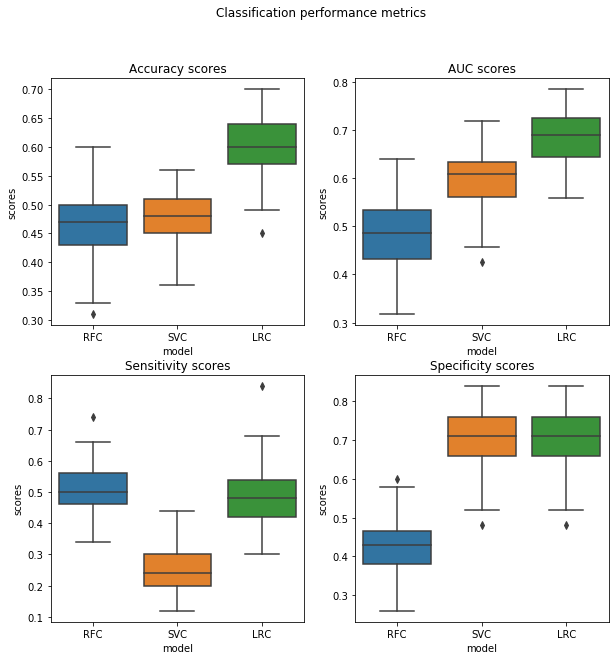

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.47 (0.36, 0.57)  0.48 (0.39, 0.55)  0.60 (0.49, 0.68)
AUC          0.49 (0.34, 0.60)  0.61 (0.50, 0.71)  0.69 (0.58, 0.77)
sensitivity  0.50 (0.37, 0.64)  0.24 (0.14, 0.38)  0.48 (0.34, 0.62)
specificity  0.43 (0.28, 0.57)  0.71 (0.58, 0.80)  0.71 (0.58, 0.80)

In [73]:
model_RFC_MT_NAWM, model_SVC_MT_NAWM, model_LRC_MT_NAWM = classificationPipeline('MT', 'NAWM', 100, pt = True)

Features to model: ['original_firstorder_Minimum', 'original_firstorder_Range', 'original_gldm_LargeDependenceHighGrayLevelEmphasis']


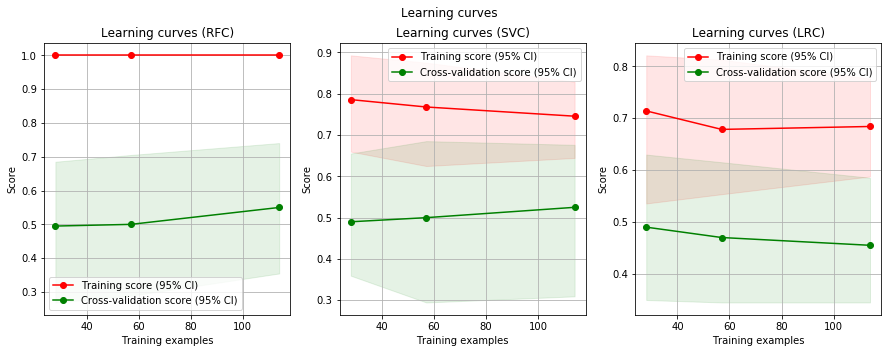

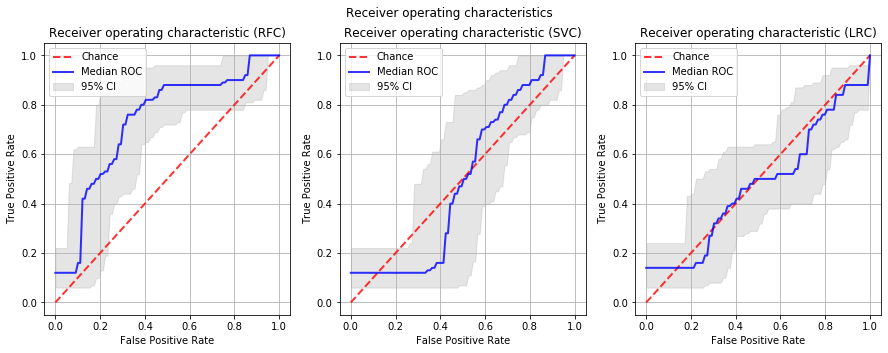

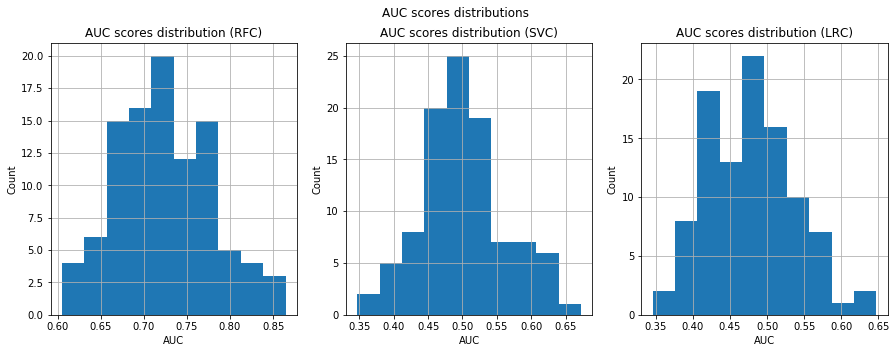

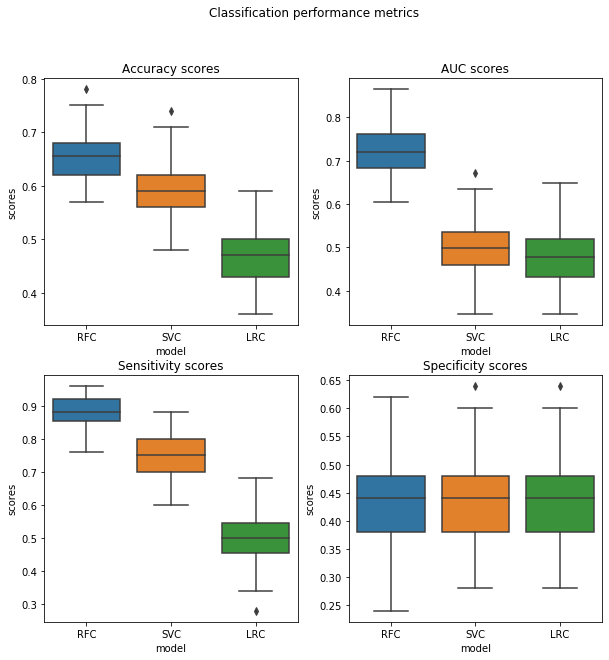

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.66 (0.58, 0.75)  0.59 (0.51, 0.71)  0.47 (0.37, 0.58)
AUC          0.72 (0.62, 0.84)  0.50 (0.39, 0.63)  0.48 (0.39, 0.59)
sensitivity  0.88 (0.78, 0.96)  0.75 (0.64, 0.87)  0.50 (0.38, 0.64)
specificity  0.44 (0.29, 0.56)  0.44 (0.31, 0.58)  0.44 (0.31, 0.58)

In [74]:
model_RFC_R1_NAWM, model_SVC_R1_NAWM, model_LRC_R1_NAWM = classificationPipeline('R1', 'NAWM', 100, pt = True)

Features to model: ['original_firstorder_Range', 'original_gldm_DependenceEntropy', 'original_firstorder_90Percentile']


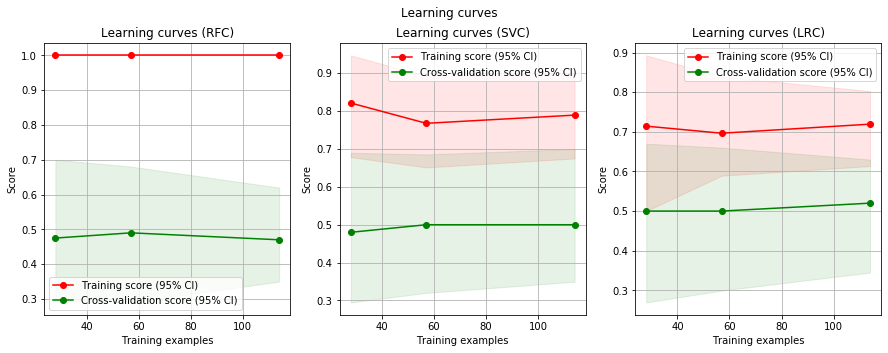

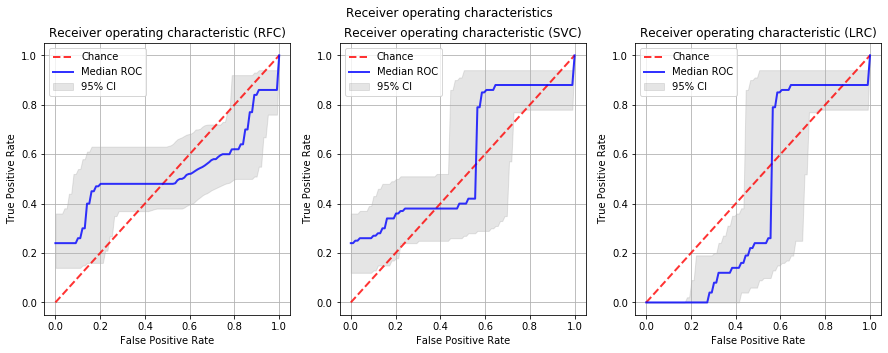

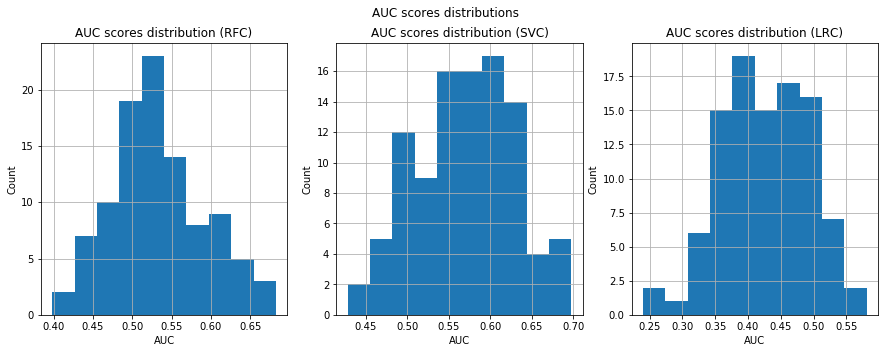

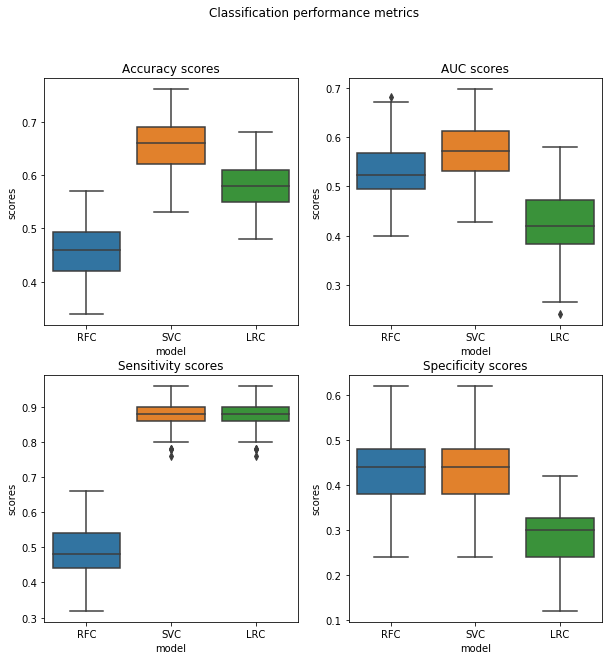

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.46 (0.37, 0.56)  0.66 (0.57, 0.74)  0.58 (0.50, 0.66)
AUC          0.52 (0.43, 0.66)  0.57 (0.46, 0.69)  0.42 (0.31, 0.54)
sensitivity  0.48 (0.37, 0.63)  0.88 (0.78, 0.94)  0.88 (0.78, 0.94)
specificity  0.44 (0.29, 0.56)  0.44 (0.29, 0.56)  0.30 (0.16, 0.40)

In [75]:
model_RFC_R2s_NAWM, model_SVC_R2s_NAWM, model_LRC_R2s_NAWM = classificationPipeline('R2s', 'NAWM', 100, pt = True)

Features to model: ['R1_firstorder_Skewness', 'R1_ngtdm_Strength', 'R2_firstorder_Range']


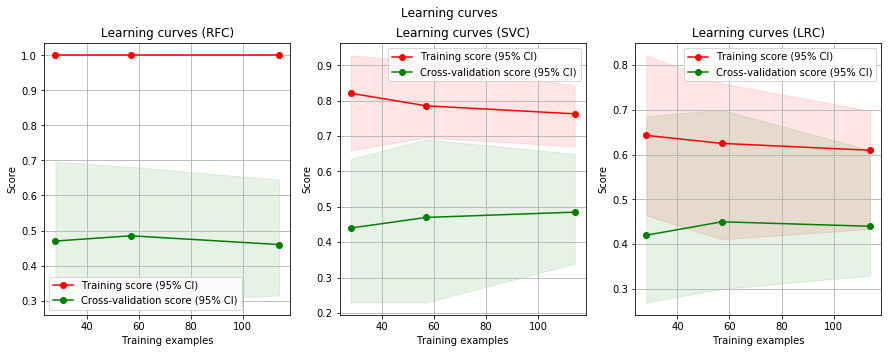

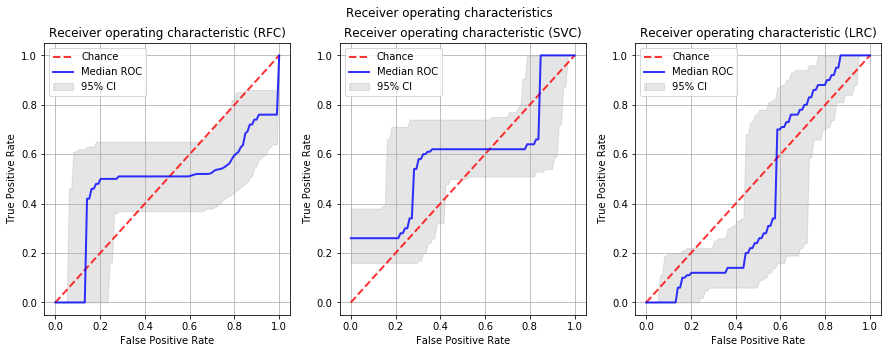

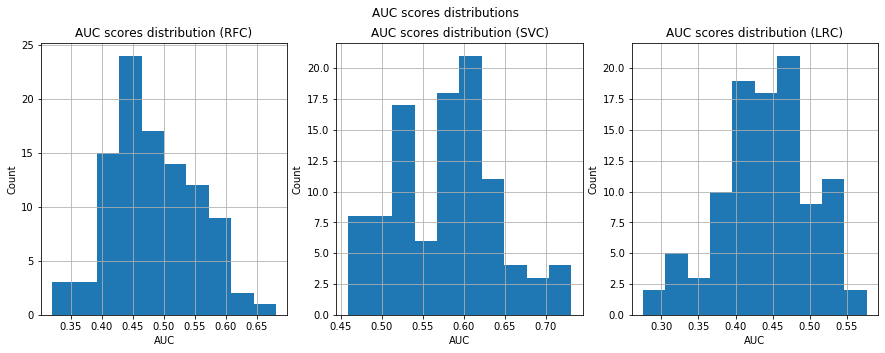

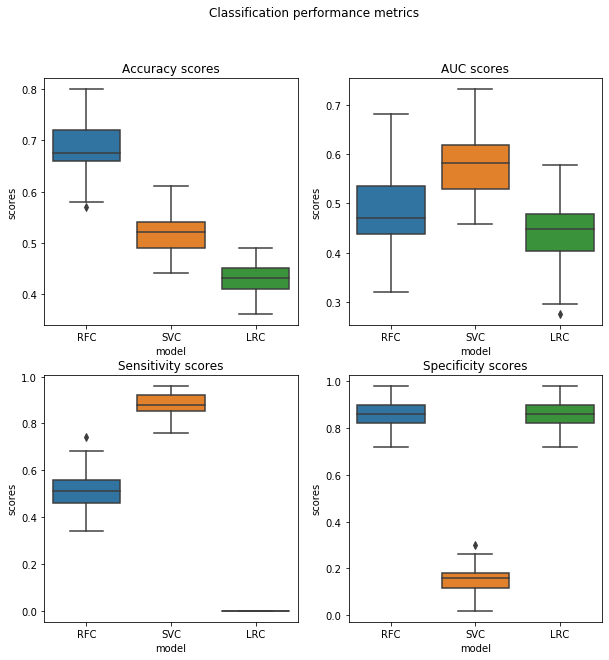

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.68 (0.60, 0.77)  0.52 (0.45, 0.57)  0.43 (0.37, 0.47)
AUC          0.47 (0.37, 0.62)  0.58 (0.46, 0.71)  0.45 (0.32, 0.55)
sensitivity  0.51 (0.37, 0.65)  0.88 (0.78, 0.96)  0.00 (0.00, 0.00)
specificity  0.86 (0.75, 0.94)  0.16 (0.05, 0.23)  0.86 (0.75, 0.94)

In [76]:
model_RFC_qMRI_NAWM, model_SVC_qMRI_NAWM, model_LRC_qMRI_NAWM = classificationPipeline('qMRI', 'NAWM', 100, pt = True)

Features to model: ['original_firstorder_Minimum', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glrlm_RunLengthNonUniformity']


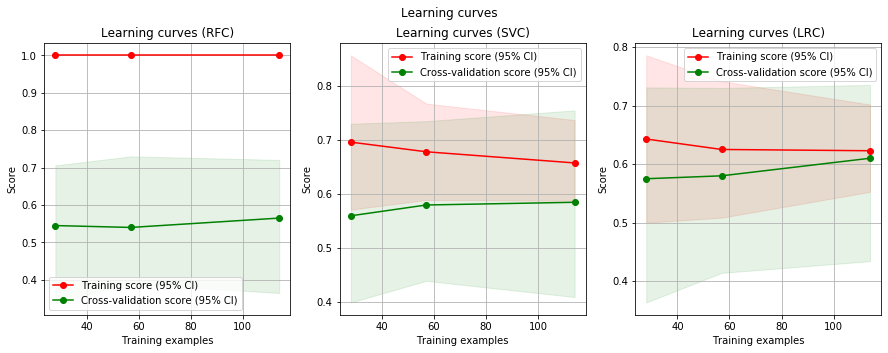

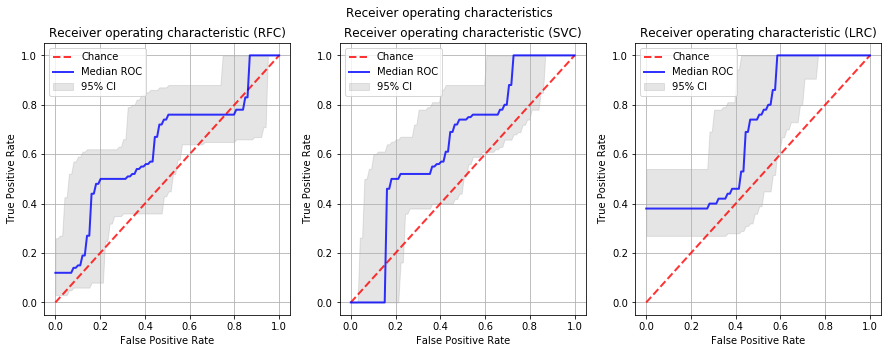

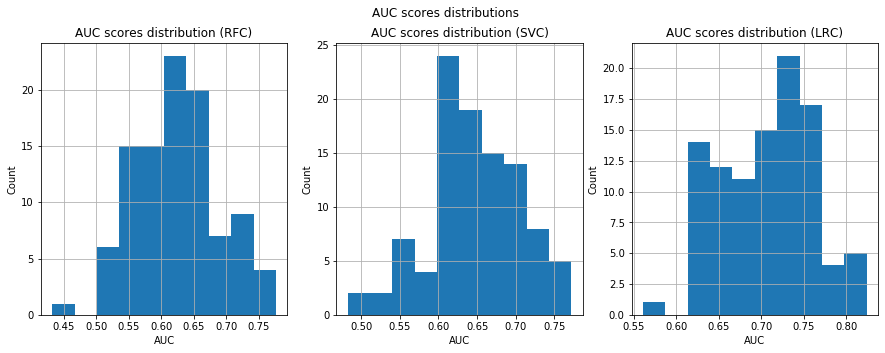

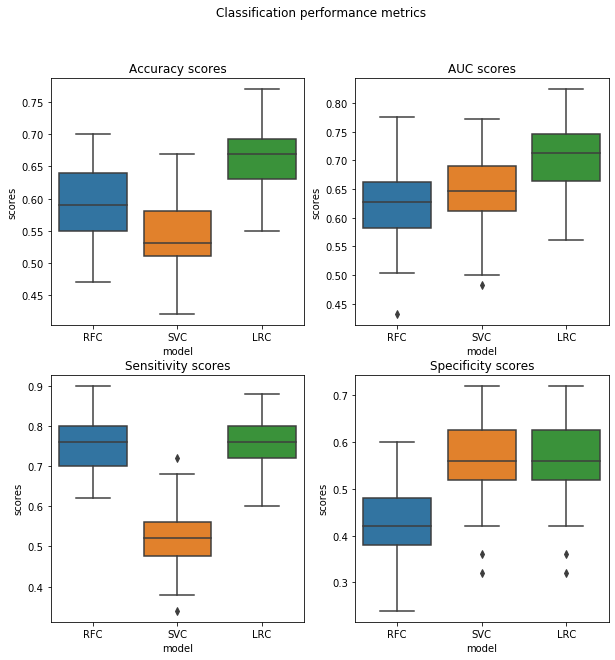

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.59 (0.49, 0.70)  0.53 (0.45, 0.64)  0.67 (0.57, 0.76)
AUC          0.63 (0.52, 0.75)  0.65 (0.53, 0.75)  0.71 (0.61, 0.82)
sensitivity  0.76 (0.65, 0.88)  0.52 (0.38, 0.67)  0.76 (0.63, 0.88)
specificity  0.42 (0.27, 0.59)  0.56 (0.43, 0.72)  0.56 (0.43, 0.72)

In [77]:
model_RFC_T1w_GM, model_SVC_T1w_GM, model_LRC_T1w_GM = classificationPipeline('T1w', 'GM', 100, pt = True)

Features to model: ['original_gldm_DependenceEntropy', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_glcm_ClusterShade']


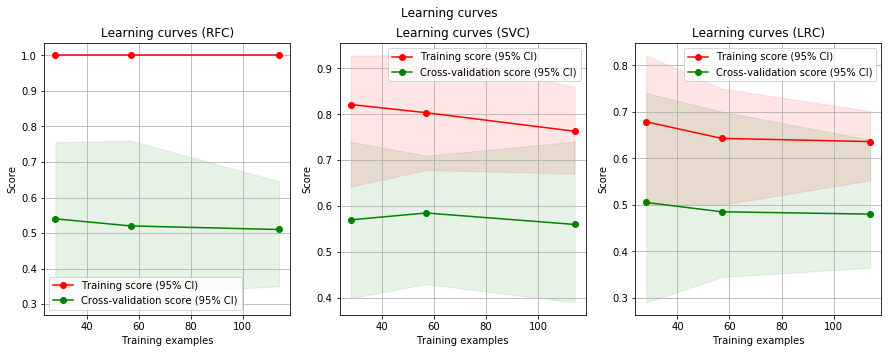

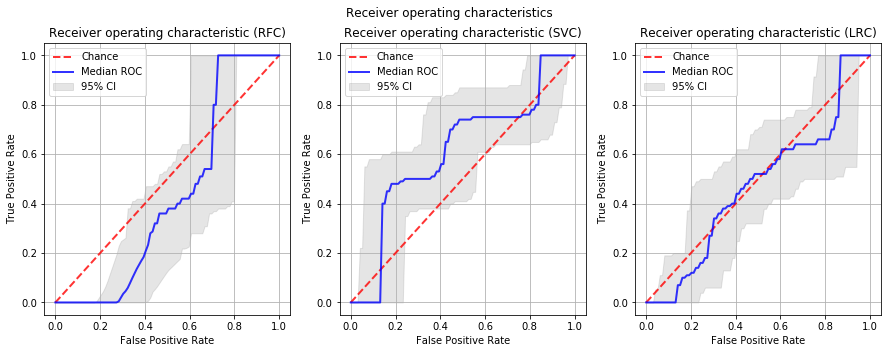

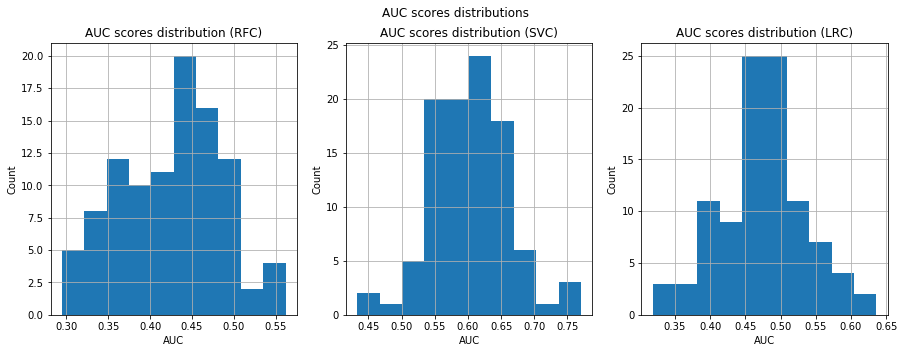

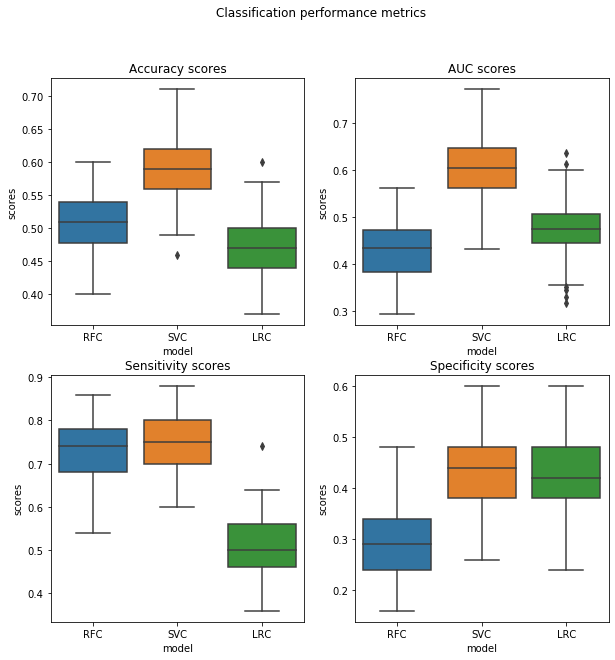

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.51 (0.41, 0.59)  0.59 (0.50, 0.68)  0.47 (0.38, 0.57)
AUC          0.43 (0.31, 0.55)  0.60 (0.50, 0.73)  0.47 (0.35, 0.60)
sensitivity  0.74 (0.60, 0.85)  0.75 (0.64, 0.87)  0.50 (0.38, 0.62)
specificity  0.29 (0.20, 0.40)  0.44 (0.30, 0.57)  0.42 (0.27, 0.59)

In [78]:
model_RFC_PD_GM, model_SVC_PD_GM, model_LRC_PD_GM = classificationPipeline('PD', 'GM', 100, pt = True)

Features to model: ['original_firstorder_Range', 'original_gldm_DependenceVariance', 'original_firstorder_Skewness']


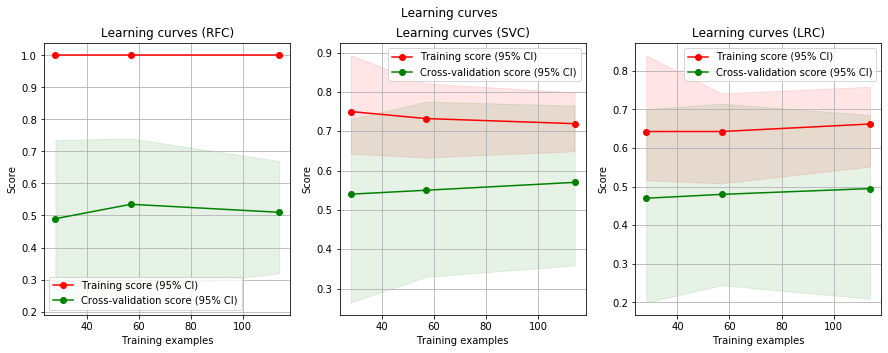

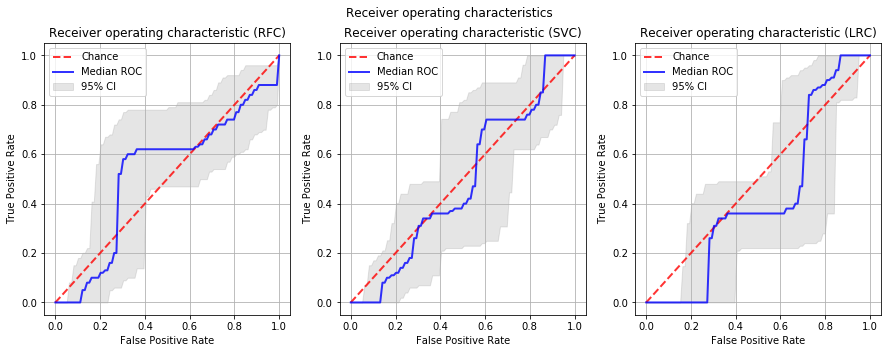

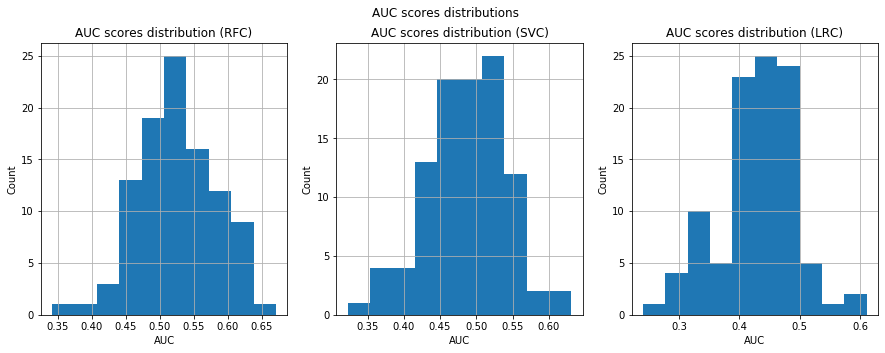

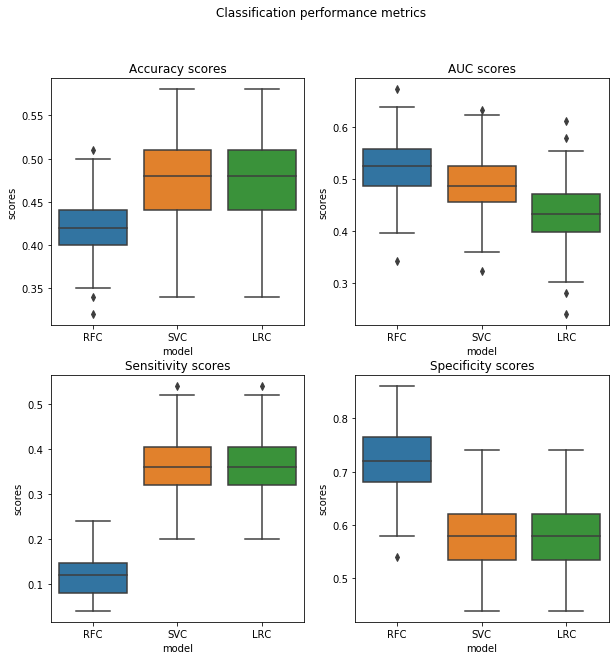

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.42 (0.35, 0.49)  0.48 (0.37, 0.57)  0.48 (0.37, 0.57)
AUC          0.52 (0.42, 0.64)  0.49 (0.37, 0.58)  0.43 (0.30, 0.54)
sensitivity  0.12 (0.04, 0.22)  0.36 (0.22, 0.49)  0.36 (0.22, 0.49)
specificity  0.72 (0.60, 0.83)  0.58 (0.45, 0.71)  0.58 (0.45, 0.71)

In [79]:
model_RFC_MT_GM, model_SVC_MT_GM, model_LRC_MT_GM = classificationPipeline('MT', 'GM', 100, pt = True)

Features to model: ['original_glcm_ClusterShade', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_Kurtosis']


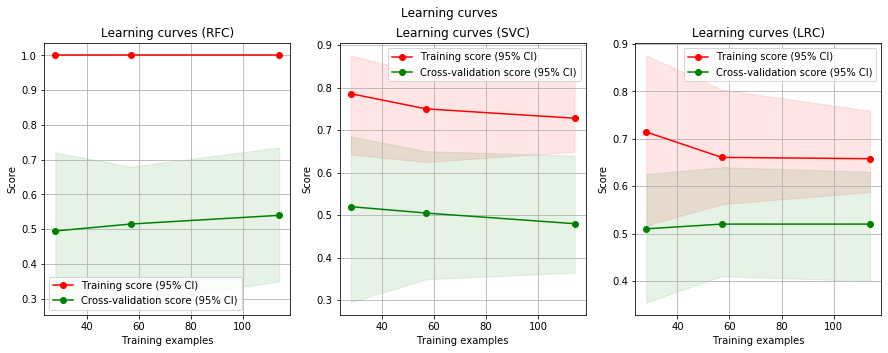

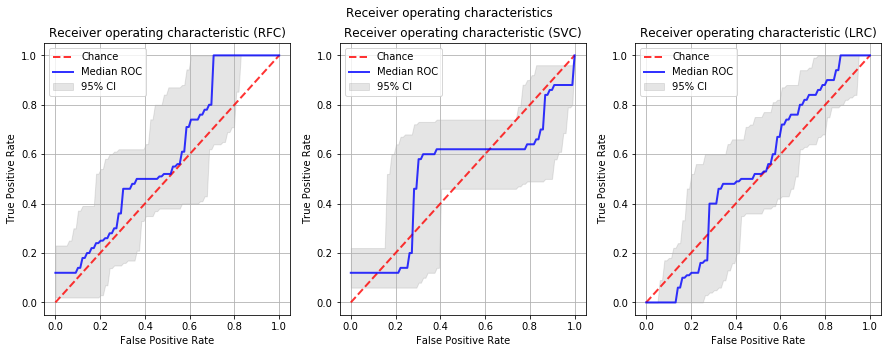

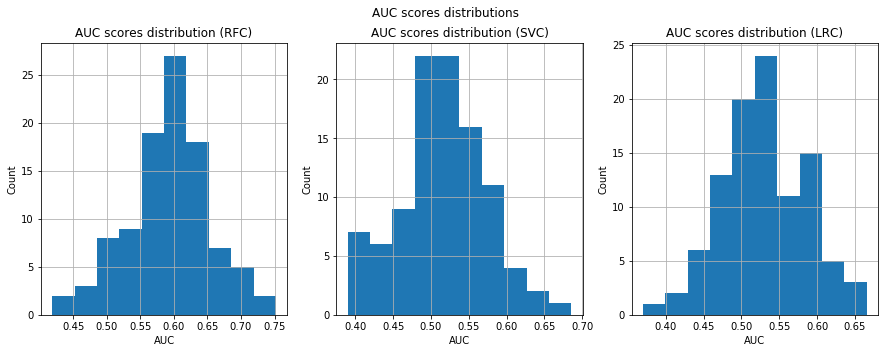

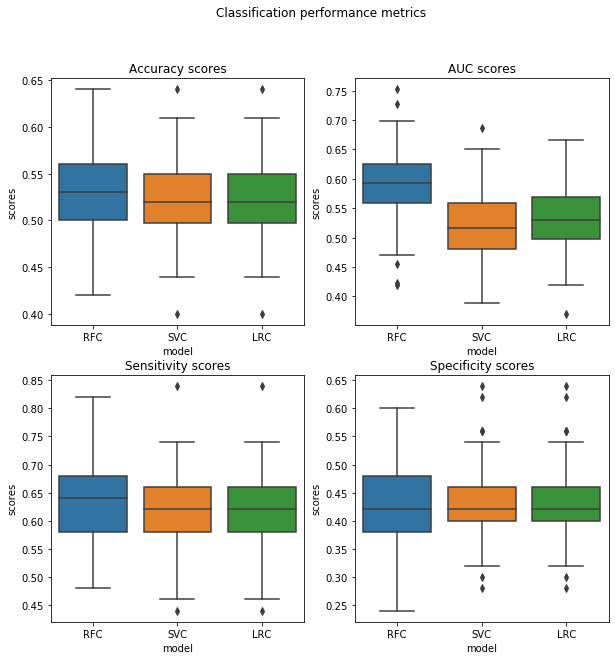

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.53 (0.43, 0.62)  0.52 (0.45, 0.61)  0.52 (0.45, 0.61)
AUC          0.59 (0.46, 0.70)  0.52 (0.41, 0.63)  0.53 (0.43, 0.63)
sensitivity  0.64 (0.49, 0.77)  0.62 (0.46, 0.74)  0.62 (0.46, 0.74)
specificity  0.42 (0.32, 0.57)  0.42 (0.32, 0.56)  0.42 (0.32, 0.56)

In [80]:
model_RFC_R1_GM, model_SVC_R1_GM, model_LRC_R1_GM = classificationPipeline('R1', 'GM', 100, pt = True)

Features to model: ['original_glrlm_GrayLevelNonUniformity', 'original_ngtdm_Busyness', 'original_glszm_SizeZoneNonUniformityNormalized']


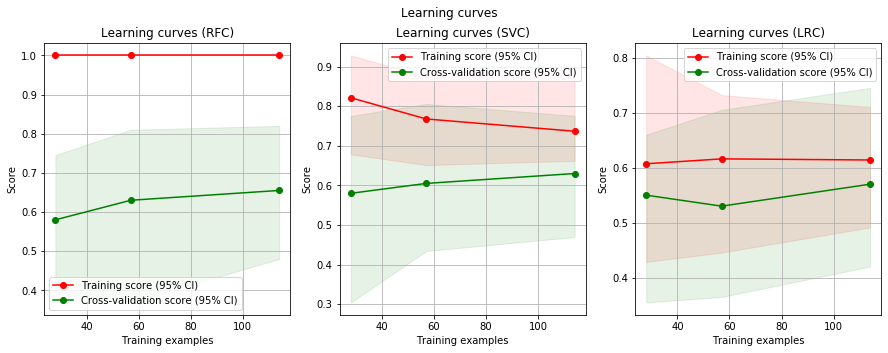

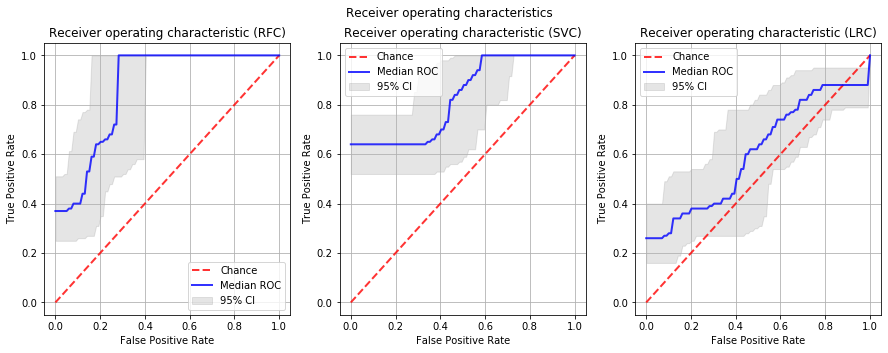

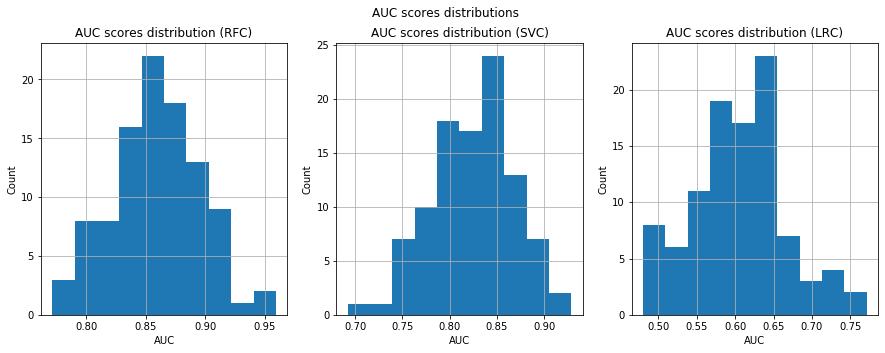

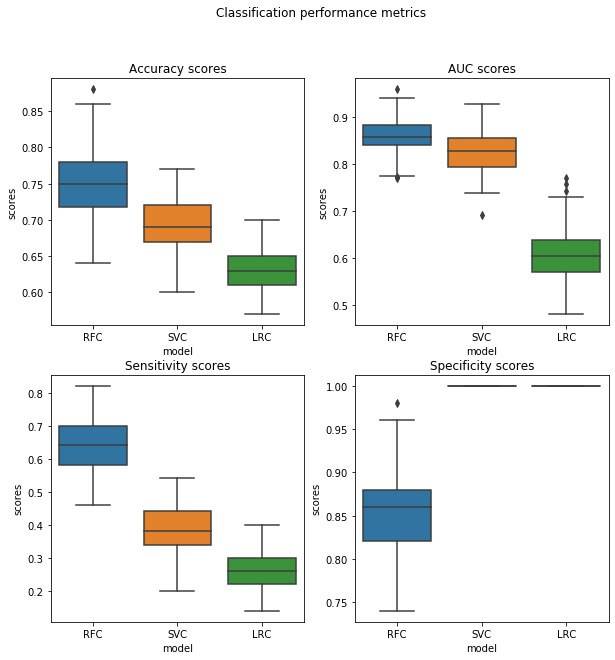

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.75 (0.67, 0.84)  0.69 (0.63, 0.77)  0.63 (0.58, 0.70)
AUC          0.86 (0.78, 0.92)  0.83 (0.75, 0.90)  0.60 (0.49, 0.74)
sensitivity  0.64 (0.50, 0.78)  0.38 (0.26, 0.53)  0.26 (0.16, 0.40)
specificity  0.86 (0.77, 0.94)  1.00 (1.00, 1.00)  1.00 (1.00, 1.00)

In [81]:
model_RFC_R2s_GM, model_SVC_R2s_GM, model_LRC_R2s_GM = classificationPipeline('R2s', 'GM', 100, pt = True)

Features to model: ['R1_glcm_ClusterProminence', 'R2_gldm_DependenceEntropy', 'R2_firstorder_Minimum']


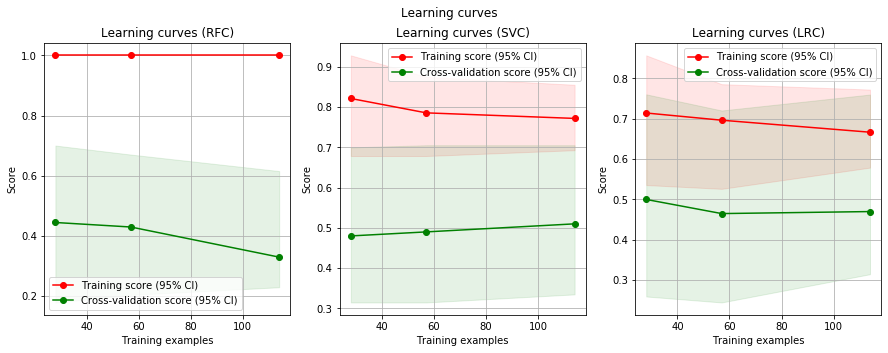

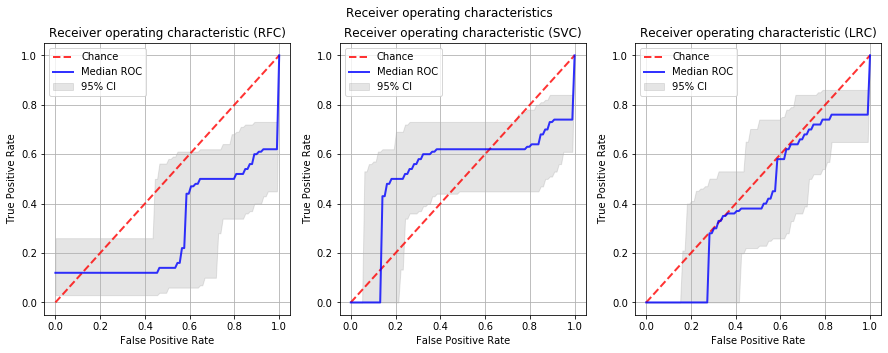

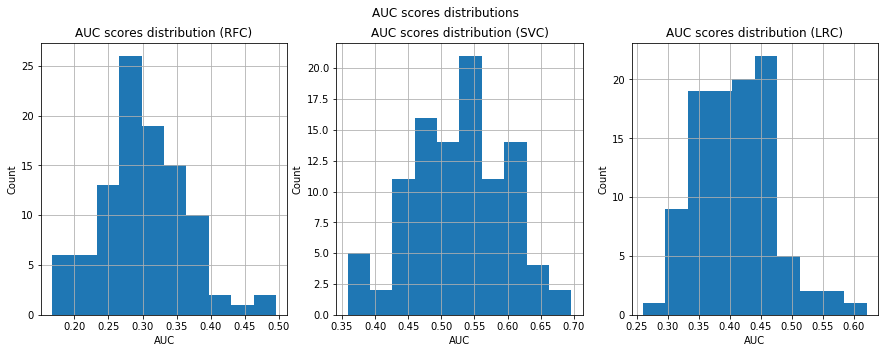

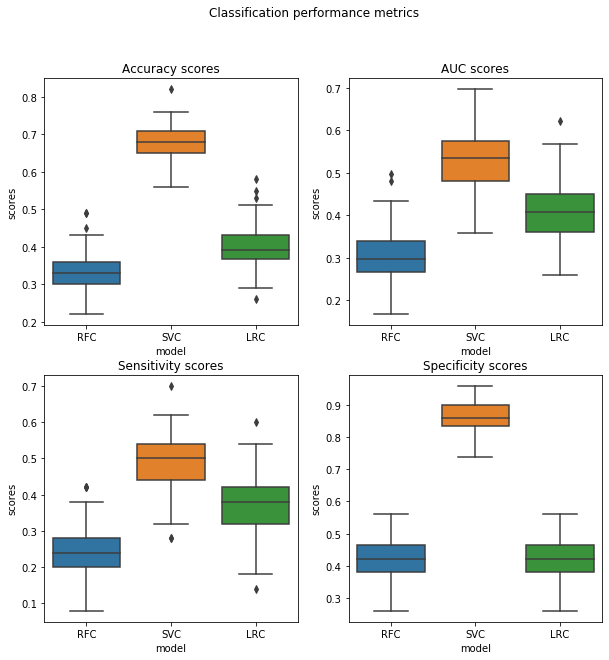

Performance metrics comparison


RFC                SVC                LRC
score                                                               
accuracy     0.33 (0.23, 0.44)  0.68 (0.57, 0.75)  0.39 (0.30, 0.52)
AUC          0.30 (0.18, 0.43)  0.54 (0.38, 0.65)  0.41 (0.30, 0.54)
sensitivity  0.24 (0.16, 0.40)  0.50 (0.34, 0.62)  0.38 (0.22, 0.53)
specificity  0.42 (0.28, 0.56)  0.86 (0.77, 0.94)  0.42 (0.28, 0.56)

In [82]:
model_RFC_qMRI_GM, model_SVC_qMRI_GM, model_LRC_qMRI_GM = classificationPipeline('qMRI', 'GM', 100, pt = True)

In [83]:
for img_type in ['T1w', 'PD', 'MT', 'R1', 'R2s', 'qMRI']:
    for roi_type in ['WM', 'NAWM', 'GM']:
        
        path_dev = "../results/performance/performance_auc_CRC_" + img_type + "_" + roi_type + ".csv"
        path_rand = "../results/performance/performance_auc_CRC_" + img_type + "_" + roi_type + "_rand.csv"

        df_dev = pd.read_csv(path_dev)
        df_rand = pd.read_csv(path_rand)

        print (img_type, roi_type)
        print (np.sum(np.array(list(df_dev[df_dev.model == 'LRC'].scores - df_rand[df_rand.model == 'LRC'].scores))<0)/100)

T1w WM
0.0
T1w NAWM
0.0
T1w GM
0.84
PD WM
0.0
PD NAWM
0.33
PD GM
0.0
MT WM
0.0
MT NAWM
0.09
MT GM
0.0
R1 WM
0.0
R1 NAWM
0.0
R1 GM
0.0
R2s WM
0.0
R2s NAWM
0.0
R2s GM
0.0
qMRI WM
0.0
qMRI NAWM
0.0
qMRI GM
0.0


In [89]:
import time
t0 = time.time()
model_RFC_qMRI_GM.predict([[50, 30, 80]])
t1 = time.time()
total = t1-t0
print (total)

0.025998353958129883
